## Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import openpyxl
from scipy.optimize import curve_fit
from sklearn.metrics import mean_squared_error
import seaborn as sns
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gmean
from scipy.ndimage import gaussian_filter
from matplotlib import cm

## Data reading and transformation

### Options data

In [2]:
import pandas as pd
import xarray as xr

def load_iv_data(file_path):
    data_iv = {"SPY_Put": [], "SPY_Call": [], "QQQ_Put": [], "QQQ_Call": []}
    data_mid = {"SPY_Put": [], "SPY_Call": [], "QQQ_Put": [], "QQQ_Call": []}
    snapshot_dates = {"SPY_Put": [], "SPY_Call": [], "QQQ_Put": [], "QQQ_Call": []}
    strikes_master_iv = {"SPY_Put": set(), "SPY_Call": set(), "QQQ_Put": set(), "QQQ_Call": set()}
    strikes_master_mid = {"SPY_Put": set(), "SPY_Call": set(), "QQQ_Put": set(), "QQQ_Call": set()}
    maturities_master_iv = {"SPY_Put": set(), "SPY_Call": set(), "QQQ_Put": set(), "QQQ_Call": set()}
    maturities_master_mid = {"SPY_Put": set(), "SPY_Call": set(), "QQQ_Put": set(), "QQQ_Call": set()}

    xls = pd.ExcelFile(file_path)

    for sheet_name in xls.sheet_names:
        parts = sheet_name.split('_')
        if len(parts) != 3:
            print(f"Skipping sheet {sheet_name}: unexpected naming format.")
            continue
        index, put_call, snapshot_date = parts
        key = f"{index}_{put_call}"

        if key not in data_iv:
            print(f"Skipping sheet {sheet_name}: unrecognized category.")
            continue

        df = pd.read_excel(file_path, sheet_name=sheet_name)
        df = df.set_index(df.columns[0])
        df.columns = df.columns.astype(str)

        # Split columns
        iv_columns = [col for col in df.columns if not col.endswith('_mid')]
        mid_columns = [col for col in df.columns if col.endswith('_mid')]

        # Process iv data
        df_iv = df[iv_columns]
        df_iv.columns = [col.replace('_', '') for col in df_iv.columns]  # Ensure format is consistent
        data_iv[key].append(df_iv)
        snapshot_dates[key].append(snapshot_date)
        strikes_master_iv[key].update(df_iv.index)
        maturities_master_iv[key].update(df_iv.columns)

        # Process mid data
        df_mid = df[mid_columns]
        df_mid.columns = [col.replace('_mid', '').replace('_', '') for col in df_mid.columns]
        data_mid[key].append(df_mid)
        strikes_master_mid[key].update(df_mid.index)
        maturities_master_mid[key].update(df_mid.columns)

    # Function to build DataArray
    def build_xarray(data_dict, strikes_master, maturities_master):
        result = {}
        for key in data_dict.keys():
            if not data_dict[key]:
                continue
            strikes_all = sorted(strikes_master[key])
            maturities_all = sorted(maturities_master[key], key=lambda x: int(x))
            all_data = []
            for df in data_dict[key]:
                df_reindexed = df.reindex(index=strikes_all, columns=maturities_all)
                all_data.append(df_reindexed.values)

            snapshots = pd.to_datetime(snapshot_dates[key], format="%Y%m%d")

            da = xr.DataArray(
                data=all_data,  # (snapshot, strike, maturity)
                coords={
                    'snapshot_date': snapshots,
                    'strike': strikes_all,
                    'maturity': maturities_all
                },
                dims=['snapshot_date', 'strike', 'maturity']
            ).transpose('strike', 'maturity', 'snapshot_date')

            result[key] = da
        return result

    ivs_data = build_xarray(data_iv, strikes_master_iv, maturities_master_iv)
    premium_data = build_xarray(data_mid, strikes_master_mid, maturities_master_mid)

    return ivs_data, premium_data

# Usage
file_path = 'All_IVS.xlsx'
ivs_data, premium_data = load_iv_data(file_path)

#spy_put = ivs_data.get('SPY_Put')
#spy_call = ivs_data.get('SPY_Call')
#qqq_put = ivs_data.get('QQQ_Put')
#qqq_call = ivs_data.get('QQQ_Call')


In [3]:
def transform_coords(data_dict):
    transformed = {}
    for key, da in data_dict.items():
        da_new = da.assign_coords(
            snapshot_date=pd.to_datetime(da.coords['snapshot_date'].values).strftime('%Y-%m-%d'),
            maturity=[
                pd.to_datetime(str(m), format='%Y%m%d').strftime('%Y-%m-%d')
                for m in da.coords['maturity'].values
            ]
        )
        transformed[key] = da_new
    return transformed

# Apply transformation
ivs_data = transform_coords(ivs_data)
premium_data = transform_coords(premium_data)

In [4]:
print(premium_data.get('SPY_Put').coords['maturity'].values)

['2025-04-11' '2025-04-25' '2025-05-16' '2025-06-20' '2025-12-19'
 '2026-06-18' '2026-12-18' '2027-01-15' '2027-12-17']


###Plots

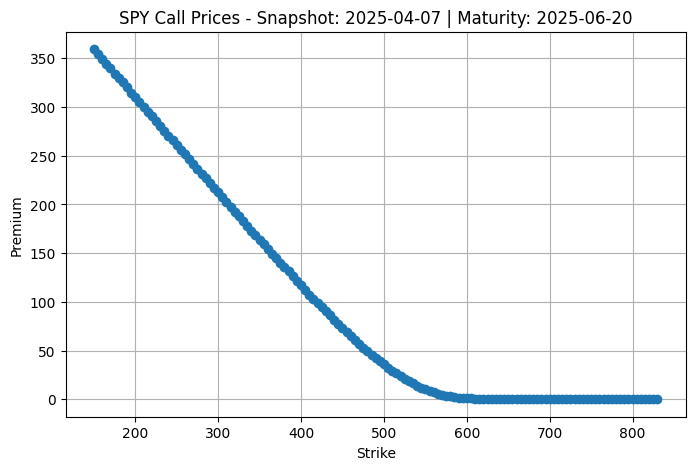

In [5]:
# Select the data slice
data_slice = premium_data.get('SPY_Call').sel(snapshot_date='2025-04-07', maturity='2025-06-20')

# Plot
plt.figure(figsize=(8, 5))
plt.plot(data_slice.coords['strike'].values, data_slice.values, marker='o')
plt.title('SPY Call Prices - Snapshot: 2025-04-07 | Maturity: 2025-06-20')
plt.xlabel('Strike')
plt.ylabel('Premium')
plt.grid(True)
plt.show()

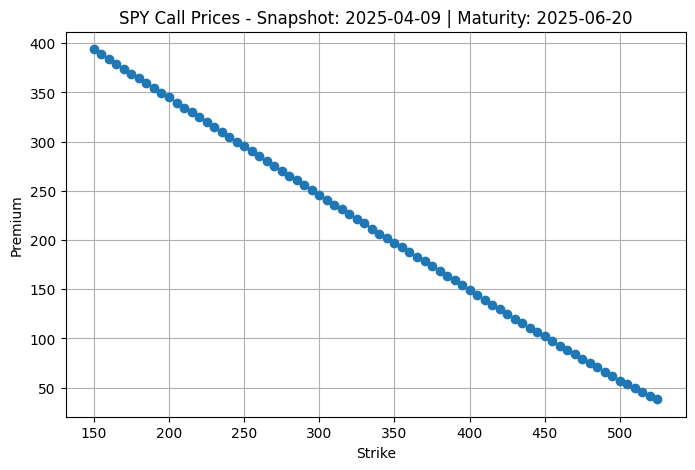

In [6]:
# Select the data slice
data_slice = premium_data.get('SPY_Call').sel(snapshot_date='2025-04-09', maturity='2025-06-20')

# Plot
plt.figure(figsize=(8, 5))
plt.plot(data_slice.coords['strike'].values, data_slice.values, marker='o')
plt.title('SPY Call Prices - Snapshot: 2025-04-09 | Maturity: 2025-06-20')
plt.xlabel('Strike')
plt.ylabel('Premium')
plt.grid(True)
plt.savefig("spy_call_prices2.png")
plt.show()

IV


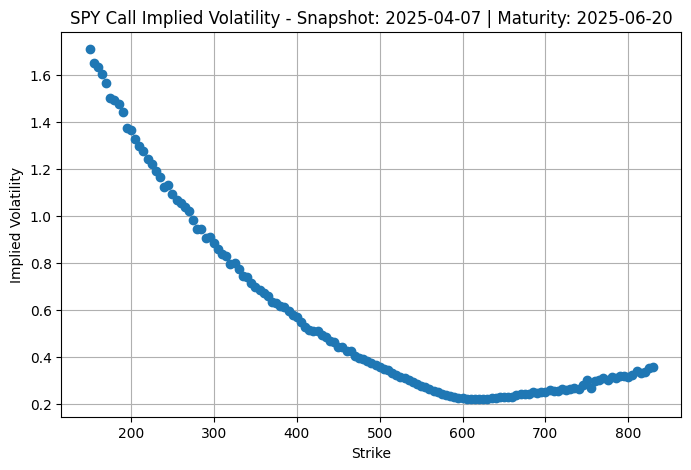

In [7]:
# Select the data slice for IV
iv_data_slice = ivs_data.get('SPY_Call').sel(snapshot_date='2025-04-07', maturity='2025-06-20')

# Plot the IVs
plt.figure(figsize=(8, 5))
plt.plot(iv_data_slice.coords['strike'].values, iv_data_slice.values, marker='o', linestyle='')
plt.title('SPY Call Implied Volatility - Snapshot: 2025-04-07 | Maturity: 2025-06-20')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.savefig("spy_call_iv.png")
plt.show()

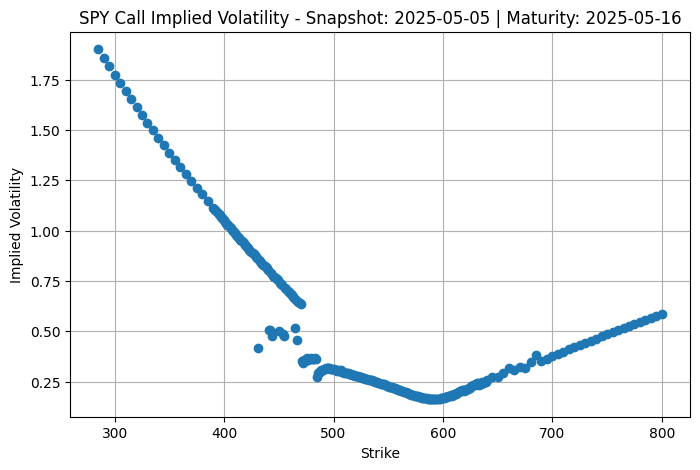

In [8]:
# Select the data slice for IV
iv_data_slice = ivs_data.get('SPY_Call').sel(snapshot_date='2025-05-05', maturity='2025-05-16')

# Plot the IVs
plt.figure(figsize=(8, 5))
plt.plot(iv_data_slice.coords['strike'].values, iv_data_slice.values, marker='o', linestyle='')
plt.title('SPY Call Implied Volatility - Snapshot: 2025-05-05 | Maturity: 2025-05-16')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.grid(True)
plt.savefig("spy_call_iv2.png")
plt.show()

IV Surface

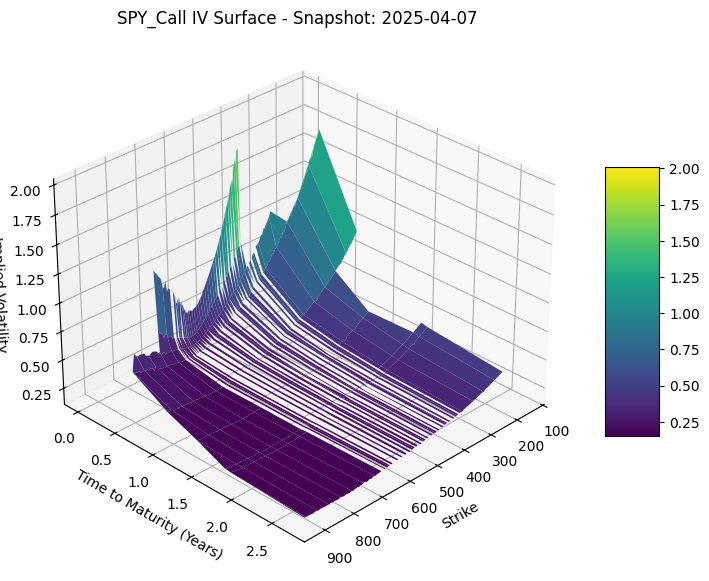

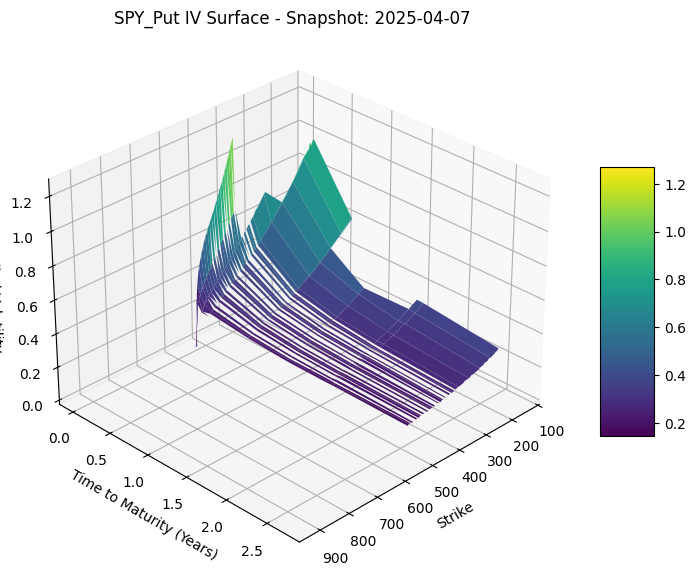

In [9]:

from mpl_toolkits.mplot3d import Axes3D

def plot_3d_iv_surface(data_dict, option_type, snapshot_date_str):
  """
  Plots the 3D IV surface for a given option type and snapshot date.

  Args:
    data_dict (dict): Dictionary containing the xarray DataArrays.
    option_type (str): The key for the specific option data (e.g., 'SPY_Call').
    snapshot_date_str (str): The snapshot date in 'YYYY-MM-DD' format.
  """
  da = data_dict.get(option_type)
  if da is None:
    print(f"Data for {option_type} not found.")
    return

  try:
    data_at_snapshot = da.sel(snapshot_date=snapshot_date_str)
  except KeyError:
    print(f"Snapshot date {snapshot_date_str} not found for {option_type}.")
    return

  strikes = data_at_snapshot.coords['strike'].values
  maturities = pd.to_datetime(data_at_snapshot.coords['maturity'].values)
  ivs = data_at_snapshot.values

  # Calculate Time to Maturity in years
  snapshot_dt = pd.to_datetime(snapshot_date_str)
  ttm_years = (maturities - snapshot_dt).days / 365.25

  # Create a grid for plotting
  X, Y = np.meshgrid(strikes, ttm_years)
  Z = ivs.T # Transpose to match meshgrid dimensions

  fig = plt.figure(figsize=(10, 7))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the surface
  surf = ax.plot_surface(X, Y, Z, cmap='viridis')

  ax.set_xlabel('Strike')
  ax.set_ylabel('Time to Maturity (Years)')
  ax.set_zlabel('Implied Volatility')
  ax.set_title(f'{option_type} IV Surface - Snapshot: {snapshot_date_str}')
  ax.view_init(elev=30, azim=45)
  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)

  plt.show()

# Example usage:
plot_3d_iv_surface(ivs_data, 'SPY_Call', '2025-04-07')
plot_3d_iv_surface(ivs_data, 'SPY_Put', '2025-04-07')

Smoothing

<ipython-input-10-042cfbbdd78a>:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ivs_filled = ivs_df.fillna(method='ffill').fillna(method='bfill').values


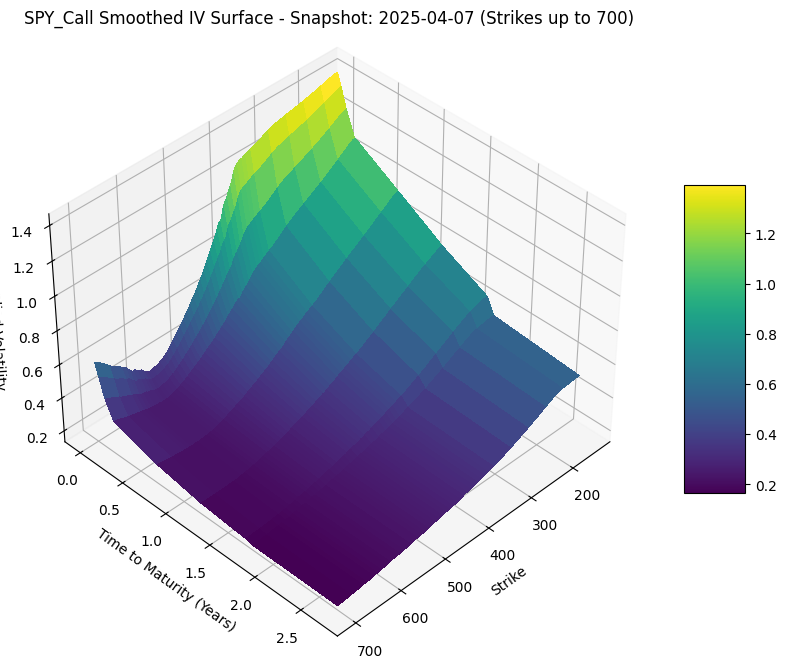

<ipython-input-10-042cfbbdd78a>:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ivs_filled = ivs_df.fillna(method='ffill').fillna(method='bfill').values


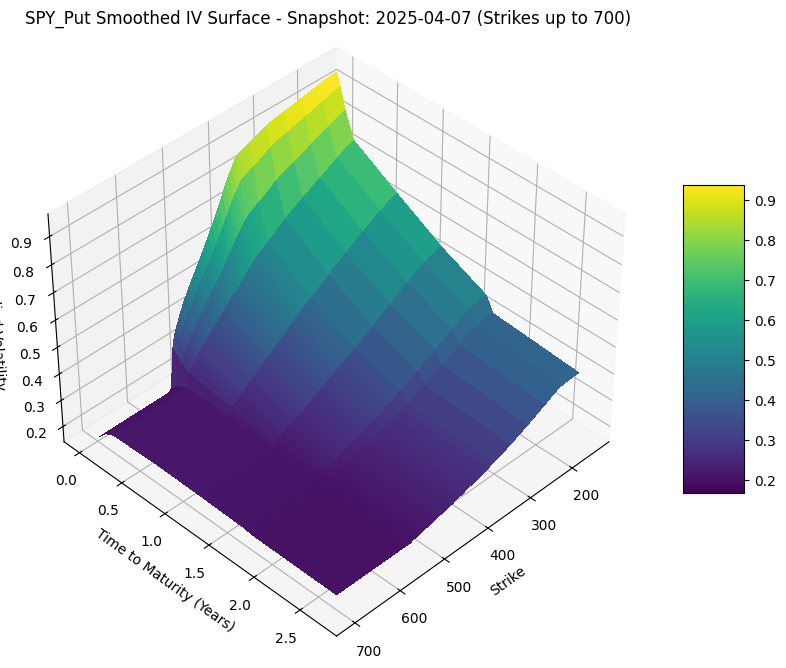

In [10]:

def plot_3d_iv_surface_smoothed_rotated(data_dict, option_type, snapshot_date_str, sigma=1, elev=30, azim=45, max_strike=None):
  """
  Plots the smoothed and rotated 3D IV surface for a given option type and snapshot date,
  with an optional upper limit on the strike values.

  Args:
    data_dict (dict): Dictionary containing the xarray DataArrays.
    option_type (str): The key for the specific option data (e.g., 'SPY_Call').
    snapshot_date_str (str): The snapshot date in 'YYYY-MM-DD' format.
    sigma (float or tuple): Standard deviation for Gaussian kernel. Can be a
                             single value for isotropic smoothing or a tuple
                             for anisotropic smoothing (e.g., (strike_sigma, maturity_sigma)).
    elev (float): Elevation angle in the z-plane.
    azim (float): Azimuth angle in the x,y plane.
    max_strike (int, optional): The maximum strike value to include in the plot.
                                Defaults to None (no limit).
  """
  da = data_dict.get(option_type)
  if da is None:
    print(f"Data for {option_type} not found.")
    return

  try:
    data_at_snapshot = da.sel(snapshot_date=snapshot_date_str)
  except KeyError:
    print(f"Snapshot date {snapshot_date_str} not found for {option_type}.")
    return

  # Apply strike limit if specified
  if max_strike is not None:
      data_at_snapshot = data_at_snapshot.sel(strike=slice(None, max_strike)) # Select strikes up to max_strike

  strikes = data_at_snapshot.coords['strike'].values
  maturities = pd.to_datetime(data_at_snapshot.coords['maturity'].values)
  ivs = data_at_snapshot.values # Original shape (strike, maturity)

  # Handle potential NaNs by filling or interpolating before smoothing
  ivs_df = pd.DataFrame(ivs, index=strikes, columns=maturities)
  ivs_filled = ivs_df.fillna(method='ffill').fillna(method='bfill').values

  # Apply Gaussian smoothing
  smoothed_ivs = gaussian_filter(ivs_filled, sigma=sigma)

  # Calculate Time to Maturity in years
  snapshot_dt = pd.to_datetime(snapshot_date_str)
  ttm_years = (maturities - snapshot_dt).days / 365.25

  # Create a grid for plotting
  X, Y = np.meshgrid(strikes, ttm_years)

  # Z should have shape (len(ttm_years), len(strikes))
  Z = smoothed_ivs.T # Transpose to match meshgrid dimensions

  fig = plt.figure(figsize=(12, 8))
  ax = fig.add_subplot(111, projection='3d')

  # Plot the surface
  surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis, linewidth=0, antialiased=False)

  ax.set_xlabel('Strike')
  ax.set_ylabel('Time to Maturity (Years)')
  ax.set_zlabel('Implied Volatility')
  title = f'{option_type} Smoothed IV Surface - Snapshot: {snapshot_date_str}'
  if max_strike is not None:
      title += f' (Strikes up to {max_strike})'
  ax.set_title(title)

  # Rotate the plot
  ax.view_init(elev=elev, azim=azim)

  # Add a color bar which maps values to colors.
  fig.colorbar(surf, shrink=0.5, aspect=5)

  plt.show()

# Example usage with smoothing, rotation, and strike limit:
plot_3d_iv_surface_smoothed_rotated(ivs_data, 'SPY_Call', '2025-04-07', sigma=2, elev=40, azim=45, max_strike=700)
plot_3d_iv_surface_smoothed_rotated(ivs_data, 'SPY_Put', '2025-04-07', sigma=2, elev=40, azim=45, max_strike=700)


###**Put - Call IV Comparison**

<ipython-input-11-eb8ff22a00ec>:93: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=comparison_df, x='strike', y='iv_diff', ci=95)


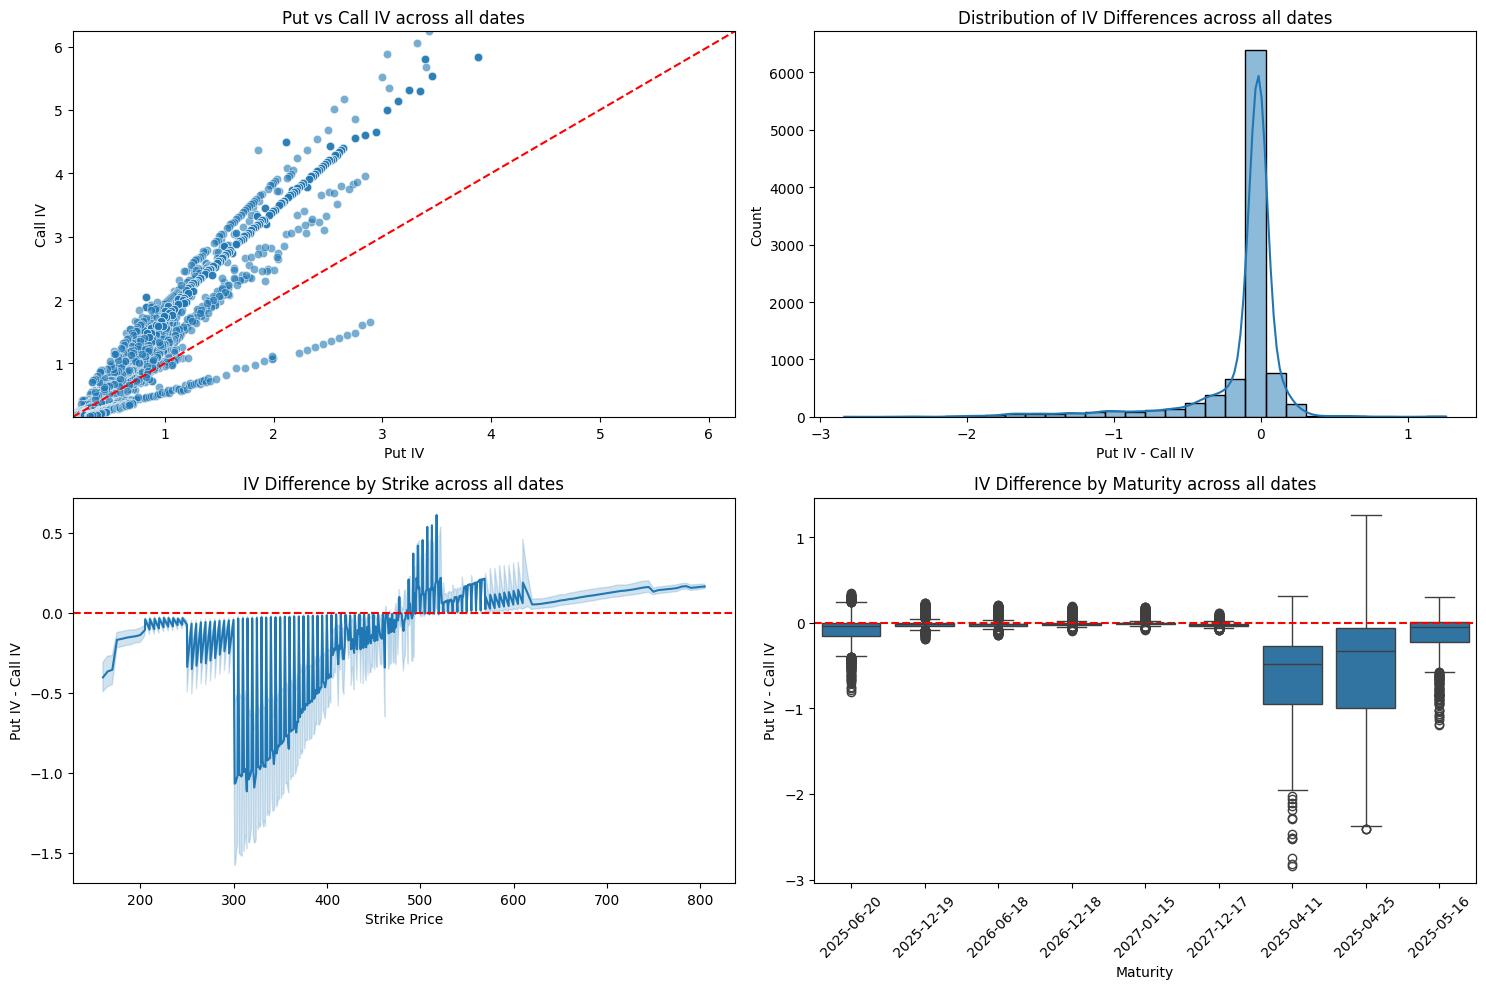


Comparison Statistics:
mean_abs_diff         0.163346
max_abs_diff          2.836300
mean_rel_diff        -8.424149
max_rel_diff         70.550772
num_comparisons    9570.000000
dtype: float64


In [11]:
def compare_put_call_iv(ivs_data, underlying='SPY', snapshot_date=None):
    """
    Compare implied volatility between puts and calls for a given date.

    Parameters:
    - ivs_data: Dictionary containing the xarray DataArrays for each option type
    - underlying: 'SPY' or 'QQQ' (default 'SPY')
    - snapshot_date: Specific date to compare (string in 'YYYY-MM-DD' format)
                    If None, uses all available dates

    Returns:
    - DataFrame with comparison results
    - Plots comparing put and call IVs
    """
    # Get the put and call DataArrays
    put_key = f"{underlying}_Put"
    call_key = f"{underlying}_Call"

    put_da = ivs_data.get(put_key)
    call_da = ivs_data.get(call_key)

    if put_da is None or call_da is None:
        raise ValueError(f"Data not found for {underlying} puts and calls")

    # If no specific date provided, use all dates
    if snapshot_date is None:
        put_data = put_da
        call_data = call_da
    else:
        put_data = put_da.sel(snapshot_date=snapshot_date)
        call_data = call_da.sel(snapshot_date=snapshot_date)

    # Create DataFrames for comparison
    put_df = put_data.to_dataframe(name='put_iv').reset_index()
    call_df = call_data.to_dataframe(name='call_iv').reset_index()

    # Merge put and call data
    comparison_df = pd.merge(
        put_df,
        call_df,
        on=['strike', 'maturity', 'snapshot_date'],
        how='inner'
    ).dropna()
    # Omit IVs zero
    comparison_df = comparison_df[(comparison_df['put_iv'] != 0) & (comparison_df['call_iv'] != 0)]
    # Calculate differences
    comparison_df['iv_diff'] = comparison_df['put_iv'] - comparison_df['call_iv']
    comparison_df['abs_iv_diff'] = np.abs(comparison_df['iv_diff'])
    comparison_df['rel_iv_diff'] = (comparison_df['iv_diff'] /
                                   ((comparison_df['put_iv'] + comparison_df['call_iv'])/2)) * 100

    # Summary statistics
    stats = {
        'mean_abs_diff': comparison_df['abs_iv_diff'].mean(),
        'max_abs_diff': comparison_df['abs_iv_diff'].max(),
        'mean_rel_diff': comparison_df['rel_iv_diff'].mean(),
        'max_rel_diff': comparison_df['rel_iv_diff'].max(),
        'num_comparisons': len(comparison_df)
    }

    # Plotting
    if snapshot_date:
        title_date = f"on {snapshot_date}"
    else:
        title_date = "across all dates"

    plt.figure(figsize=(15, 10))

    # Scatter plot of put vs call IV
    plt.subplot(2, 2, 1)
    sns.scatterplot(data=comparison_df, x='put_iv', y='call_iv', alpha=0.6)
    lims = [min(comparison_df['put_iv'].min(), comparison_df['call_iv'].min()), max(comparison_df['put_iv'].max(), comparison_df['call_iv'].max())]
    plt.plot(lims, lims, 'r--')
    plt.xlim(lims)
    plt.ylim(lims)
    #plt.plot([0, 1], [0, 1], 'r--', transform=plt.gca().transAxes)
    plt.xlabel('Put IV')
    plt.ylabel('Call IV')
    plt.title(f'Put vs Call IV {title_date}')

    # Distribution of IV differences
    plt.subplot(2, 2, 2)
    sns.histplot(data=comparison_df, x='iv_diff', bins=30, kde=True)
    plt.xlabel('Put IV - Call IV')
    plt.title(f'Distribution of IV Differences {title_date}')

    # IV difference by strike
    plt.subplot(2, 2, 3)
    if snapshot_date:
        sns.scatterplot(data=comparison_df, x='strike', y='iv_diff', alpha=0.6)
    else:
        # For multiple dates, show mean and confidence interval
        sns.lineplot(data=comparison_df, x='strike', y='iv_diff', ci=95)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Strike Price')
    plt.ylabel('Put IV - Call IV')
    plt.title(f'IV Difference by Strike {title_date}')

    # IV difference by maturity
    plt.subplot(2, 2, 4)
    if snapshot_date:
        sns.boxplot(data=comparison_df, x='maturity', y='iv_diff')
    else:
        # For multiple dates, group by maturity
        sns.boxplot(data=comparison_df, x='maturity', y='iv_diff')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Maturity')
    plt.ylabel('Put IV - Call IV')
    plt.title(f'IV Difference by Maturity {title_date}')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return comparison_df, stats

# Example usage:
# Compare for a specific date
comparison_df, stats = compare_put_call_iv(ivs_data, underlying='QQQ') #, snapshot_date='2025-05-01'
print("\nComparison Statistics:")
print(pd.Series(stats))

# Compare across all dates
# comparison_df, stats = compare_put_call_iv(ivs_data, underlying='QQQ')

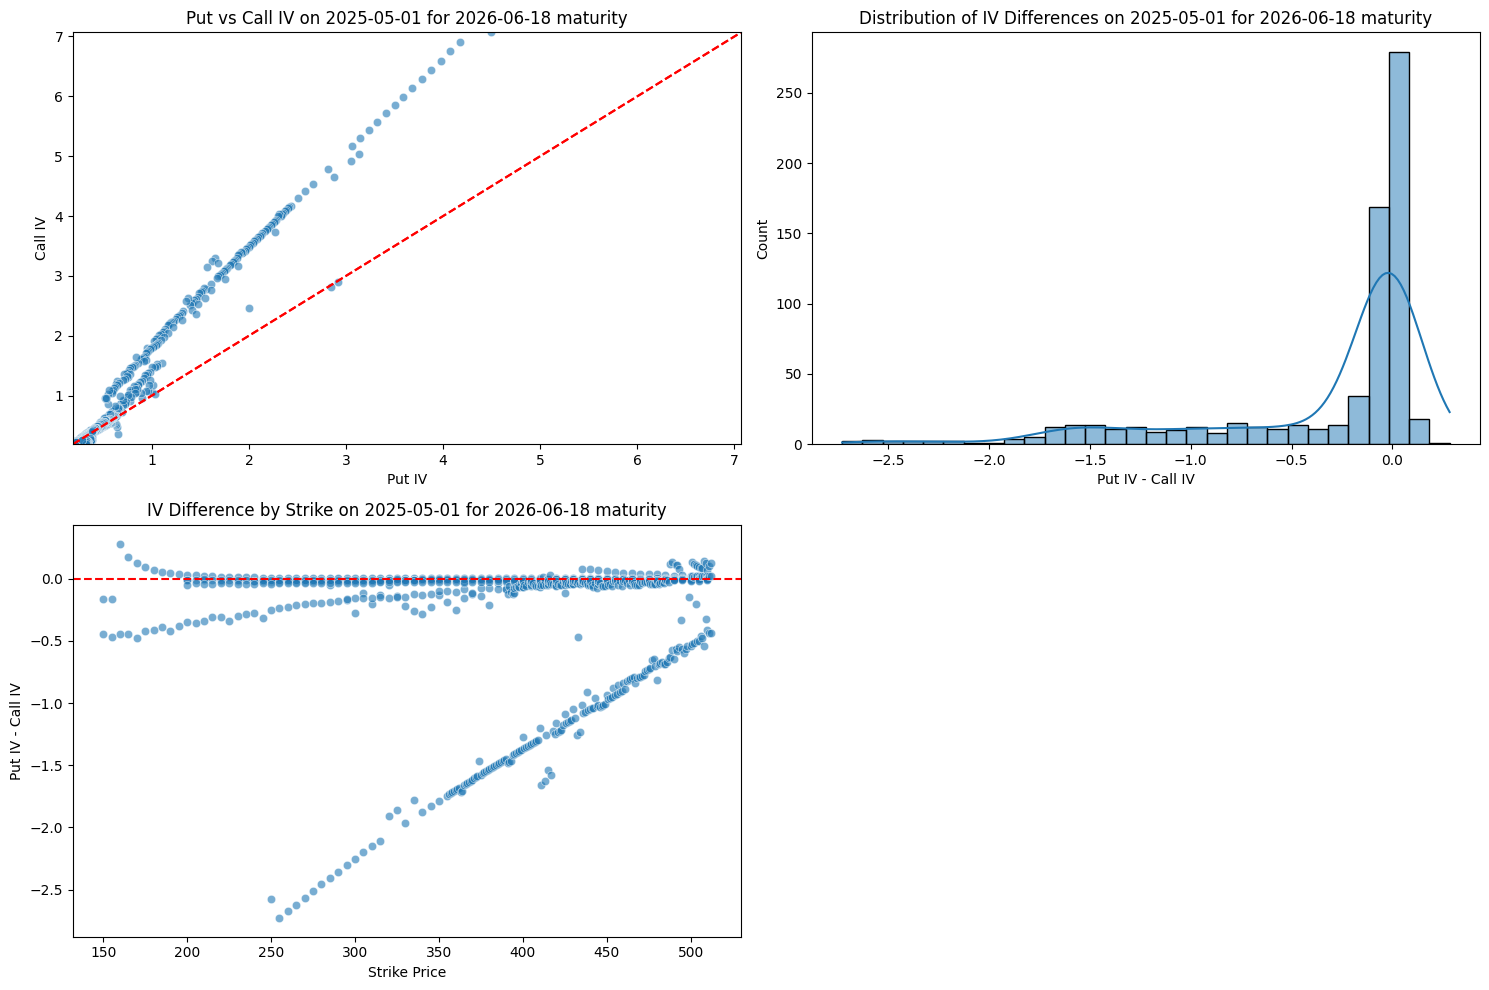


Comparison Statistics:
mean_abs_diff        0.346034
max_abs_diff         2.729300
mean_rel_diff      -17.176638
max_rel_diff        56.106002
num_comparisons    704.000000
min_strike         150.000000
max_strike         512.000000
dtype: float64


In [12]:
def compare_put_call_iv(ivs_data, underlying='SPY', snapshot_date=None, maturity=None):
    """
    Compare implied volatility between puts and calls for a given date and maturity.

    Parameters:
    - ivs_data: Dictionary containing the xarray DataArrays for each option type
    - underlying: 'SPY' or 'QQQ' (default 'SPY')
    - snapshot_date: Specific date to compare (string in 'YYYY-MM-DD' format)
                    If None, uses all available dates
    - maturity: Specific maturity to compare (string in format matching the data)
                If None, uses all available maturities

    Returns:
    - DataFrame with comparison results (only strikes that exist in both puts and calls)
    - Plots comparing put and call IVs
    """
    # Get the put and call DataArrays
    put_key = f"{underlying}_Put"
    call_key = f"{underlying}_Call"

    put_da = ivs_data.get(put_key)
    call_da = ivs_data.get(call_key)

    if put_da is None or call_da is None:
        raise ValueError(f"Data not found for {underlying} puts and calls")

    # Apply filters
    if snapshot_date is not None:
        put_data = put_da.sel(snapshot_date=snapshot_date)
        call_data = call_da.sel(snapshot_date=snapshot_date)
    else:
        put_data = put_da
        call_data = call_da

#    if maturity is not None:
        # Convert maturity format to match your data (YYYY-MM-DD to YYYY_MM_DD)
#        maturity_formatted = maturity.replace('-', '_')
#        put_data = put_data.sel(maturity=maturity_formatted)
#        call_data = call_data.sel(maturity=maturity_formatted)

    # Create DataFrames for comparison
    put_df = put_data.to_dataframe(name='put_iv').reset_index()
    call_df = call_data.to_dataframe(name='call_iv').reset_index()

    # Merge put and call data (inner join keeps only matching strikes)
    comparison_df = pd.merge(
        put_df,
        call_df,
        on=['strike', 'maturity', 'snapshot_date'],
        how='inner'
    ).dropna()

    if comparison_df.empty:
        print("Warning: No matching options found for the given filters")
        return pd.DataFrame(), {}
    # Omit IVs zero
    comparison_df = comparison_df[(comparison_df['put_iv'] != 0) & (comparison_df['call_iv'] != 0)]
    # Calculate differences
    comparison_df['iv_diff'] = comparison_df['put_iv'] - comparison_df['call_iv']
    comparison_df['abs_iv_diff'] = np.abs(comparison_df['iv_diff'])
    comparison_df['rel_iv_diff'] = (comparison_df['iv_diff'] /
                                   ((comparison_df['put_iv'] + comparison_df['call_iv'])/2)) * 100

    # Summary statistics
    stats = {
        'mean_abs_diff': comparison_df['abs_iv_diff'].mean(),
        'max_abs_diff': comparison_df['abs_iv_diff'].max(),
        'mean_rel_diff': comparison_df['rel_iv_diff'].mean(),
        'max_rel_diff': comparison_df['rel_iv_diff'].max(),
        'num_comparisons': len(comparison_df),
        'min_strike': comparison_df['strike'].min(),
        'max_strike': comparison_df['strike'].max()
    }

    # Plotting
    title_parts = []
    if snapshot_date:
        title_parts.append(f"on {snapshot_date}")
    if maturity:
        title_parts.append(f"for {maturity} maturity")
    title_suffix = " ".join(title_parts) if title_parts else "across all dates and maturities"

    plt.figure(figsize=(15, 10))

    # Scatter plot of put vs call IV
    plt.subplot(2, 2, 1)
    sns.scatterplot(data=comparison_df, x='put_iv', y='call_iv', alpha=0.6)
    lims = [min(comparison_df['put_iv'].min(), comparison_df['call_iv'].min()), max(comparison_df['put_iv'].max(), comparison_df['call_iv'].max())]
    plt.plot(lims, lims, 'r--')
    plt.xlim(lims)
    plt.ylim(lims)
    plt.plot([0, 1], [0, 1], 'r--', transform=plt.gca().transAxes)
    plt.xlabel('Put IV')
    plt.ylabel('Call IV')
    plt.title(f'Put vs Call IV {title_suffix}')

    # Distribution of IV differences
    plt.subplot(2, 2, 2)
    sns.histplot(data=comparison_df, x='iv_diff', bins=30, kde=True)
    plt.xlabel('Put IV - Call IV')
    plt.title(f'Distribution of IV Differences {title_suffix}')

    # IV difference by strike
    plt.subplot(2, 2, 3)
    if snapshot_date and maturity:
        sns.scatterplot(data=comparison_df, x='strike', y='iv_diff', alpha=0.6)
    else:
        sns.lineplot(data=comparison_df, x='strike', y='iv_diff', ci=95)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Strike Price')
    plt.ylabel('Put IV - Call IV')
    plt.title(f'IV Difference by Strike {title_suffix}')

    # IV difference by maturity (only shown if not filtering by maturity)
    plt.subplot(2, 2, 4)
    if not maturity:
        if snapshot_date:
            sns.boxplot(data=comparison_df, x='maturity', y='iv_diff')
        else:
            sns.boxplot(data=comparison_df, x='maturity', y='iv_diff')
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Maturity')
        plt.ylabel('Put IV - Call IV')
        plt.title(f'IV Difference by Maturity {title_suffix}')
        plt.xticks(rotation=45)
    else:
        plt.axis('off')  # Hide the subplot if we're filtering by maturity

    plt.tight_layout()
    plt.show()

    return comparison_df, stats

# Example usage:
# Compare for specific date and maturity
comparison_df, stats = compare_put_call_iv(ivs_data, underlying='SPY',
                                          snapshot_date='2025-05-01',
                                          maturity='2026-06-18')
print("\nComparison Statistics:")
print(pd.Series(stats))

### Computing theoretical spot price and forward price


In [13]:
def regress_spot_with_disc(Y, K):
    mask = np.isfinite(Y) & np.isfinite(K)
    if np.sum(mask) < 2:
        return np.nan, np.nan
    K = K[mask]
    Y = Y[mask]
    coeffs = np.polyfit(K, Y, 1)  # returns [slope, intercept]
    return coeffs[1], -coeffs[0]  # (spot, discount factor)

def regress_forward(K, Y):
    # K = m * (C - P) + b → we solve for intercept b
    mask = np.isfinite(Y) & np.isfinite(K)
    if np.sum(mask) < 2:
        return np.nan
    Y = Y[mask]
    K = K[mask]
    coeffs = np.polyfit(Y, K, 1)
    return coeffs[1]  # intercept → estimated forward price

# Prepare strike vector once (assumes all xarrays share the same strike coords)
strike_coords = premium_data['SPY_Call'].coords['strike'].values
K = xr.DataArray(strike_coords, dims='strike')

# Container for output
theo_spot = {}
theo_fwd = {}
theo_discfact = {}

# Process each ticker
for ticker in ['SPY', 'QQQ']:
    call = premium_data[f"{ticker}_Call"]
    put  = premium_data[f"{ticker}_Put"]

    # Intersect strike dimension
    common_strikes = np.intersect1d(call.coords['strike'], put.coords['strike'])
    call = call.sel(strike=common_strikes)
    put  = put.sel(strike=common_strikes)

    # Now subtract (no alignment error)
    y_diff = call - put  # shape: (snapshot_date, maturity, strike)

    # Regression
    K = xr.DataArray(common_strikes, dims='strike')
    spot_da, discfact_da = xr.apply_ufunc(
        regress_spot_with_disc,
        y_diff,
        K,
        input_core_dims=[['strike'], ['strike']],
        output_core_dims=[[], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float]
    )

    # Assign coords
    spot_da.name = 'theo_spot'
    spot_da = spot_da.assign_coords(
        snapshot_date=call.coords['snapshot_date'],
        maturity=call.coords['maturity']
    )
    theo_spot[ticker] = spot_da

    discfact_da.name = 'theo_discfact'
    discfact_da = discfact_da.assign_coords(
        snapshot_date=call.coords['snapshot_date'],
        maturity=call.coords['maturity']
    )
    theo_discfact[ticker] = discfact_da

    fwd_da = xr.apply_ufunc(
        regress_forward,
        K,  # Y
        y_diff,  # X
        input_core_dims=[['strike'], ['strike']],
        output_core_dims=[[]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float]
    )

    # Assign coords
    fwd_da.name = 'theo_fwd'
    fwd_da = fwd_da.assign_coords(
        snapshot_date=call.coords['snapshot_date'],
        maturity=call.coords['maturity']
    )
    theo_fwd[ticker] = fwd_da

In [14]:
theo_spot['SPY']

<xarray.DataArray 'theo_spot' (maturity: 9, snapshot_date: 15)> Size: 1kB
array([[507.47220487, 541.16029958, 525.67666733,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan],
       [509.09576727, 542.78828843, 526.25952   , 534.00392714,
        526.02583186, 527.75869203, 514.12910523, 527.5679256 ,
        547.56671979, 547.30411425, 547.30411425,          nan,
                 nan,          nan,          nan],
       [508.81343185, 542.55306859, 526.42444042, 535.05929072,
        526.36255499, 527.45836609, 514.24021923, 527.15618166,
        550.41888696, 550.75106757, 556.0195269 , 564.33203962,
        565.29403535, 587.34662448,          nan],
       [508.51487865, 542.53225496, 526.65422625, 534.57866796,
        526.87908182, 527.90153091, 514.45294428, 527.33808775,
        550.8202054 , 550.66674102, 556.78050758, 565.60793805,
        566.4569592 , 587.51387234, 595.70724711],
       [506.73248442, 540.29125598, 524.76080451, 532.52901254,
        523.43467327, 525.45710663, 511.48681229, 524.47916142,
        555.28622698, 548.18302666, 554.40032488, 569.8628789 ,
        570.9035408 , 584.83405355, 595.97775875],
       [506.38147516, 538.85221718, 523.55577284, 531.17251   ,
        521.79342532, 523.79733772, 510.31441649, 523.43648764,
        567.33641315, 546.44776329, 552.33312166, 581.57525707,
        582.66684372, 583.62417621, 598.89177781],
       [503.49643966, 532.40009096, 521.19021642, 529.46331834,
        520.63207327, 521.81200003, 507.96090611, 520.92782263,
        570.09131692, 543.43252993, 549.82256994, 584.40354177,
        585.54833556, 580.50699722, 594.67901987],
       [502.7675584 , 529.99822113, 520.42263664, 528.77475947,
        520.08584605, 521.48797859, 507.45829517, 520.3613012 ,
        567.86766091, 543.1877905 , 549.4847443 , 582.25512946,
        583.43632092, 580.07446024, 593.17707596],
       [499.33355158, 529.27853773, 517.59900602, 526.17875533,
        516.66413418, 517.95044931, 504.27093334, 517.19510073,
        575.67794256, 539.32536906, 545.58050355, 589.4684322 ,
        591.02125836, 576.6072834 , 590.99767918]])
Coordinates:
  * snapshot_date  (snapshot_date) object 120B '2025-04-07' ... '2025-05-19'
  * maturity       (maturity) <U10 360B '2025-04-11' ... '2027-12-17'

In [15]:
theo_fwd['SPY']

<xarray.DataArray 'theo_fwd' (maturity: 9, snapshot_date: 15)> Size: 1kB
array([[507.91403339, 543.34625678, 526.69798031,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan,          nan,
                 nan,          nan,          nan],
       [508.62897148, 543.932742  , 527.64222497, 535.40436676,
        527.29064457, 528.20851676, 514.01433399, 527.30334879,
        547.64144941, 547.7209492 , 547.7209492 ,          nan,
                 nan,          nan,          nan],
       [509.98246997, 545.54696237, 529.05597566, 536.71099364,
        528.77766086, 529.6860542 , 515.2688369 , 528.62644454,
        548.49886235, 551.42160775, 558.08174297, 563.45194668,
        564.75667332, 587.83529678,          nan],
       [511.79463596, 547.63386092, 530.6412419 , 538.42430933,
        530.66235151, 531.50111917, 517.077303  , 530.43177072,
        549.04635652, 553.5818644 , 559.82876062, 564.57164959,
        565.57721661, 589.74739084, 595.62970256],
       [518.6012555 , 555.49736972, 538.29902223, 546.61556677,
        538.28991568, 539.52823209, 524.534478  , 538.43469376,
        552.56403224, 561.91351947, 568.43710027, 567.75911954,
        569.03788931, 600.06919278, 602.66607938],
       [524.13770164, 562.95784983, 545.2684402 , 553.81776726,
        544.79773772, 546.2922458 , 530.98150849, 545.36160578,
        557.07494926, 569.20603543, 575.78994313, 572.17111472,
        573.49534985, 609.50975496, 610.55104454],
       [530.36438221, 572.77131421, 551.86214599, 560.95843583,
        551.81486553, 553.2070024 , 537.03471443, 551.90057294,
        559.83896179, 575.75977096, 582.60938951, 575.38359636,
        576.67041559, 618.1286944 , 619.02042493],
       [530.76267755, 573.55545139, 552.24737897, 561.48551382,
        552.15164688, 553.4389648 , 537.33207003, 552.24221251,
        559.72559358, 575.93649194, 582.8110182 , 575.3770429 ,
        576.64396393, 618.54241616, 619.80270293],
       [542.70344845, 587.98649849, 565.54408192, 575.85629748,
        565.53040184, 567.08747628, 549.8444772 , 565.58256314,
        567.45057734, 590.03645581, 597.26039874, 583.68384956,
        585.14768258, 636.32765476, 635.80498599]])
Coordinates:
  * snapshot_date  (snapshot_date) object 120B '2025-04-07' ... '2025-05-19'
  * maturity       (maturity) <U10 360B '2025-04-11' ... '2027-12-17'

In [16]:
theo_discfact['SPY']

<xarray.DataArray 'theo_discfact' (maturity: 9, snapshot_date: 15)> Size: 1kB
array([[0.99912922, 0.99597236, 0.99806061,        nan,        nan,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan,        nan,        nan],
       [1.00091756, 0.9978907 , 0.99737941, 0.99738425, 0.9976011 ,
        0.99914799, 1.00022288, 1.00050143, 0.99986342, 0.99923879,
        0.99923879,        nan,        nan,        nan,        nan],
       [0.99770678, 0.99450549, 0.9950257 , 0.99692243, 0.99543255,
        0.99579389, 0.99800356, 0.99721844, 1.00349982, 0.9987835 ,
        0.99630122, 1.00156172, 1.00095145, 0.99916828,        nan],
       [0.99358926, 0.99068056, 0.99248621, 0.99285745, 0.99286999,
        0.99322714, 0.99492382, 0.9941671 , 1.00322819, 0.99473359,
        0.99455484, 1.00183369, 1.0015535 , 0.99621266, 1.00012708],
       [0.97710682, 0.9726201 , 0.97484722, 0.97422792, 0.97240229,
        0.9739188 , 0.97512421, 0.9740809 , 1.00489188, 0.97556417,
        0.97530609, 1.00366449, 1.00323853, 0.97461091, 0.98882932],
       [0.96611058, 0.95717345, 0.9601754 , 0.95910767, 0.95777385,
        0.9588215 , 0.96107547, 0.95979447, 1.01842086, 0.96001689,
        0.95926042, 1.01641423, 1.01596871, 0.95752954, 0.98077358],
       [0.94932205, 0.92937451, 0.94441239, 0.94384486, 0.94348626,
        0.94324496, 0.94585587, 0.94387557, 1.01832405, 0.94385079,
        0.94372221, 1.01565015, 1.01536559, 0.93913448, 0.96054502],
       [0.94723939, 0.92394201, 0.94236297, 0.94173456, 0.94192257,
        0.94226526, 0.94439895, 0.94226613, 1.01453532, 0.94313686,
        0.94281663, 1.0119029 , 1.01172518, 0.9378072 , 0.9569207 ],
       [0.92005269, 0.90000035, 0.91520374, 0.91370972, 0.91358151,
        0.91334332, 0.91710033, 0.91443467, 1.01444916, 0.91404844,
        0.91346688, 1.0097736 , 1.00989027, 0.90614209, 0.92939616]])
Coordinates:
  * snapshot_date  (snapshot_date) object 120B '2025-04-07' ... '2025-05-19'
  * maturity       (maturity) <U10 360B '2025-04-11' ... '2027-12-17'

In [17]:
theo_ir = {}

for ticker, disc_da in theo_discfact.items():
    snap_dates = pd.to_datetime(disc_da.coords['snapshot_date'].values)
    maturities = pd.to_datetime(disc_da.coords['maturity'].values)

    # Compute T matrix (time to maturity in years)
    T = (maturities.values[None, :] - snap_dates.values[:, None]).astype('timedelta64[D]').astype(float) / 365.0

    # Create DataArray with proper dims and coords
    T_da = xr.DataArray(
        T,
        dims=('snapshot_date', 'maturity'),
        coords={
            'snapshot_date': disc_da.coords['snapshot_date'],
            'maturity': disc_da.coords['maturity']
        }
    )

    # Compute interest rate from discount factor (semiannual compounding)
    r_da = 2 * ((disc_da ** (-1 / (2 * T_da))) - 1)

    # Clean up (e.g., remove invalid values when T <= 0)
    r_da = r_da.where(T_da > 0)

    r_da.name = 'theo_ir'
    theo_ir[ticker] = r_da

In [18]:
theo_ir['SPY']

<xarray.DataArray 'theo_ir' (maturity: 9, snapshot_date: 15)> Size: 1kB
array([[ 0.08109457,  0.89044656,  0.85031541,         nan,         nan,
                nan,         nan,         nan,         nan,         nan,
                nan,         nan,         nan,         nan,         nan],
       [-0.01851127,  0.04875389,  0.06488153,  0.06946488,  0.09981664,
         0.03926993, -0.02023247, -0.06007176,  0.05048341,         nan,
                nan,         nan,         nan,         nan,         nan],
       [ 0.0216027 ,  0.05509731,  0.05120422,  0.03240381,  0.05648074,
         0.05376042,  0.02939101,  0.04281367, -0.05713196,  0.02483597,
         0.092234  , -0.05111586, -0.04897816,  0.15776609,         nan],
       [ 0.03197522,  0.04803364,  0.03915138,  0.03772839,  0.04058753,
         0.03913586,  0.03119956,  0.03651997, -0.0205323 ,  0.03669715,
         0.04025814, -0.01448388, -0.01344476,  0.03778499, -0.00144894],
       [ 0.03329419,  0.04029435,  0.03709153,  0.03817787,  0.04178589,
         0.03959822,  0.03835699,  0.04017087, -0.00743878,  0.03879642,
         0.03972748, -0.00584711, -0.00526161,  0.04332418,  0.01925208],
       [ 0.02900487,  0.0370664 ,  0.03447193,  0.03550655,  0.03713353,
         0.03626963,  0.03455361,  0.03581013, -0.0158002 ,  0.03612431,
         0.03709855, -0.01447682, -0.01422702,  0.03999599,  0.01801989],
       [ 0.03085268,  0.04372991,  0.0341212 ,  0.03453936,  0.03505543,
         0.03526914,  0.03381025,  0.03515287, -0.01096113,  0.03552437,
         0.0357897 , -0.00955156, -0.00944326,  0.03970416,  0.02558241],
       [ 0.03076549,  0.04519927,  0.03387774,  0.03431531,  0.03447013,
         0.03431294,  0.03320705,  0.03458576, -0.00832999,  0.03437259,
         0.03474135, -0.00695386, -0.00689522,  0.0387286 ,  0.02669922],
       [ 0.03114797,  0.03954727,  0.03324176,  0.03389468,  0.0341234 ,
         0.03425812,  0.03282996,  0.03397889, -0.00540757,  0.03435526,
         0.03470971, -0.00370999, -0.00376978,  0.03835048,  0.02857306]])
Coordinates:
  * snapshot_date  (snapshot_date) object 120B '2025-04-07' ... '2025-05-19'
  * maturity       (maturity) <U10 360B '2025-04-11' ... '2027-12-17'

### Forwards data

In [19]:
# Load CSV file
forwards_data = pd.read_csv('futures_prices_multiple_dates_2025.csv')

In [20]:
unique_tickers = forwards_data['Ticker'].unique()

# Create the Underlying column
forwards_data['Underlying'] = np.where(
    forwards_data['Ticker'].str.startswith('NQ'),
    'QQQ',
    np.where(forwards_data['Ticker'].str.startswith('ES'), 'SPY', 'Unknown')
)

# Month code mapping
month_codes = {
    'F': '01', 'G': '02', 'H': '03', 'J': '04', 'K': '05', 'M': '06',
    'N': '07', 'Q': '08', 'U': '09', 'V': '10', 'X': '11', 'Z': '12'
}

# Extract components
def extract_maturity(ticker):
    # Example ticker: 'NQM25.CME'
    month_code = ticker[2]    # e.g., 'M'
    year_code = ticker[3:5]   # e.g., '25'
    year_full = '20' + year_code
    month_full = month_codes.get(month_code, '01')  # Default to '01' if unknown
    return f'{year_full}-{month_full}'

# Apply to create the Maturity column
forwards_data['Maturity'] = forwards_data['Ticker'].apply(extract_maturity)

In [21]:
forwards_data.tail()

Ticker Target Date Available Date     Open     High      Low    Close  \
835  ESZ27.CME  2025-05-13            NaN  No data  No data  No data   6386.5   
836  ESZ27.CME  2025-05-14            NaN  No data  No data  No data  6400.75   
837  ESZ27.CME  2025-05-15            NaN  No data  No data  No data  6415.25   
838  ESZ27.CME  2025-05-16            NaN  No data  No data  No data  6470.25   
839  ESZ27.CME  2025-05-19            NaN  No data  No data  No data  6477.75   

    Adj Close   Volume Underlying Maturity  
835    6386.5  No data        SPY  2027-12  
836   6400.75  No data        SPY  2027-12  
837   6415.25  No data        SPY  2027-12  
838   6470.25  No data        SPY  2027-12  
839   6477.75  No data        SPY  2027-12

In [22]:
# data_fwd = {}

# for ticker in ['SPY', 'QQQ']:
#     df = forwards_data[forwards_data['Underlying'] == ticker].copy()

#     # Parse dates
#     df['Target Date'] = pd.to_datetime(df['Target Date'])
#     df['Maturity'] = pd.to_datetime(df['Maturity'], format='%Y-%m')  # interprets as yyyy-mm-01

#     df['Close'] = pd.to_numeric(df['Close'], errors='coerce') / 10.0

#     # Pivot: snapshot_date × maturity
#     df_pivot = df.pivot(index='Target Date', columns='Maturity', values='Close')

#     # Strip index/column names to avoid xarray confusion
#     df_pivot.index.name = None
#     df_pivot.columns.name = None

#     # Convert to xarray DataArray
#     da = xr.DataArray(
#         df_pivot.values,
#         dims=('snapshot_date', 'maturity'),
#         coords={
#             'snapshot_date': df_pivot.index.strftime('%Y-%m-%d').to_numpy(),
#             'maturity': df_pivot.columns.strftime('%Y-%m').to_numpy()
#         },
#         name='data_fwd'
#     )

#     data_fwd[ticker] = da

In [23]:
#added an if clause for QQQ

data_fwd = {}

for ticker in ['SPY', 'QQQ']:
    df = forwards_data[forwards_data['Underlying'] == ticker].copy()

    # Parse dates
    df['Target Date'] = pd.to_datetime(df['Target Date'])
    df['Maturity'] = pd.to_datetime(df['Maturity'], format='%Y-%m')  # interprets as yyyy-mm-01

    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

    # Apply division based on ticker
    if ticker == 'SPY':
      df['Close'] = df['Close'] / 10.0
    elif ticker == 'QQQ':
      df['Close'] = df['Close'] / 40.0


    # Pivot: snapshot_date × maturity
    df_pivot = df.pivot(index='Target Date', columns='Maturity', values='Close')

    # Strip index/column names to avoid xarray confusion
    df_pivot.index.name = None
    df_pivot.columns.name = None

    # Convert to xarray DataArray
    da = xr.DataArray(
        df_pivot.values,
        dims=('snapshot_date', 'maturity'),
        coords={
            'snapshot_date': df_pivot.index.strftime('%Y-%m-%d').to_numpy(),
            'maturity': df_pivot.columns.strftime('%Y-%m').to_numpy()
        },
        name='data_fwd'
    )

    data_fwd[ticker] = da


In [24]:
data_fwd['SPY']

<xarray.DataArray 'data_fwd' (snapshot_date: 35, maturity: 12)> Size: 3kB
array([[    nan, 567.45 , 572.175, 576.5  , 580.8  , 584.85 , 588.8  ,
        592.75 , 597.025, 601.35 , 605.55 , 609.85 ],
       [    nan, 571.225, 576.05 , 580.5  , 585.   , 589.1  , 593.15 ,
        597.125, 601.5  , 605.85 , 610.2  , 614.55 ],
       [    nan, 543.275, 547.65 , 551.6  , 555.4  , 558.9  , 562.4  ,
        565.8  , 569.3  , 573.1  , 576.8  , 580.5  ],
       [    nan, 511.025, 514.925, 518.8  , 522.4  , 525.6  , 528.9  ,
        532.   , 535.4  , 538.8  , 542.2  , 545.6  ],
       [    nan, 509.725, 513.7  , 517.4  , 521.15 , 524.35 , 527.65 ,
        530.75 , 534.15 , 537.55 , 540.95 , 545.85 ],
       [    nan, 502.025, 505.8  , 509.375, 513.45 , 516.65 , 519.95 ,
        521.05 , 524.45 , 527.85 , 531.25 , 534.15 ],
       [    nan, 549.1  , 553.6  , 557.25 , 561.325, 565.525, 568.825,
        570.925, 574.325, 578.725, 582.125, 589.025],
       [    nan, 530.2  , 534.475, 538.425, 542.4  , 546.6  , 549.9  ,
        551.7  , 555.1  , 559.5  , 562.9  , 569.2  ],
       [    nan, 539.125, 543.525, 547.575, 551.55 , 556.25 , 560.05 ,
        563.35 , 567.25 , 571.65 , 575.05 , 581.35 ],
       [    nan, 544.075, 548.55 , 552.575, 556.65 , 561.35 , 565.15 ,
        568.45 , 572.35 , 576.75 , 580.15 , 588.45 ],
...
       [    nan, 562.575, 567.275, 571.65 , 576.225, 579.9  , 583.925,
        587.525, 591.425, 595.425, 599.625, 603.625],
       [    nan, 565.2  , 569.975, 574.35 , 578.925, 582.6  , 586.625,
        590.225, 594.125, 598.125, 602.325, 606.325],
       [    nan, 568.45 , 573.275, 577.75 , 582.3  , 586.4  , 590.425,
        594.425, 598.475, 602.475, 606.675, 611.775],
       [    nan, 567.8  , 572.625, 577.175, 581.875, 585.975, 590.   ,
        594.   , 598.05 , 602.05 , 606.25 , 611.35 ],
       [    nan, 586.5  , 591.625, 596.5  , 601.7  , 606.65 , 610.85 ,
        614.925, 619.125, 623.125, 627.325, 633.575],
       [    nan, 590.45 , 595.675, 600.8  , 605.725, 610.675, 614.875,
        619.35 , 624.   , 628.   , 632.2  , 638.65 ],
       [    nan, 590.85 , 596.125, 601.25 , 606.25 , 611.2  , 615.4  ,
        619.875, 625.425, 629.425, 633.625, 640.075],
       [    nan, 593.325, 598.675, 603.725, 609.05 , 613.65 , 617.85 ,
        622.325, 626.875, 630.875, 635.075, 641.525],
       [    nan, 597.55 , 603.025, 608.2  , 613.5  , 618.1  , 622.85 ,
        627.325, 631.875, 636.375, 640.575, 647.025],
       [    nan, 598.25 , 603.7  , 608.925, 614.25 , 618.85 , 623.6  ,
        628.075, 632.625, 637.125, 641.325, 647.775]])
Coordinates:
  * snapshot_date  (snapshot_date) object 280B '2025-04-01' ... '2025-05-19'
  * maturity       (maturity) object 96B '2025-03' '2025-06' ... '2027-12'

Plots for FWD Price vs. Market

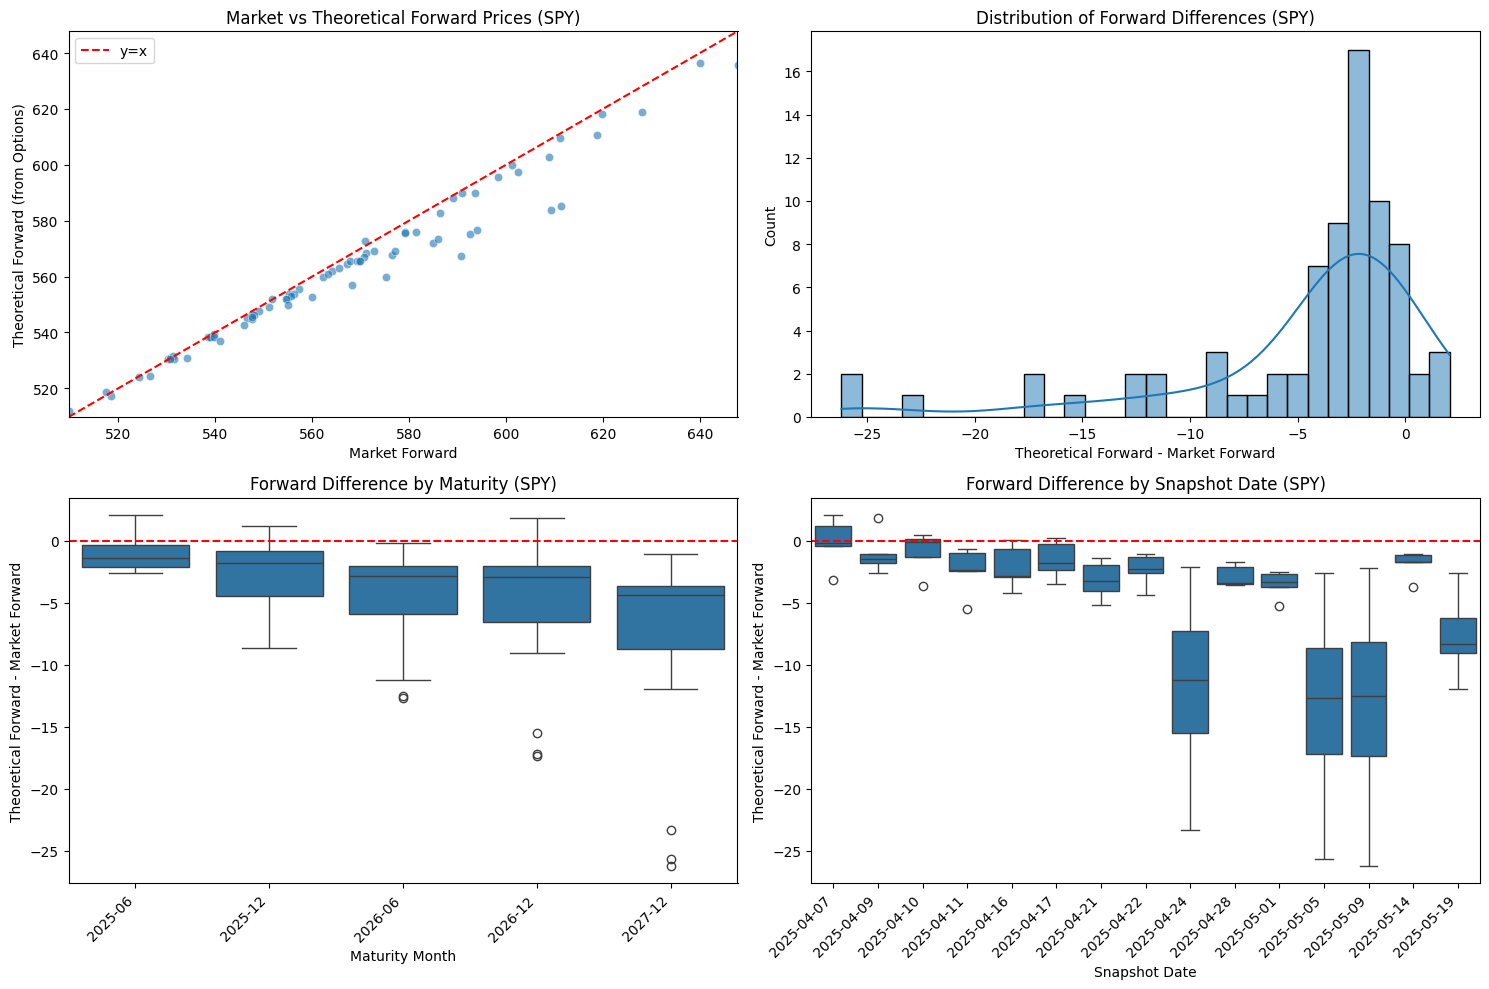

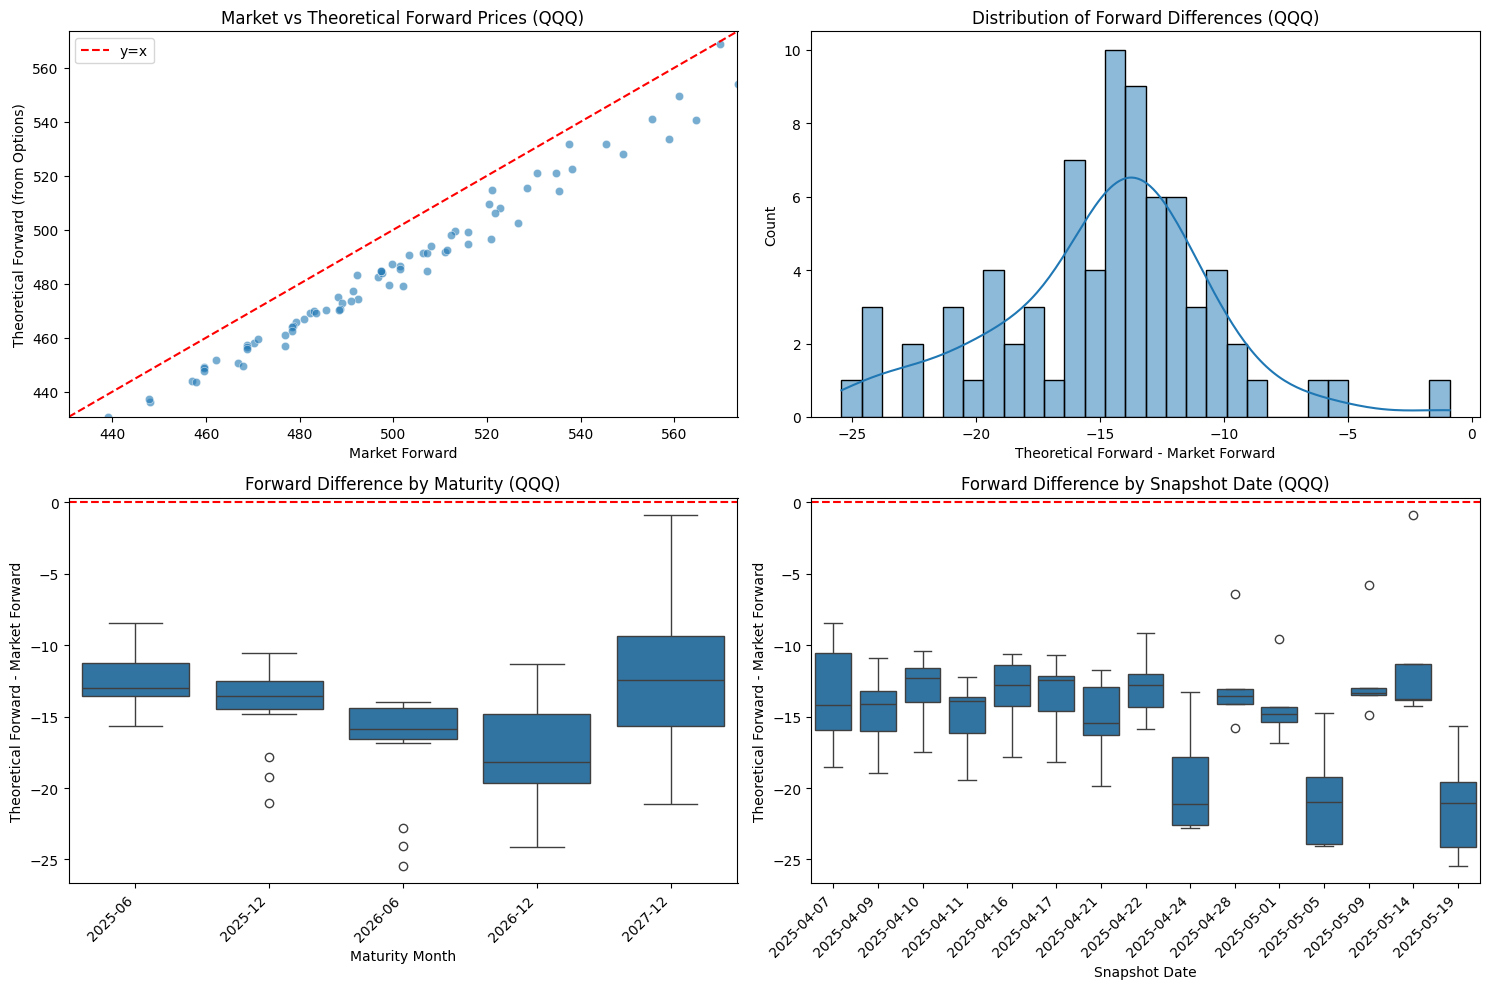


SPY Forward Comparison Summary:
        fwd_diff  abs_fwd_diff  rel_fwd_diff_pct
count  75.000000     75.000000         75.000000
mean   -4.531912      4.692821         -0.772651
std     5.873526      5.744033          0.978297
min   -26.202317      0.087352         -4.285977
25%    -4.786480      1.431918         -0.822077
50%    -2.603350      2.603350         -0.453941
75%    -1.310933      4.786480         -0.241338
max     2.069636     26.202317          0.406030

QQQ Forward Comparison Summary:
        fwd_diff  abs_fwd_diff  rel_fwd_diff_pct
count  75.000000     75.000000         75.000000
mean  -14.830536     14.830536         -2.964068
std     4.387433      4.387433          0.813677
min   -25.439794      0.902078         -4.616214
25%   -17.151327     12.364826         -3.451623
50%   -14.167989     14.167989         -2.872384
75%   -12.364826     17.151327         -2.570482
max    -0.902078     25.439794         -0.158320


In [25]:
def compare_forwards(theo_fwd, data_fwd, underlying='SPY'):
    """
    Compares theoretical forwards (from options data) with market forwards.

    Parameters:
    - theo_fwd: Dictionary containing the xarray DataArray for theoretical forwards.
    - data_fwd: Dictionary containing the xarray DataArray for market forwards.
    - underlying: 'SPY' or 'QQQ' (default 'SPY')

    Returns:
    - DataFrame with comparison results (matched snapshot_date and maturity).
    - Plots comparing theoretical and market forwards.
    """
    theo_da = theo_fwd.get(underlying)
    data_da = data_fwd.get(underlying)

    if theo_da is None or data_da is None:
        raise ValueError(f"Forward data not found for {underlying}")

    # Convert xarray DataArrays to DataFrames for easier merging
    theo_df = theo_da.to_dataframe(name='theo_fwd').reset_index()
    data_df = data_da.to_dataframe(name='market_fwd').reset_index()

    # Convert maturity columns to a comparable format (e.g., YYYY-MM)
    # Assuming theo_fwd maturity is already YYYY-MM-DD, data_fwd is YYYY-MM
    # Align data_fwd maturity to YYYY-MM-DD (first day of the month)
    # Assuming theo_fwd maturity is YYYY-MM-DD, data_fwd is YYYY-MM
    # Convert data_fwd maturity to YYYY-MM-DD format (end of the month)
    # You might need to adjust this based on the exact maturity logic of your market data
    # For now, let's assume we want to match YYYY-MM part.

    # Convert theo_fwd maturity to YYYY-MM string for matching
    theo_df['maturity_month'] = pd.to_datetime(theo_df['maturity']).dt.strftime('%Y-%m')

    # Convert data_fwd maturity (already YYYY-MM)
    data_df['maturity_month'] = pd.to_datetime(data_df['maturity']).dt.strftime('%Y-%m')

    # Convert snapshot dates to string for merging
    theo_df['snapshot_date_str'] = pd.to_datetime(theo_df['snapshot_date']).dt.strftime('%Y-%m-%d')
    data_df['snapshot_date_str'] = pd.to_datetime(data_df['snapshot_date']).dt.strftime('%Y-%m-%d')


    # Merge dataframes based on snapshot date and the extracted month part of maturity
    # Use inner join to keep only matching pairs
    comparison_df = pd.merge(
        theo_df[['snapshot_date_str', 'maturity_month', 'theo_fwd']],
        data_df[['snapshot_date_str', 'maturity_month', 'market_fwd']],
        on=['snapshot_date_str', 'maturity_month'],
        how='inner'
    )

    # Drop rows where either forward price is NaN or 0 (omit nas)
    comparison_df = comparison_df.dropna(subset=['theo_fwd', 'market_fwd'])
    comparison_df = comparison_df[(comparison_df['theo_fwd'] != 0) & (comparison_df['market_fwd'] != 0)]

    if comparison_df.empty:
        print("Warning: No matching forward data found for comparison after filtering.")
        return pd.DataFrame()

    # Calculate differences
    comparison_df['fwd_diff'] = comparison_df['theo_fwd'] - comparison_df['market_fwd']
    comparison_df['abs_fwd_diff'] = np.abs(comparison_df['fwd_diff'])
    comparison_df['rel_fwd_diff_pct'] = (comparison_df['fwd_diff'] / comparison_df['market_fwd']) * 100

    # Plotting
    plt.figure(figsize=(15, 10))

    # Scatter plot of theoretical vs market forwards
    plt.subplot(2, 2, 1)
    sns.scatterplot(data=comparison_df, x='market_fwd', y='theo_fwd', alpha=0.6)
    lims = [
        min(comparison_df['market_fwd'].min(), comparison_df['theo_fwd'].min()),
        max(comparison_df['market_fwd'].max(), comparison_df['theo_fwd'].max())
    ]
    plt.plot(lims, lims, 'r--', label='y=x') # Add a y=x line for reference
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('Market Forward')
    plt.ylabel('Theoretical Forward (from Options)')
    plt.title(f'Market vs Theoretical Forward Prices ({underlying})')
    plt.legend()

    # Distribution of forward differences
    plt.subplot(2, 2, 2)
    sns.histplot(data=comparison_df, x='fwd_diff', bins=30, kde=True)
    plt.xlabel('Theoretical Forward - Market Forward')
    plt.title(f'Distribution of Forward Differences ({underlying})')

    # Forward difference by maturity
    plt.subplot(2, 2, 3)
    sns.boxplot(data=comparison_df, x='maturity_month', y='fwd_diff')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Maturity Month')
    plt.ylabel('Theoretical Forward - Market Forward')
    plt.title(f'Forward Difference by Maturity ({underlying})')
    plt.xticks(rotation=45, ha='right')

    # Forward difference by snapshot date
    plt.subplot(2, 2, 4)
    sns.boxplot(data=comparison_df, x='snapshot_date_str', y='fwd_diff')
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Snapshot Date')
    plt.ylabel('Theoretical Forward - Market Forward')
    plt.title(f'Forward Difference by Snapshot Date ({underlying})')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    return comparison_df

# Example usage:
comparison_fwd_spy = compare_forwards(theo_fwd, data_fwd, underlying='SPY')
comparison_fwd_qqq = compare_forwards(theo_fwd, data_fwd, underlying='QQQ')

print("\nSPY Forward Comparison Summary:")
if not comparison_fwd_spy.empty:
    print(comparison_fwd_spy[['fwd_diff', 'abs_fwd_diff', 'rel_fwd_diff_pct']].describe())

print("\nQQQ Forward Comparison Summary:")
if not comparison_fwd_qqq.empty:
    print(comparison_fwd_qqq[['fwd_diff', 'abs_fwd_diff', 'rel_fwd_diff_pct']].describe())

Scatter plot saved to spy_forward_scatter_plot.png


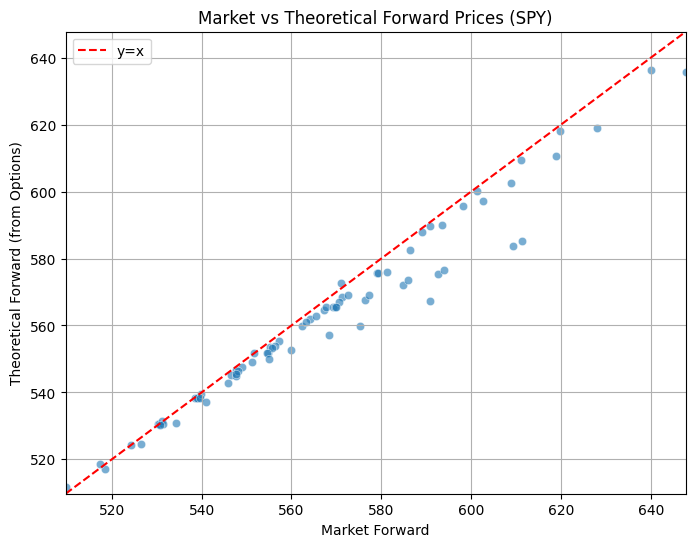

Scatter plot saved to qqq_forward_scatter_plot.png


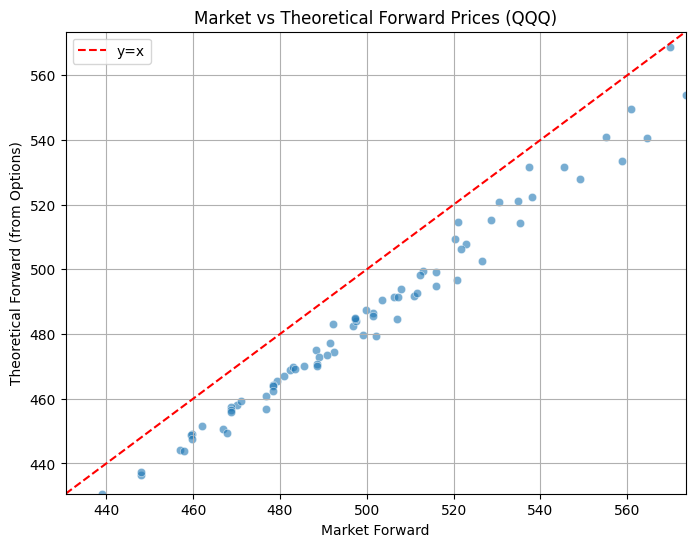

snapshot_date_str maturity_month    theo_fwd  market_fwd   fwd_diff  \
0         2025-04-07        2025-06  430.623591   439.08125  -8.457659   
1         2025-04-09        2025-06  468.977691   482.21875 -13.241059   
2         2025-04-10        2025-06  451.684343   462.11250 -10.428157   
3         2025-04-11        2025-06  457.979997   470.18750 -12.207503   
4         2025-04-16        2025-06  449.027661   459.63125 -10.603589   
..               ...            ...         ...         ...        ...   
70        2025-05-01        2027-12  520.968809   530.55000  -9.581191   
71        2025-05-05        2027-12  514.377329   535.35000 -20.972671   
72        2025-05-09        2027-12  531.649257   537.44500  -5.795743   
73        2025-05-14        2027-12  568.880422   569.78250  -0.902078   
74        2025-05-19        2027-12  553.870132   573.46250 -19.592368   

    abs_fwd_diff  rel_fwd_diff_pct  
0       8.457659         -1.926217  
1      13.241059         -2.745861  
2      10.428157         -2.256627  
3      12.207503         -2.596305  
4      10.603589         -2.306977  
..           ...               ...  
70      9.581191         -1.805898  
71     20.972671         -3.917563  
72      5.795743         -1.078388  
73      0.902078         -0.158320  
74     19.592368         -3.416504  

[75 rows x 7 columns]

In [26]:


def compare_forwards_and_save(theo_fwd, data_fwd, underlying='SPY', filename=None):
    """
    Compares theoretical forwards (from options data) with market forwards
    and saves the scatter plot to a file.

    Parameters:
    - theo_fwd: Dictionary containing the xarray DataArray for theoretical forwards.
    - data_fwd: Dictionary containing the xarray DataArray for market forwards.
    - underlying: 'SPY' or 'QQQ' (default 'SPY')
    - filename (str, optional): The name of the file to save the scatter plot to.
                                If None, the plot is displayed but not saved.
    """
    theo_da = theo_fwd.get(underlying)
    data_da = data_fwd.get(underlying)

    if theo_da is None or data_da is None:
        raise ValueError(f"Forward data not found for {underlying}")

    # Convert xarray DataArrays to DataFrames for easier merging
    theo_df = theo_da.to_dataframe(name='theo_fwd').reset_index()
    data_df = data_da.to_dataframe(name='market_fwd').reset_index()

    # Convert maturity columns to a comparable format (e.g., YYYY-MM)
    theo_df['maturity_month'] = pd.to_datetime(theo_df['maturity']).dt.strftime('%Y-%m')
    data_df['maturity_month'] = pd.to_datetime(data_df['maturity']).dt.strftime('%Y-%m')

    # Convert snapshot dates to string for merging
    theo_df['snapshot_date_str'] = pd.to_datetime(theo_df['snapshot_date']).dt.strftime('%Y-%m-%d')
    data_df['snapshot_date_str'] = pd.to_datetime(data_df['snapshot_date']).dt.strftime('%Y-%m-%d')

    # Merge dataframes based on snapshot date and the extracted month part of maturity
    comparison_df = pd.merge(
        theo_df[['snapshot_date_str', 'maturity_month', 'theo_fwd']],
        data_df[['snapshot_date_str', 'maturity_month', 'market_fwd']],
        on=['snapshot_date_str', 'maturity_month'],
        how='inner'
    )

    # Drop rows where either forward price is NaN or 0
    comparison_df = comparison_df.dropna(subset=['theo_fwd', 'market_fwd'])
    comparison_df = comparison_df[(comparison_df['theo_fwd'] != 0) & (comparison_df['market_fwd'] != 0)]

    if comparison_df.empty:
        print("Warning: No matching forward data found for comparison after filtering.")
        return pd.DataFrame()

    # Calculate differences
    comparison_df['fwd_diff'] = comparison_df['theo_fwd'] - comparison_df['market_fwd']
    comparison_df['abs_fwd_diff'] = np.abs(comparison_df['fwd_diff'])
    comparison_df['rel_fwd_diff_pct'] = (comparison_df['fwd_diff'] / comparison_df['market_fwd']) * 100

    # Plotting the scatter plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=comparison_df, x='market_fwd', y='theo_fwd', alpha=0.6)
    lims = [
        min(comparison_df['market_fwd'].min(), comparison_df['theo_fwd'].min()),
        max(comparison_df['market_fwd'].max(), comparison_df['theo_fwd'].max())
    ]
    plt.plot(lims, lims, 'r--', label='y=x') # Add a y=x line for reference
    plt.xlim(lims)
    plt.ylim(lims)
    plt.xlabel('Market Forward')
    plt.ylabel('Theoretical Forward (from Options)')
    plt.title(f'Market vs Theoretical Forward Prices ({underlying})')
    plt.legend()
    plt.grid(True)

    # Save the plot if filename is provided
    if filename:
        try:
            plt.savefig(filename)
            print(f"Scatter plot saved to {filename}")
        except Exception as e:
            print(f"Error saving plot to {filename}: {e}")

    plt.show() # Always show the plot

    return comparison_df

# Example usage:
# Compare for SPY and save the scatter plot
compare_forwards_and_save(theo_fwd, data_fwd, underlying='SPY', filename='spy_forward_scatter_plot.png')

# Compare for QQQ and save the scatter plot
compare_forwards_and_save(theo_fwd, data_fwd, underlying='QQQ', filename='qqq_forward_scatter_plot.png')


### Spot data

In [27]:
# Load CSV file
spot_data = pd.read_csv('spy_qqq_close_prices.csv')
spot_data

Date         QQQ         SPY
0   2025-04-01  472.700012  560.969971
1   2025-04-02  476.149994  564.520020
2   2025-04-03  450.660004  536.700012
3   2025-04-04  422.670013  505.279999
4   2025-04-07  423.690002  504.380005
5   2025-04-08  416.059998  496.480011
6   2025-04-09  466.000000  548.619995
7   2025-04-10  446.179993  524.580017
8   2025-04-11  454.399994  533.940002
9   2025-04-14  457.480011  539.119995
10  2025-04-15  457.989990  537.609985
11  2025-04-16  444.179993  525.659973
12  2025-04-17  444.100006  526.409973
13  2025-04-21  433.109985  513.880005
14  2025-04-22  444.480011  527.250000
15  2025-04-23  454.559998  535.419983
16  2025-04-24  467.350006  546.690002
17  2025-04-25  472.559998  550.640015
18  2025-04-28  472.410004  550.849976
19  2025-04-29  475.529999  554.320007
20  2025-04-30  475.470001  554.539978
21  2025-05-01  481.679993  558.469971
22  2025-05-02  488.829987  566.760010
23  2025-05-05  485.929993  563.510010
24  2025-05-06  481.410004  558.799988
25  2025-05-07  483.299988  561.150024
26  2025-05-08  488.290009  565.059998
27  2025-05-09  487.970001  564.340027
28  2025-05-12  507.850006  582.989990
29  2025-05-13  515.590027  586.840027
30  2025-05-14  518.679993  587.590027
31  2025-05-15  519.250000  590.460022
32  2025-05-16  521.510010  594.200012

## Calibrated models

In [28]:
def SABR_calibration(K, alpha, rho, sigma0, T, F):
    epsilon = 1e-8
    z = (alpha * np.log(F / K)) / sigma0
    x = np.log((np.sqrt(1 - 2 * rho * z + z ** 2) + z - rho) / (1 - rho))
    atm_mask = np.isclose(F, K)
    safe_x = np.where(np.abs(x) < epsilon, epsilon, x)
    vol_factor = 1 + 0.25 * T * (alpha * rho * sigma0 + ((alpha ** 2) / 2) * ((2 / 3) - rho ** 2))
    vol = np.where(atm_mask, sigma0, sigma0 * (z / safe_x) * vol_factor)
    return vol

In [29]:
def RawSVI_calibration(K, a, b, rho, m, sigma, T, F, epsilon=1e-8):
    logk = np.log(K / F)
    sqrt_inner = np.sqrt(np.maximum(sigma**2 + (logk - m)**2, epsilon))
    svi_inner = rho * (logk - m) + sqrt_inner
    svi_outer = np.maximum(a + b * svi_inner, epsilon)
    vol = np.sqrt(svi_outer)
    return vol

In [30]:
def NaturalSVI_calibration(K, delta, mu, rho, omega, ksi, T, F, epsilon=1e-8):
    logk = np.log(K / F)
    inner_sqrt_arg = (ksi * (logk - mu) + rho) ** 2 + 1 - rho ** 2
    inner_sqrt = np.sqrt(np.maximum(inner_sqrt_arg, epsilon))
    total_variance = delta + (omega / 2) * (1 + ksi * rho * (logk - mu) + inner_sqrt)
    vol_squared = np.maximum(total_variance, epsilon)
    vol = np.sqrt(vol_squared)
    return vol

In [31]:
spy_put = ivs_data.get('SPY_Put')
spy_call = ivs_data.get('SPY_Call')
qqq_put = ivs_data.get('QQQ_Put')
qqq_call = ivs_data.get('QQQ_Call')

## SABR

### Calibration

In [32]:
# Define your parameter names
param_names = ['alpha', 'rho', 'sigma0', 'T', 'F']

# Create an empty dictionary to hold the calibrated xarrays
calibrated_results = {}

# Define a helper function to calibrate one xarray (SPY_Put etc.)
def calibrateSABR_iv_surface(iv_array, underlying_name):
    snapshots = iv_array.coords['snapshot_date'].values
    maturities = iv_array.coords['maturity'].values
    strikes = iv_array.coords['strike'].values

    # Prepare a blank DataArray to hold parameters
    result_da = xr.DataArray(
        np.full((len(snapshots), len(maturities), len(param_names)), np.nan),
        coords={
            'snapshot_date': snapshots,
            'maturity': maturities,
            'parameter': param_names
        },
        dims=['snapshot_date', 'maturity', 'parameter']
    )

    # Loop over each snapshot and maturity
    for i, snapshot in enumerate(snapshots):
        snapshot_dt = pd.to_datetime(snapshot)

        for j, maturity in enumerate(maturities):
            maturity_dt = pd.to_datetime(maturity)
            T = (maturity_dt - snapshot_dt).days / 365.0

            # Skip invalid T
            if T <= 0:
                continue

            # Extract the IV slice (strike axis)
            iv_slice = iv_array.sel(snapshot_date=snapshot, maturity=maturity)
            vols = iv_slice.values.astype(float)

            # Replace 0 with NaN
            vols = np.where(vols == 0, np.nan, vols)

            # Remove NaNs for calibration
            mask = ~np.isnan(vols)
            if np.sum(mask) < 3:
                # Not enough data to calibrate
                continue

            K_valid = strikes[mask].astype(float)
            vols_valid = vols[mask]

            # Get forward from forwards_data
            forward_row = forwards_data[
                (forwards_data['Underlying'] == underlying_name) &
                (forwards_data['Target Date'] == snapshot) &
                (forwards_data['Maturity'] == maturity[:7])
            ]

            spot_row = spot_data[
                (spot_data['Date'] == snapshot)
            ]

            if forward_row.empty:
              if spot_row.empty:
                F = np.nan
                continue
              else:
                if underlying_name == 'SPY':
                    F = float(spot_row['SPY'].iloc[0])
                elif underlying_name == 'QQQ':
                    F = float(spot_row['QQQ'].iloc[0])
            else:
                try:
                    F_raw = float(forward_row['Close'].iloc[0])
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan

            '''
            theo_forward = theo_fwd[underlying_name].sel(snapshot_date=snapshot, maturity=maturity)

            if forward_row.empty:
                try:
                    F_raw = float(theo_forward)
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan
            else:
                try:
                    F_raw = float(forward_row['Close'].iloc[0])
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan
            '''

            # Skip if no forward data
            if np.isnan(F):
                continue

            # Initial guess and bounds
            atm_iv = vols_valid[np.argmin(np.abs(K_valid - F))]
            p0 = [0.3, -0.5, atm_iv]
            bounds = ([0, -0.999, 0], [100, 0.999, np.inf])

            # Calibration attempt
            try:
                popt, _ = curve_fit(
                    lambda K, alpha, rho, sigma0: SABR_calibration(K, alpha, rho, sigma0, T, F),
                    K_valid,
                    vols_valid,
                    p0=p0,
                    bounds=bounds
                )
                alpha, rho, sigma0 = popt
            except RuntimeError:
                alpha, rho, sigma0 = np.nan, np.nan, np.nan

            # Save results
            result_da.loc[dict(snapshot_date=snapshot, maturity=maturity)] = [alpha, rho, sigma0, T, F]

    return result_da

# Calibrate each IVS
calibrated_results['SPY_Put'] = calibrateSABR_iv_surface(spy_put, 'SPY')
calibrated_results['SPY_Call'] = calibrateSABR_iv_surface(spy_call, 'SPY')
calibrated_results['QQQ_Put'] = calibrateSABR_iv_surface(qqq_put, 'QQQ')
calibrated_results['QQQ_Call'] = calibrateSABR_iv_surface(qqq_call, 'QQQ')

# Unpack the results if you like
SABR_spy_put_params = calibrated_results['SPY_Put']
SABR_spy_call_params = calibrated_results['SPY_Call']
SABR_qqq_put_params = calibrated_results['QQQ_Put']
SABR_qqq_call_params = calibrated_results['QQQ_Call']

### MSE

In [33]:
def computeSABR_mse_xarray(iv_array, sabr_params_xr):
    snapshot_dates = iv_array.coords['snapshot_date'].values
    maturities = iv_array.coords['maturity'].values
    strikes = iv_array.coords['strike'].values

    mse_data = np.full((len(snapshot_dates), len(maturities)), np.nan)

    for i, snapshot in enumerate(snapshot_dates):
        for j, maturity in enumerate(maturities):
            iv_slice = iv_array.sel(snapshot_date=snapshot, maturity=maturity).values

            # Skip if all NaN
            if np.all(np.isnan(iv_slice)):
                continue

            params_slice = sabr_params_xr.sel(snapshot_date=snapshot, maturity=maturity)

            alpha = params_slice.sel(parameter='alpha').values
            rho = params_slice.sel(parameter='rho').values
            sigma0 = params_slice.sel(parameter='sigma0').values
            T = params_slice.sel(parameter='T').values
            F = params_slice.sel(parameter='F').values

            # Skip if params are missing
            if np.any(pd.isna([alpha, rho, sigma0, T, F])):
                continue

            K = strikes

            # Compute SABR vols for all strikes
            sabr_vols = np.array([
                SABR_calibration(k, alpha, rho, sigma0, T, F)
                for k in K
            ])

            # Market IVs (nan handling)
            market_vols = np.array(iv_slice)

            # Skip if all market vols are NaN
            if np.all(np.isnan(market_vols)):
                continue

            # Mask valid points: both market_vols and sabr_vols must be finite
            mask = (~np.isnan(market_vols)) & np.isfinite(sabr_vols) & (market_vols != 0)

            if np.sum(mask) == 0:
                continue

            mse = mean_squared_error(market_vols[mask], sabr_vols[mask])

            mse_data[i, j] = mse

    mse_xr = xr.DataArray(
        data=mse_data,
        coords={
            'snapshot_date': snapshot_dates,
            'maturity': maturities
        },
        dims=['snapshot_date', 'maturity']
    )

    return mse_xr

# Compute MSE xarrays for each IVS
mse_results = {}

mse_results['SPY_Put'] = computeSABR_mse_xarray(spy_put, SABR_spy_put_params)
mse_results['SPY_Call'] = computeSABR_mse_xarray(spy_call, SABR_spy_call_params)
mse_results['QQQ_Put'] = computeSABR_mse_xarray(qqq_put, SABR_qqq_put_params)
mse_results['QQQ_Call'] = computeSABR_mse_xarray(qqq_call, SABR_qqq_call_params)

SABR_spy_put_mse = mse_results['SPY_Put']
SABR_spy_call_mse = mse_results['SPY_Call']
SABR_qqq_put_mse = mse_results['QQQ_Put']
SABR_qqq_call_mse = mse_results['QQQ_Call']

In [34]:
SABR_spy_call_mse

<xarray.DataArray (snapshot_date: 15, maturity: 9)> Size: 1kB
array([[2.69268543e-03, 1.55950058e-04, 3.63328719e-04, 2.73594406e-03,
        7.48534298e-04, 9.94307524e-05, 8.52734977e-05, 9.74118646e-05,
        4.94214077e-05],
       [           nan, 1.35532428e-03, 8.40882419e-04, 5.11605626e-04,
        7.63861884e-04, 8.55304780e-04, 3.28497238e-04, 1.35755887e-03,
        1.67568253e-04],
       [2.10220559e-02, 1.94035945e-03, 3.72301318e-04, 2.02781356e-03,
        4.92659789e-04, 5.96510607e-05, 6.45681007e-05, 7.69986191e-05,
        3.96572549e-05],
       [           nan, 5.14329747e-04, 2.67966669e-04, 5.66472070e-04,
        5.48033733e-05, 1.32939328e-05, 1.99974410e-05, 1.52701281e-05,
        1.14371342e-05],
       [           nan, 4.21667185e-03, 6.19334388e-04, 2.13098414e-03,
        3.13197152e-04, 4.95516023e-05, 5.89763889e-05, 6.80346969e-05,
        3.21892319e-05],
       [           nan, 8.45513848e-04, 9.94401943e-05, 4.05384614e-04,
        5.93690416e-05, 1.02784425e-05, 5.93312957e-06, 8.93207510e-06,
        4.94304169e-06],
       [           nan, 3.18505087e-02, 2.35175252e-04, 3.43625847e-04,
        2.54533800e-05, 1.55525821e-05, 1.85072686e-05, 1.32257179e-05,
...
        5.10953440e-04, 9.54922599e-05, 7.27600148e-05, 9.17279647e-05,
        4.16880225e-05],
       [           nan,            nan,            nan, 5.00584574e-04,
        5.42015605e-05, 7.64777300e-06, 8.12873013e-06, 1.61090786e-05,
        9.97419961e-06],
       [           nan,            nan, 2.71989746e-03, 7.73674595e-04,
        2.35105182e-03, 9.21837393e-06, 1.26240005e-05, 7.02222884e-06,
        5.13012813e-06],
       [           nan,            nan, 9.22676661e-03, 1.79315131e-03,
        1.46345750e-04, 5.11202096e-05, 4.14141648e-05, 3.17130055e-05,
        1.84680023e-05],
       [           nan,            nan, 3.56899661e-03, 2.81231710e-03,
        2.40222499e-04, 5.78620853e-05, 3.47972862e-05, 4.09989425e-05,
        2.69165794e-05],
       [           nan,            nan, 2.64343019e-02, 1.89974011e-03,
        3.29682561e-04, 1.05021837e-04, 5.82388725e-05, 6.78433481e-05,
        3.98110884e-05],
       [           nan,            nan,            nan, 5.56161113e-03,
        3.52276216e-04, 8.43537824e-05, 4.19692449e-05,            nan,
        3.34022533e-05]])
Coordinates:
  * snapshot_date  (snapshot_date) object 120B '2025-04-07' ... '2025-05-19'
  * maturity       (maturity) <U10 360B '2025-04-11' ... '2027-12-17'

### Plotting

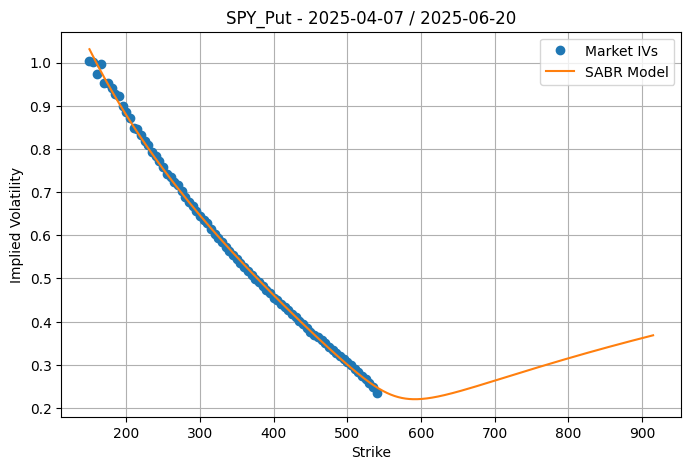

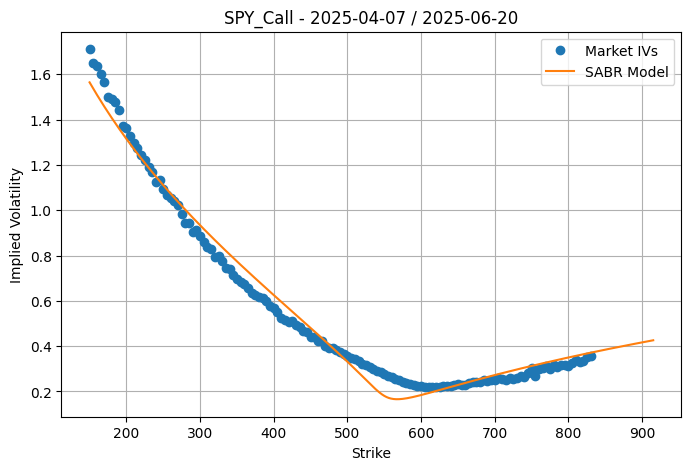

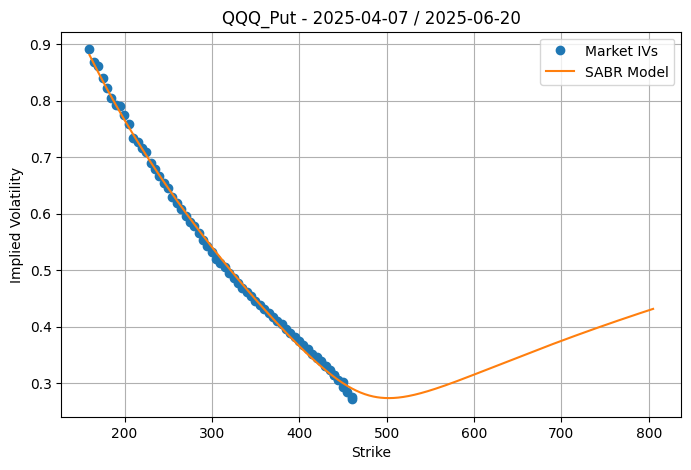

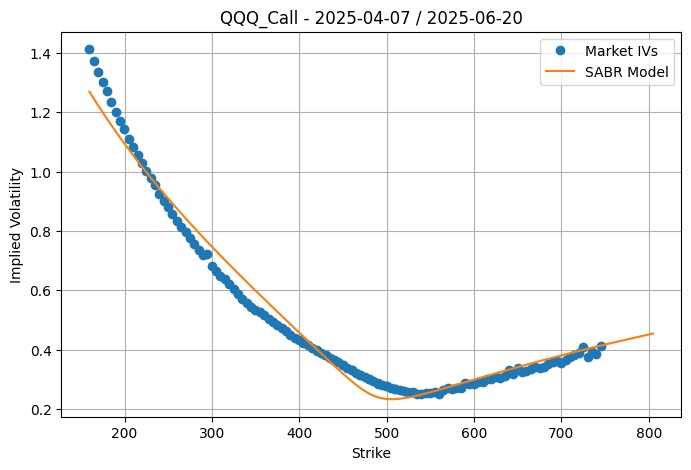

In [35]:
# Set your parameters
snapshot = '2025-04-07'
maturity = '2025-06-20'

# Map of xarrays and their calibrated params
ivs_map = {
    'SPY_Put': (spy_put, SABR_spy_put_params),
    'SPY_Call': (spy_call, SABR_spy_call_params),
    'QQQ_Put': (qqq_put, SABR_qqq_put_params),
    'QQQ_Call': (qqq_call, SABR_qqq_call_params)
}

for name, (iv_array, param_array) in ivs_map.items():
    try:
        # Extract vols and strikes
        market_vols = iv_array.sel(snapshot_date=snapshot, maturity=maturity).values
        strikes = iv_array.coords['strike'].values

        # Remove market_vols == 0
        mask = market_vols != 0
        strikes_clean = strikes[mask]
        market_vols_clean = market_vols[mask]

        # Extract calibration parameters
        params = param_array.sel(snapshot_date=snapshot, maturity=maturity)
        alpha = params.sel(parameter='alpha').item()
        rho = params.sel(parameter='rho').item()
        sigma0 = params.sel(parameter='sigma0').item()
        T = params.sel(parameter='T').item()
        F = params.sel(parameter='F').item()

        # Skip if parameters are missing
        if any(p is None or np.isnan(p) for p in [alpha, rho, sigma0, T, F]):
            print(f"Skipping {name}: parameters missing for {snapshot}, {maturity}")
            continue

        # Compute SABR vols on cleaned strikes
        sabr_vols = np.array([
            SABR_calibration(k, alpha, rho, sigma0, T, F) for k in strikes_clean
        ])

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(strikes_clean, market_vols_clean, 'o', label='Market IVs')
        plt.plot(strikes_clean, sabr_vols, '-', label='SABR Model')
        plt.title(f'{name} - {snapshot} / {maturity}')
        plt.xlabel('Strike')
        plt.ylabel('Implied Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()
    except KeyError:
        print(f"{name} does not have data for snapshot {snapshot} and maturity {maturity}")


## Raw SVI

### Calibration

In [36]:
# Define your parameter names
param_names = ['a', 'b', 'rho', 'm', 'sigma', 'T', 'F']

# Create an empty dictionary to hold the calibrated xarrays
calibrated_results = {}

# Define a helper function to calibrate one xarray (SPY_Put etc.)
def calibrateRawSVI_iv_surface(iv_array, underlying_name):
    snapshots = iv_array.coords['snapshot_date'].values
    maturities = iv_array.coords['maturity'].values
    strikes = iv_array.coords['strike'].values

    # Prepare a blank DataArray to hold parameters
    result_da = xr.DataArray(
        np.full((len(snapshots), len(maturities), len(param_names)), np.nan),
        coords={
            'snapshot_date': snapshots,
            'maturity': maturities,
            'parameter': param_names
        },
        dims=['snapshot_date', 'maturity', 'parameter']
    )

    # Loop over each snapshot and maturity
    for i, snapshot in enumerate(snapshots):
        snapshot_dt = pd.to_datetime(snapshot)

        for j, maturity in enumerate(maturities):
            maturity_dt = pd.to_datetime(maturity)
            T = (maturity_dt - snapshot_dt).days / 365.0

            if T <= 0:
                continue

            # Extract the IV slice (strike axis)
            iv_slice = iv_array.sel(snapshot_date=snapshot, maturity=maturity)
            vols = iv_slice.values.astype(float)

            vols = np.where(vols == 0, np.nan, vols)

            mask = ~np.isnan(vols)
            if np.sum(mask) < 5:  # SVI needs at least ~5 points
                continue

            K_valid = strikes[mask].astype(float)
            vols_valid = vols[mask]

            # Get forward from forwards_data
            forward_row = forwards_data[
                (forwards_data['Underlying'] == underlying_name) &
                (forwards_data['Target Date'] == snapshot) &
                (forwards_data['Maturity'] == maturity[:7])
            ]

            spot_row = spot_data[
                (spot_data['Date'] == snapshot)
            ]

            if forward_row.empty:
              if spot_row.empty:
                F = np.nan
                continue
              else:
                if underlying_name == 'SPY':
                    F = float(spot_row['SPY'].iloc[0])
                elif underlying_name == 'QQQ':
                    F = float(spot_row['QQQ'].iloc[0])
            else:
                try:
                    F_raw = float(forward_row['Close'].iloc[0])
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan

            '''
            theo_forward = theo_fwd[underlying_name].sel(snapshot_date=snapshot, maturity=maturity)

            if forward_row.empty:
                try:
                    F_raw = float(theo_forward)
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan
            else:
                try:
                    F_raw = float(forward_row['Close'].iloc[0])
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan
            '''

            if np.isnan(F):
                continue

            # Initial guess and bounds
            atm_iv = vols_valid[np.argmin(np.abs(K_valid - F))]
            p0 = [0.01, 0.1, 0.0, 0.0, 0.1]  # typical SVI shape
            bounds = (
                [-3, 0, -0.999, -3, 0],  # lower bounds: a, b, rho, m, sigma
                [3, 10, 0.999, 3, 4]    # upper bounds
            )

            # Calibration attempt
            try:
                popt, _ = curve_fit(
                    lambda K, a, b, rho, m, sigma: RawSVI_calibration(K, a, b, rho, m, sigma, T, F),
                    K_valid,
                    vols_valid*np.sqrt(T),
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000  # allow more function evaluations if needed
                )
                a, b, rho, m, sigma = popt
            except RuntimeError:
                a, b, rho, m, sigma = np.nan, np.nan, np.nan, np.nan, np.nan

            # Save results
            result_da.loc[dict(snapshot_date=snapshot, maturity=maturity)] = [a, b, rho, m, sigma, T, F]

    return result_da

# Calibrate each IV surface
calibrated_results['SPY_Put'] = calibrateRawSVI_iv_surface(spy_put, 'SPY')
calibrated_results['SPY_Call'] = calibrateRawSVI_iv_surface(spy_call, 'SPY')
calibrated_results['QQQ_Put'] = calibrateRawSVI_iv_surface(qqq_put, 'QQQ')
calibrated_results['QQQ_Call'] = calibrateRawSVI_iv_surface(qqq_call, 'QQQ')

# Unpack the results
RawSVI_spy_put_params = calibrated_results['SPY_Put']
RawSVI_spy_call_params = calibrated_results['SPY_Call']
RawSVI_qqq_put_params = calibrated_results['QQQ_Put']
RawSVI_qqq_call_params = calibrated_results['QQQ_Call']


### MSE

In [37]:
def computeRawSVI_mse_xarray(iv_array, rawsvi_params_xr):
    snapshot_dates = iv_array.coords['snapshot_date'].values
    maturities = iv_array.coords['maturity'].values
    strikes = iv_array.coords['strike'].values

    mse_data = np.full((len(snapshot_dates), len(maturities)), np.nan)

    for i, snapshot in enumerate(snapshot_dates):
        for j, maturity in enumerate(maturities):
            iv_slice = iv_array.sel(snapshot_date=snapshot, maturity=maturity).values

            if np.all(np.isnan(iv_slice)):
                continue

            params_slice = rawsvi_params_xr.sel(snapshot_date=snapshot, maturity=maturity)

            a = params_slice.sel(parameter='a').values
            b = params_slice.sel(parameter='b').values
            rho = params_slice.sel(parameter='rho').values
            m = params_slice.sel(parameter='m').values
            sigma = params_slice.sel(parameter='sigma').values
            T = params_slice.sel(parameter='T').values
            F = params_slice.sel(parameter='F').values

            if np.any(pd.isna([a, b, rho, m, sigma, T, F])):
                continue

            K = strikes

            # Compute RawSVI vols for all strikes
            rawsvi_vols = np.array([
                RawSVI_calibration(k, a, b, rho, m, sigma, T, F)/np.sqrt(T)
                for k in K
            ])

            market_vols = np.array(iv_slice)

            if np.all(np.isnan(market_vols)):
                continue

            mask = (~np.isnan(market_vols)) & np.isfinite(rawsvi_vols) & (market_vols != 0)

            if np.sum(mask) == 0:
                continue

            mse = mean_squared_error(market_vols[mask], rawsvi_vols[mask])

            mse_data[i, j] = mse

    mse_xr = xr.DataArray(
        data=mse_data,
        coords={
            'snapshot_date': snapshot_dates,
            'maturity': maturities
        },
        dims=['snapshot_date', 'maturity']
    )

    return mse_xr

# Compute MSE xarrays for each IV surface
mse_results = {}

mse_results['SPY_Put'] = computeRawSVI_mse_xarray(spy_put, RawSVI_spy_put_params)
mse_results['SPY_Call'] = computeRawSVI_mse_xarray(spy_call, RawSVI_spy_call_params)
mse_results['QQQ_Put'] = computeRawSVI_mse_xarray(qqq_put, RawSVI_qqq_put_params)
mse_results['QQQ_Call'] = computeRawSVI_mse_xarray(qqq_call, RawSVI_qqq_call_params)

RawSVI_spy_put_mse = mse_results['SPY_Put']
RawSVI_spy_call_mse = mse_results['SPY_Call']
RawSVI_qqq_put_mse = mse_results['QQQ_Put']
RawSVI_qqq_call_mse = mse_results['QQQ_Call']

In [38]:
RawSVI_spy_call_mse

<xarray.DataArray (snapshot_date: 15, maturity: 9)> Size: 1kB
array([[5.79079663e-04, 4.68030512e-05, 6.37734544e-05, 7.46116190e-05,
        3.58087105e-05, 3.48614268e-05, 2.39434216e-05, 2.73529936e-05,
        1.65393956e-05],
       [           nan, 4.35565698e-02, 8.06080014e-04,            nan,
        7.28476926e-04, 7.51260405e-04, 3.19674013e-04, 1.34671361e-03,
        1.59944314e-04],
       [1.10000599e-03, 2.23563877e-04, 1.60151607e-04, 1.59788982e-04,
        3.83722016e-05, 2.10795930e-05, 2.54383181e-05, 2.22705029e-05,
        1.77523034e-05],
       [           nan, 2.43997278e-04, 6.26744530e-05, 4.91478935e-05,
        3.29988912e-05, 8.40879165e-06, 1.50091322e-05, 8.96063837e-06,
        1.06626708e-05],
       [           nan, 1.01590463e-04, 7.43570847e-05, 5.68985342e-05,
        3.04377130e-05, 1.80992169e-05, 1.52885828e-05, 1.70303489e-05,
        1.15344509e-05],
       [           nan, 3.68145194e-04, 3.94786152e-05, 2.54359957e-05,
        2.78024280e-05, 3.03821017e-06, 2.90879772e-06, 4.51404847e-06,
        4.88766552e-06],
       [           nan, 2.45882259e-02, 5.62412139e-05, 7.56670580e-05,
        7.95786038e-06, 1.01692419e-05, 1.59956138e-05, 8.17955859e-06,
...
        1.96631719e-05, 1.65051453e-05, 1.78276904e-05, 1.96204745e-05,
        1.25126108e-05],
       [           nan,            nan, 3.50200224e-03, 3.72315643e-04,
        4.03809729e-05, 3.93056150e-06, 7.20935199e-06, 1.49983935e-05,
        8.57627619e-06],
       [           nan,            nan, 2.20439968e-03, 6.63604478e-04,
        2.33179072e-03, 8.26706859e-06, 1.09499035e-05, 5.40164672e-06,
        4.81841653e-06],
       [           nan,            nan, 3.74749251e-03, 1.62254449e-04,
        6.85470882e-05, 2.88222383e-05, 3.25580481e-05, 2.10224730e-05,
        1.01750311e-05],
       [           nan,            nan, 9.64098531e-04, 2.34266997e-04,
        5.28395119e-05, 2.19577372e-05, 1.79192870e-05, 1.89749135e-05,
        1.25633223e-05],
       [           nan,            nan, 2.58025543e-02, 1.67744038e-04,
        3.17771684e-05, 9.62833073e-06, 1.00134377e-05, 1.85948498e-05,
        1.89327894e-05],
       [           nan,            nan,            nan, 3.30718683e-03,
        2.11692024e-04, 3.43174513e-05, 1.30100559e-05,            nan,
        8.55469000e-06]])
Coordinates:
  * snapshot_date  (snapshot_date) object 120B '2025-04-07' ... '2025-05-19'
  * maturity       (maturity) <U10 360B '2025-04-11' ... '2027-12-17'

### Plotting

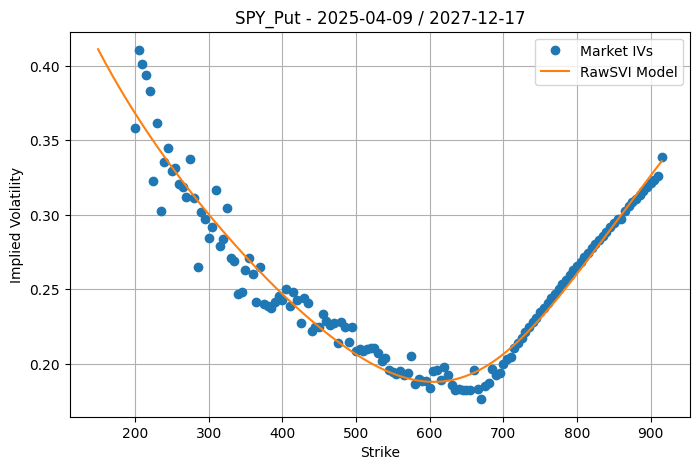

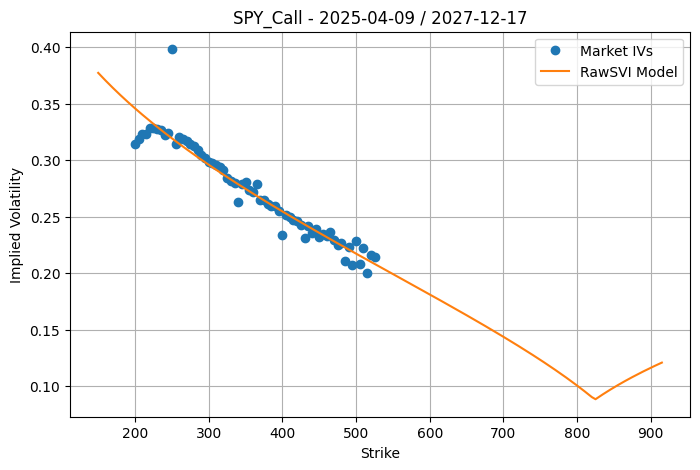

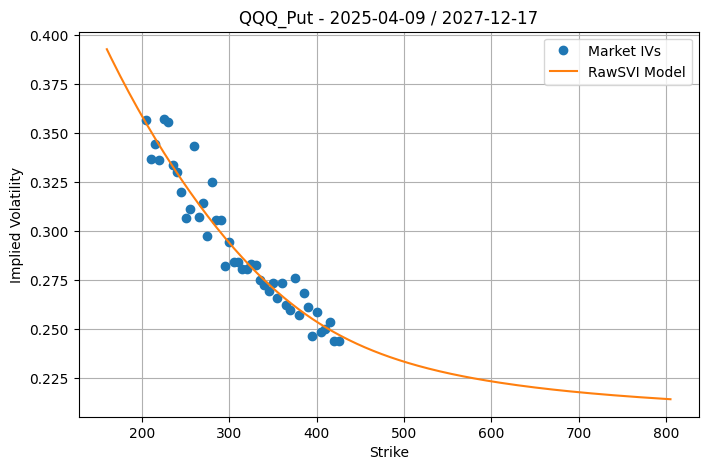

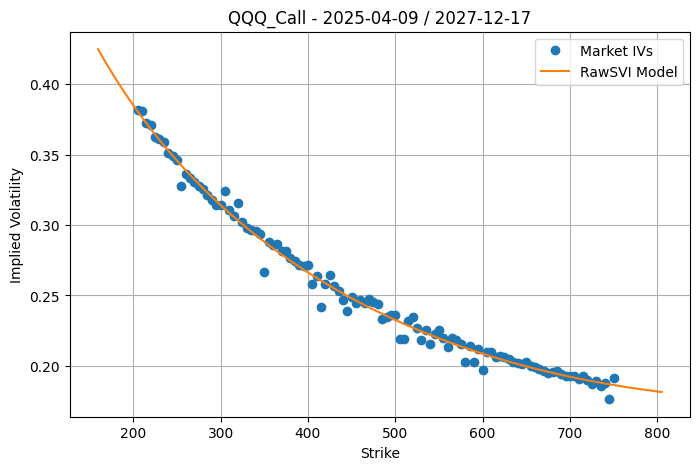

In [39]:
# Set your parameters
snapshot = '2025-04-09'
maturity = '2027-12-17'

# Map of xarrays and their calibrated RawSVI params
ivs_map = {
    'SPY_Put': (spy_put, RawSVI_spy_put_params),
    'SPY_Call': (spy_call, RawSVI_spy_call_params),
    'QQQ_Put': (qqq_put, RawSVI_qqq_put_params),
    'QQQ_Call': (qqq_call, RawSVI_qqq_call_params)
}

for name, (iv_array, param_array) in ivs_map.items():
    try:
        # Extract vols and strikes
        market_vols = iv_array.sel(snapshot_date=snapshot, maturity=maturity).values
        strikes = iv_array.coords['strike'].values

        # Remove market_vols == 0
        mask = market_vols != 0
        strikes_clean = strikes[mask]
        market_vols_clean = market_vols[mask]

        # Extract calibration parameters
        params = param_array.sel(snapshot_date=snapshot, maturity=maturity)
        a = params.sel(parameter='a').item()
        b = params.sel(parameter='b').item()
        rho = params.sel(parameter='rho').item()
        m = params.sel(parameter='m').item()
        sigma = params.sel(parameter='sigma').item()
        T = params.sel(parameter='T').item()
        F = params.sel(parameter='F').item()

        # Skip if parameters are missing
        if any(p is None or np.isnan(p) for p in [a, b, rho, m, sigma, T, F]):
            print(f"Skipping {name}: parameters missing for {snapshot}, {maturity}")
            continue

        # Compute RawSVI vols on cleaned strikes
        rawsvi_vols = np.array([
            RawSVI_calibration(k, a, b, rho, m, sigma, T, F)/np.sqrt(T) for k in strikes_clean
        ])

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(strikes_clean, market_vols_clean, 'o', label='Market IVs')
        plt.plot(strikes_clean, rawsvi_vols, '-', label='RawSVI Model')
        plt.title(f'{name} - {snapshot} / {maturity}')
        plt.xlabel('Strike')
        plt.ylabel('Implied Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()
    except KeyError:
        print(f"{name} does not have data for snapshot {snapshot} and maturity {maturity}")


## Natural SVI

In [40]:
def raw_to_natural(a, b, rho, m, sigma):
    sqrt_term = np.sqrt(1 - rho**2)
    omega = (2 * b * sigma) / sqrt_term
    zeta = sqrt_term / sigma
    delta = a - (omega / 2) * (1 - rho**2)
    mu = m + (rho * sigma) / sqrt_term
    return delta, mu, rho, omega, zeta

raw_to_natural(0.01, 0.1, 0.0, 0.0, 0.1)

(np.float64(-1.734723475976807e-18),
 np.float64(0.0),
 0.0,
 np.float64(0.020000000000000004),
 np.float64(10.0))

### Calibration

In [41]:
# Define your parameter names
param_names = ['delta', 'mu', 'rho', 'omega', 'ksi', 'T', 'F']

# Create an empty dictionary to hold the calibrated xarrays
calibrated_results = {}

# Define a helper function to calibrate one xarray (SPY_Put etc.)
def calibrateNaturalSVI_iv_surface(iv_array, underlying_name):
    snapshots = iv_array.coords['snapshot_date'].values
    maturities = iv_array.coords['maturity'].values
    strikes = iv_array.coords['strike'].values

    # Prepare a blank DataArray to hold parameters
    result_da = xr.DataArray(
        np.full((len(snapshots), len(maturities), len(param_names)), np.nan),
        coords={
            'snapshot_date': snapshots,
            'maturity': maturities,
            'parameter': param_names
        },
        dims=['snapshot_date', 'maturity', 'parameter']
    )

    # Loop over each snapshot and maturity
    for i, snapshot in enumerate(snapshots):
        snapshot_dt = pd.to_datetime(snapshot)

        for j, maturity in enumerate(maturities):
            maturity_dt = pd.to_datetime(maturity)
            T = (maturity_dt - snapshot_dt).days / 365.0

            if T <= 0:
                continue

            # Extract the IV slice (strike axis)
            iv_slice = iv_array.sel(snapshot_date=snapshot, maturity=maturity)
            vols = iv_slice.values.astype(float)

            vols = np.where(vols == 0, np.nan, vols)

            mask = ~np.isnan(vols)
            if np.sum(mask) < 5:  # need enough points for calibration
                continue

            K_valid = strikes[mask].astype(float)
            vols_valid = vols[mask]

            # Get forward from forwards_data
            forward_row = forwards_data[
                (forwards_data['Underlying'] == underlying_name) &
                (forwards_data['Target Date'] == snapshot) &
                (forwards_data['Maturity'] == maturity[:7])
            ]

            spot_row = spot_data[
                (spot_data['Date'] == snapshot)
            ]

            if forward_row.empty:
              if spot_row.empty:
                F = np.nan
                continue
              else:
                if underlying_name == 'SPY':
                    F = float(spot_row['SPY'].iloc[0])
                elif underlying_name == 'QQQ':
                    F = float(spot_row['QQQ'].iloc[0])
            else:
                try:
                    F_raw = float(forward_row['Close'].iloc[0])
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan

            '''
            theo_forward = theo_fwd[underlying_name].sel(snapshot_date=snapshot, maturity=maturity)

            if forward_row.empty:
                try:
                    F_raw = float(theo_forward)
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan
            else:
                try:
                    F_raw = float(forward_row['Close'].iloc[0])
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan
            '''

            if np.isnan(F):
                continue

            # Initial guess and bounds
            atm_iv = vols_valid[np.argmin(np.abs(K_valid - F))]
            p0 = [0.0, 0.0, 0.0, 0.2, 10]#[-0.01, 0.0, 0.0, 0.1, 0.1]  # reasonable natural SVI guess
            bounds = (
                [-2, -2, -0.999, 0, 0],  # lower bounds: delta, mu, rho, omega, ksi
                [2, 2, 0.999, 10, 20]    # upper bounds
            )

            # Calibration attempt
            try:
                popt, _ = curve_fit(
                    lambda K, delta, mu, rho, omega, ksi: NaturalSVI_calibration(K, delta, mu, rho, omega, ksi, T, F),
                    K_valid,
                    vols_valid * np.sqrt(T),
                    p0=p0,
                    bounds=bounds,
                    maxfev=10000
                )
                delta, mu, rho, omega, ksi = popt
            except RuntimeError:
                delta, mu, rho, omega, ksi = np.nan, np.nan, np.nan, np.nan, np.nan

            # Save results
            result_da.loc[dict(snapshot_date=snapshot, maturity=maturity)] = [delta, mu, rho, omega, ksi, T, F]

    return result_da

# Calibrate each IV surface
calibrated_results['SPY_Put'] = calibrateNaturalSVI_iv_surface(spy_put, 'SPY')
calibrated_results['SPY_Call'] = calibrateNaturalSVI_iv_surface(spy_call, 'SPY')
calibrated_results['QQQ_Put'] = calibrateNaturalSVI_iv_surface(qqq_put, 'QQQ')
calibrated_results['QQQ_Call'] = calibrateNaturalSVI_iv_surface(qqq_call, 'QQQ')

# Unpack the results
NaturalSVI_spy_put_params = calibrated_results['SPY_Put']
NaturalSVI_spy_call_params = calibrated_results['SPY_Call']
NaturalSVI_qqq_put_params = calibrated_results['QQQ_Put']
NaturalSVI_qqq_call_params = calibrated_results['QQQ_Call']


### MSE

In [42]:
def computeNaturalSVI_mse_xarray(iv_array, naturalsvi_params_xr):
    snapshot_dates = iv_array.coords['snapshot_date'].values
    maturities = iv_array.coords['maturity'].values
    strikes = iv_array.coords['strike'].values

    mse_data = np.full((len(snapshot_dates), len(maturities)), np.nan)

    for i, snapshot in enumerate(snapshot_dates):
        for j, maturity in enumerate(maturities):
            iv_slice = iv_array.sel(snapshot_date=snapshot, maturity=maturity).values

            if np.all(np.isnan(iv_slice)):
                continue

            params_slice = naturalsvi_params_xr.sel(snapshot_date=snapshot, maturity=maturity)

            delta = params_slice.sel(parameter='delta').values
            mu = params_slice.sel(parameter='mu').values
            rho = params_slice.sel(parameter='rho').values
            omega = params_slice.sel(parameter='omega').values
            ksi = params_slice.sel(parameter='ksi').values
            T = params_slice.sel(parameter='T').values
            F = params_slice.sel(parameter='F').values

            if np.any(pd.isna([delta, mu, rho, omega, ksi, T, F])):
                continue

            K = strikes

            # Compute NaturalSVI vols for all strikes
            naturalsvi_vols = np.array([
                NaturalSVI_calibration(k, delta, mu, rho, omega, ksi, T, F) / np.sqrt(T)
                for k in K
            ])

            market_vols = np.array(iv_slice)

            if np.all(np.isnan(market_vols)):
                continue

            mask = (~np.isnan(market_vols)) & np.isfinite(naturalsvi_vols) & (market_vols != 0)

            if np.sum(mask) == 0:
                continue

            mse = mean_squared_error(market_vols[mask], naturalsvi_vols[mask])

            mse_data[i, j] = mse

    mse_xr = xr.DataArray(
        data=mse_data,
        coords={
            'snapshot_date': snapshot_dates,
            'maturity': maturities
        },
        dims=['snapshot_date', 'maturity']
    )

    return mse_xr

# Compute MSE xarrays for each IV surface
mse_results = {}

mse_results['SPY_Put'] = computeNaturalSVI_mse_xarray(spy_put, NaturalSVI_spy_put_params)
mse_results['SPY_Call'] = computeNaturalSVI_mse_xarray(spy_call, NaturalSVI_spy_call_params)
mse_results['QQQ_Put'] = computeNaturalSVI_mse_xarray(qqq_put, NaturalSVI_qqq_put_params)
mse_results['QQQ_Call'] = computeNaturalSVI_mse_xarray(qqq_call, NaturalSVI_qqq_call_params)

NaturalSVI_spy_put_mse = mse_results['SPY_Put']
NaturalSVI_spy_call_mse = mse_results['SPY_Call']
NaturalSVI_qqq_put_mse = mse_results['QQQ_Put']
NaturalSVI_qqq_call_mse = mse_results['QQQ_Call']


In [43]:
NaturalSVI_spy_call_mse

<xarray.DataArray (snapshot_date: 15, maturity: 9)> Size: 1kB
array([[5.83992104e-04, 4.68030512e-05, 6.37734545e-05, 8.40127873e-05,
        4.38705900e-05, 3.70152172e-05, 2.68923719e-05, 3.03355384e-05,
        1.78247978e-05],
       [           nan, 1.31548888e-03, 8.33523024e-04,            nan,
        7.28584887e-04, 8.34685574e-04, 3.19674053e-04, 1.34671365e-03,
        1.59944344e-04],
       [1.10000599e-03, 2.38032981e-04, 1.60151611e-04, 1.92043005e-04,
        4.55960161e-05, 2.27853574e-05, 2.77450628e-05, 2.46943396e-05,
        1.87796001e-05],
       [           nan, 2.44657125e-04, 6.32605407e-05, 4.91478935e-05,
        3.29988912e-05, 8.41760798e-06, 1.50091322e-05, 8.98245919e-06,
        1.06721179e-05],
       [           nan, 1.01590464e-04, 7.43570886e-05, 6.17513847e-05,
        3.46627292e-05, 1.95485740e-05, 1.72123325e-05, 1.88733985e-05,
        1.21563759e-05],
       [           nan, 3.72481357e-04, 3.94786152e-05, 2.73347760e-05,
        2.78024280e-05, 3.04358820e-06, 2.90879772e-06, 4.54032001e-06,
        4.88856824e-06],
       [           nan, 2.45985380e-02, 5.62413391e-05, 7.56670582e-05,
        8.07145411e-06, 1.01923349e-05, 1.60292308e-05, 8.23713357e-06,
...
        2.04608590e-05, 1.82478659e-05, 1.94171440e-05, 2.11180316e-05,
        1.28947008e-05],
       [           nan,            nan, 3.50329174e-03, 3.72465537e-04,
        4.04671264e-05, 3.93903357e-06, 7.22205954e-06, 1.50061908e-05,
        8.58405646e-06],
       [           nan,            nan, 2.20489346e-03, 6.70125634e-04,
        2.33179771e-03, 8.27992961e-06, 1.09550797e-05, 5.40857096e-06,
        4.81993864e-06],
       [           nan,            nan, 3.74749251e-03, 1.62254449e-04,
        6.85470882e-05, 3.01033391e-05, 3.33034553e-05, 2.18840295e-05,
        1.05815881e-05],
       [           nan,            nan, 9.64098531e-04, 2.36644326e-04,
        5.28395120e-05, 2.34951824e-05, 1.90780280e-05, 2.04187433e-05,
        1.30805394e-05],
       [           nan,            nan, 2.58025543e-02, 1.67744037e-04,
        3.18123084e-05, 1.08035615e-05, 1.11818609e-05, 1.97771065e-05,
        1.89327894e-05],
       [           nan,            nan,            nan, 3.30718683e-03,
        2.12100123e-04, 3.54178256e-05, 1.40461516e-05,            nan,
        8.75889463e-06]])
Coordinates:
  * snapshot_date  (snapshot_date) object 120B '2025-04-07' ... '2025-05-19'
  * maturity       (maturity) <U10 360B '2025-04-11' ... '2027-12-17'

### Plotting

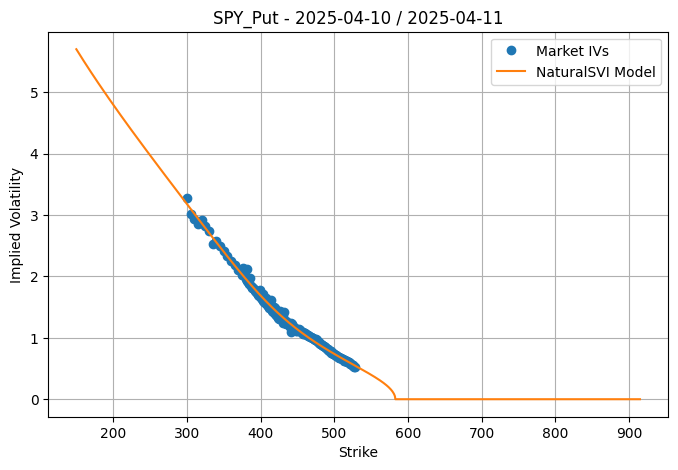

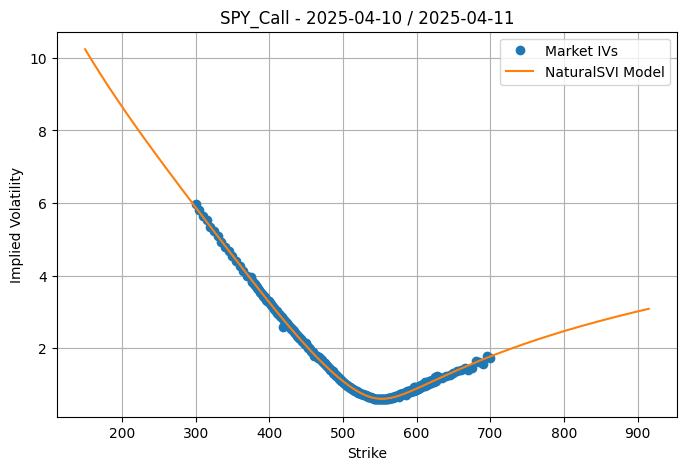

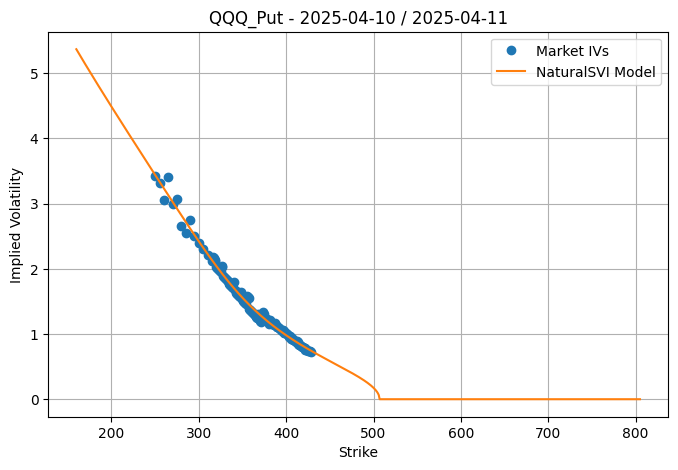

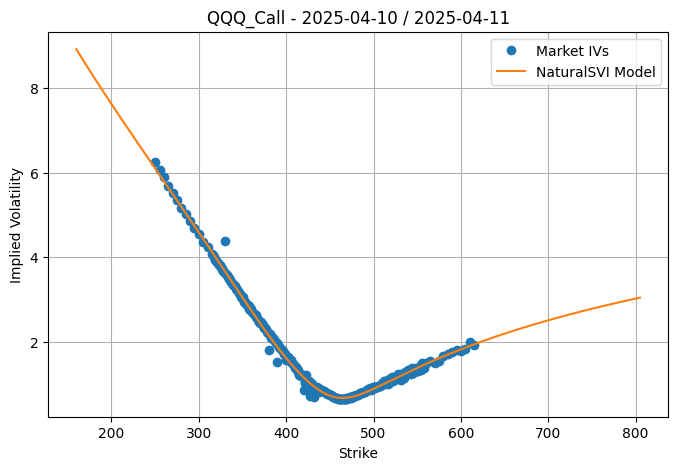

In [44]:
# Set your parameters
snapshot = '2025-04-10'
maturity = '2025-04-11'

# Map of xarrays and their calibrated NaturalSVI params
ivs_map = {
    'SPY_Put': (spy_put, NaturalSVI_spy_put_params),
    'SPY_Call': (spy_call, NaturalSVI_spy_call_params),
    'QQQ_Put': (qqq_put, NaturalSVI_qqq_put_params),
    'QQQ_Call': (qqq_call, NaturalSVI_qqq_call_params)
}

for name, (iv_array, param_array) in ivs_map.items():
    try:
        # Extract vols and strikes
        market_vols = iv_array.sel(snapshot_date=snapshot, maturity=maturity).values
        strikes = iv_array.coords['strike'].values

        # Remove market_vols == 0
        mask = market_vols != 0
        strikes_clean = strikes[mask]
        market_vols_clean = market_vols[mask]

        # Extract calibration parameters
        params = param_array.sel(snapshot_date=snapshot, maturity=maturity)
        delta = params.sel(parameter='delta').item()
        mu = params.sel(parameter='mu').item()
        rho = params.sel(parameter='rho').item()
        omega = params.sel(parameter='omega').item()
        ksi = params.sel(parameter='ksi').item()
        T = params.sel(parameter='T').item()
        F = params.sel(parameter='F').item()

        # Skip if parameters are missing
        if any(p is None or np.isnan(p) for p in [delta, mu, rho, omega, ksi, T, F]):
            print(f"Skipping {name}: parameters missing for {snapshot}, {maturity}")
            continue

        # Compute NaturalSVI vols on cleaned strikes
        naturalsvi_vols = np.array([
            NaturalSVI_calibration(k, delta, mu, rho, omega, ksi, T, F) / np.sqrt(T) for k in strikes_clean
        ])

        # Plot
        plt.figure(figsize=(8, 5))
        plt.plot(strikes_clean, market_vols_clean, 'o', label='Market IVs')
        plt.plot(strikes_clean, naturalsvi_vols, '-', label='NaturalSVI Model')
        plt.title(f'{name} - {snapshot} / {maturity}')
        plt.xlabel('Strike')
        plt.ylabel('Implied Volatility')
        plt.legend()
        plt.grid(True)
        plt.show()
    except KeyError:
        print(f"{name} does not have data for snapshot {snapshot} and maturity {maturity}")


## FPI-SVI

### Calibration

In [45]:
# Define your parameter names
param_names = ['a', 'b', 'rho', 'm', 'sigma', 'T', 'F']

# Create an empty dictionary to hold the calibrated xarrays
calibrated_results_fpi = {}

def calibrateFPISVI_iv_surface(iv_array, underlying_name):
    EPS = 1e-6
    RHO_LIMIT = 0.999

    snapshots = iv_array.coords['snapshot_date'].values
    maturities = iv_array.coords['maturity'].values
    strikes = iv_array.coords['strike'].values

    result_da = xr.DataArray(
        np.full((len(snapshots), len(maturities), len(param_names)), np.nan),
        coords={
            'snapshot_date': snapshots,
            'maturity': maturities,
            'parameter': param_names
        },
        dims=['snapshot_date', 'maturity', 'parameter']
    )

    for i, snapshot in enumerate(snapshots):
        snapshot_dt = pd.to_datetime(snapshot)
        for j, maturity in enumerate(maturities):
            maturity_dt = pd.to_datetime(maturity)
            T = (maturity_dt - snapshot_dt).days / 365.0

            if T <= 0:
                continue

            iv_slice = iv_array.sel(snapshot_date=snapshot, maturity=maturity)
            mkt_vols = iv_slice.values.astype(float)
            mkt_vols = np.where(mkt_vols == 0, np.nan, mkt_vols)

            mask = ~np.isnan(mkt_vols)
            if np.sum(mask) < 5:
                continue

            strikes_float = strikes.astype(float)
            strikes_valid = strikes_float[mask]
            vols_valid = mkt_vols[mask]

            forward_row = forwards_data[
                (forwards_data['Underlying'] == underlying_name) &
                (forwards_data['Target Date'] == snapshot) &
                (forwards_data['Maturity'] == maturity[:7])
            ]

            spot_row = spot_data[
                (spot_data['Date'] == snapshot)
            ]

            if forward_row.empty:
              if spot_row.empty:
                F = np.nan
                continue
              else:
                if underlying_name == 'SPY':
                    F = float(spot_row['SPY'].iloc[0])
                elif underlying_name == 'QQQ':
                    F = float(spot_row['QQQ'].iloc[0])
            else:
                try:
                    F_raw = float(forward_row['Close'].iloc[0])
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan

            '''
            theo_forward = theo_fwd[underlying_name].sel(snapshot_date=snapshot, maturity=maturity)

            if forward_row.empty:
                try:
                    F_raw = float(theo_forward)
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan
            else:
                try:
                    F_raw = float(forward_row['Close'].iloc[0])
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan
            '''

            if np.isnan(F):
                continue

            # FPI-SVI Calibration
            moneyness = np.log(strikes_valid / F)
            filtered_vars = T*vols_valid**2

            min_index = np.argmin(filtered_vars)
            min_var = filtered_vars[min_index]
            min_moneyness = moneyness[min_index]

            m0 = min_moneyness
            sigma0 = min_var
            d = 0.001
            M = 2000
            n = 0

            col2 = moneyness - m0
            col3 = np.sqrt((moneyness - m0)**2 + sigma0**2)
            Y0 = np.column_stack((np.ones_like(moneyness), col2, col3))
            try:
                beta0 = np.linalg.inv(Y0.T @ Y0) @ (Y0.T @ filtered_vars)
                if abs(beta0[2]) < EPS:
                    continue
                a0, b0, rho0 = beta0[0], beta0[2], beta0[1] / beta0[2]
                L0 = np.sqrt(np.sum((filtered_vars - Y0 @ beta0)**2))
            except (np.linalg.LinAlgError, ValueError):
                continue

            a, b, rho, L = [a0], [b0], [rho0], [L0]
            m, sigma = [m0], [sigma0]

            Ln = L0
            while Ln > d and n <= M:
                n += 1
                try:
                    rho_safe = np.clip(rho[n-1], -RHO_LIMIT, RHO_LIMIT)
                    denom = b[n-1] * (1 - rho_safe**2)
                    if abs(denom) < EPS:
                        break

                    mn = min_moneyness + (rho_safe * (min_var - a[n-1])) / denom
                    m.append(mn)

                    sig_denom = b[n-1] * np.sqrt(1 - rho_safe**2)
                    if sig_denom < EPS:
                        break

                    sigman = (min_var - a[n-1]) / sig_denom
                    sigma.append(sigman)

                    col2 = moneyness - m[n]
                    col3 = np.sqrt((moneyness - m[n])**2 + sigma[n]**2)
                    Y = np.column_stack((np.ones_like(moneyness), col2, col3))
                    betan = np.linalg.inv(Y.T @ Y) @ (Y.T @ filtered_vars)

                    if abs(betan[2]) < EPS:
                        break

                    a.append(betan[0])
                    b.append(betan[2])
                    rho.append(betan[1] / betan[2])
                    residuals = filtered_vars - Y @ betan
                    Ln = np.sqrt(np.sum(residuals**2))
                    L.append(Ln)
                except (np.linalg.LinAlgError, ValueError):
                    a.append(np.nan)
                    b.append(np.nan)
                    rho.append(np.nan)
                    m.append(np.nan)
                    sigma.append(np.nan)
                    break

            result_da.loc[dict(snapshot_date=snapshot, maturity=maturity)] = [
                a[-1], b[-1], rho[-1], m[-1], sigma[-1], T, F
            ]

    return result_da

calibrated_results_fpi['SPY_Call'] = calibrateFPISVI_iv_surface(spy_call, 'SPY')
calibrated_results_fpi['SPY_Put'] = calibrateFPISVI_iv_surface(spy_put, 'SPY')
calibrated_results_fpi['QQQ_Call'] = calibrateFPISVI_iv_surface(qqq_call, 'QQQ')
calibrated_results_fpi['QQQ_Put'] = calibrateFPISVI_iv_surface(qqq_put, 'QQQ')

# Unpack
FPISVI_spy_call_params = calibrated_results_fpi['SPY_Call']
FPISVI_spy_put_params = calibrated_results_fpi['SPY_Put']
FPISVI_qqq_call_params = calibrated_results_fpi['QQQ_Call']
FPISVI_qqq_put_params = calibrated_results_fpi['QQQ_Put']

In [46]:
# Define your parameter names
param_names = ['a', 'b', 'rho', 'm', 'sigma', 'T', 'F']

# Create an empty dictionary to hold the calibrated xarrays
calibrated_results_fpi = {}

def calibrateRawFPISVI_iv_surface(iv_array, underlying_name):
    EPS = 1e-6       # Small threshold to avoid divide-by-zero
    RHO_LIMIT = 0.999  # Clamp rho to avoid 1 - rho^2 → 0

    snapshots = iv_array.coords['snapshot_date'].values
    maturities = iv_array.coords['maturity'].values
    strikes = iv_array.coords['strike'].values

    raw_svi_result = calibrateRawSVI_iv_surface(iv_array, underlying_name)

    result_da = xr.DataArray(
        np.full((len(snapshots), len(maturities), len(param_names)), np.nan),
        coords={
            'snapshot_date': snapshots,
            'maturity': maturities,
            'parameter': param_names
        },
        dims=['snapshot_date', 'maturity', 'parameter']
    )

    for i, snapshot in enumerate(snapshots):
        snapshot_dt = pd.to_datetime(snapshot)
        for j, maturity in enumerate(maturities):
            maturity_dt = pd.to_datetime(maturity)
            T = (maturity_dt - snapshot_dt).days / 365.0

            if T <= 0:
                continue

            iv_slice = iv_array.sel(snapshot_date=snapshot, maturity=maturity)
            mkt_vols = iv_slice.values.astype(float)
            mkt_vols = np.where(mkt_vols == 0, np.nan, mkt_vols)

            mask = ~np.isnan(mkt_vols)
            if np.sum(mask) < 5:
                continue

            strikes_float = strikes.astype(float)
            strikes_valid = strikes_float[mask]
            vols_valid = mkt_vols[mask]

            forward_row = forwards_data[
                (forwards_data['Underlying'] == underlying_name) &
                (forwards_data['Target Date'] == snapshot) &
                (forwards_data['Maturity'] == maturity[:7])
            ]

            #spot_row = spot_data[
            #    (spot_data['Date'] == snapshot)
            #]

            theo_forward = theo_fwd[underlying_name].sel(snapshot_date=snapshot, maturity=maturity)

            if forward_row.empty:
                try:
                    F_raw = float(theo_forward)
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan
            else:
                try:
                    F_raw = float(forward_row['Close'].iloc[0])
                    if underlying_name == 'SPY':
                        F = F_raw / 10.0
                    elif underlying_name == 'QQQ':
                        F = F_raw / 40.0
                    else:
                        F = F_raw  # leave unscaled if other underlyings
                except (ValueError, TypeError):
                    F = np.nan

            if np.isnan(F):
                continue

            raw_params = raw_svi_result.sel(snapshot_date=snapshot, maturity=maturity).values
            a_raw, b_raw, rho_raw, m_raw, sigma_raw, _, _ = raw_params

            if np.isnan(m_raw) or np.isnan(sigma_raw):
                continue

            min_var = a_raw + b_raw * sigma_raw * np.sqrt(1 - rho_raw**2)
            min_moneyness = m_raw - rho_raw * sigma_raw / np.sqrt(1 - rho_raw**2)

            m0 = m_raw
            sigma0 = sigma_raw
            moneyness = np.log(strikes_valid / F)
            filtered_vars = T*vols_valid**2

            d = 0.001
            M = 2000
            n = 0

            col2 = moneyness - m0
            col3 = np.sqrt((moneyness - m0)**2 + sigma0**2)
            Y0 = np.column_stack((np.ones_like(moneyness), col2, col3))
            try:
                beta0 = np.linalg.inv(Y0.T @ Y0) @ (Y0.T @ filtered_vars)
                if abs(beta0[2]) < EPS:
                    continue  # Avoid division by zero
                a0, b0, rho0 = beta0[0], beta0[2], beta0[1] / beta0[2]
                L0 = np.sqrt(np.sum((filtered_vars - Y0 @ beta0)**2))
            except (np.linalg.LinAlgError, ValueError):
                continue

            a, b, rho, L = [a0], [b0], [rho0], [L0]
            m, sigma = [m0], [sigma0]

            Ln = L0
            while Ln > d and n <= M:
                n += 1
                try:
                    rho_safe = np.clip(rho[n-1], -RHO_LIMIT, RHO_LIMIT)
                    denom = b[n-1] * (1 - rho_safe**2)
                    if abs(denom) < EPS:
                        break

                    mn = min_moneyness + (rho_safe * (min_var - a[n-1])) / denom
                    m.append(mn)

                    sig_denom = b[n-1] * np.sqrt(1 - rho_safe**2)
                    if sig_denom < EPS:
                        break

                    sigman = (min_var - a[n-1]) / sig_denom
                    sigma.append(sigman)

                    col2 = moneyness - m[n]
                    col3 = np.sqrt((moneyness - m[n])**2 + sigma[n]**2)
                    Y = np.column_stack((np.ones_like(moneyness), col2, col3))
                    betan = np.linalg.inv(Y.T @ Y) @ (Y.T @ filtered_vars)

                    if abs(betan[2]) < EPS:
                        break

                    a.append(betan[0])
                    b.append(betan[2])
                    rho.append(betan[1] / betan[2])
                    residuals = filtered_vars - Y @ betan
                    Ln = np.sqrt(np.sum(residuals**2))
                    L.append(Ln)
                except (np.linalg.LinAlgError, ValueError):
                    a.append(np.nan)
                    b.append(np.nan)
                    rho.append(np.nan)
                    m.append(np.nan)
                    sigma.append(np.nan)
                    break

            result_da.loc[dict(snapshot_date=snapshot, maturity=maturity)] = [
                a[-1], b[-1], rho[-1], m[-1], sigma[-1], T, F
            ]

    return result_da

calibrated_results_fpi['SPY_Call'] = calibrateRawFPISVI_iv_surface(spy_call, 'SPY')
calibrated_results_fpi['SPY_Put'] = calibrateRawFPISVI_iv_surface(spy_put, 'SPY')
calibrated_results_fpi['QQQ_Call'] = calibrateRawFPISVI_iv_surface(qqq_call, 'QQQ')
calibrated_results_fpi['QQQ_Put'] = calibrateRawFPISVI_iv_surface(qqq_put, 'QQQ')

# Unpack
RawFPISVI_spy_call_params = calibrated_results_fpi['SPY_Call']
RawFPISVI_spy_put_params = calibrated_results_fpi['SPY_Put']
RawFPISVI_qqq_call_params = calibrated_results_fpi['QQQ_Call']
RawFPISVI_qqq_put_params = calibrated_results_fpi['QQQ_Put']

### MSE

In [47]:
# Compute MSE xarrays for each IV surface
mse_results = {}

mse_results['SPY_Put'] = computeRawSVI_mse_xarray(spy_put, FPISVI_spy_put_params)
mse_results['SPY_Call'] = computeRawSVI_mse_xarray(spy_call, FPISVI_spy_call_params)
mse_results['QQQ_Put'] = computeRawSVI_mse_xarray(qqq_put, FPISVI_qqq_put_params)
mse_results['QQQ_Call'] = computeRawSVI_mse_xarray(qqq_call, FPISVI_qqq_call_params)

FPISVI_spy_put_mse = mse_results['SPY_Put']
FPISVI_spy_call_mse = mse_results['SPY_Call']
FPISVI_qqq_put_mse = mse_results['QQQ_Put']
FPISVI_qqq_call_mse = mse_results['QQQ_Call']

In [48]:
FPISVI_spy_call_mse

<xarray.DataArray (snapshot_date: 15, maturity: 9)> Size: 1kB
array([[6.35973199e-03, 1.71125419e-04, 2.73395800e-04, 2.47108112e-04,
        1.72089285e-04,            nan, 6.51822656e-04, 7.27301073e-02,
        9.94163906e-05],
       [           nan, 1.32360693e-03, 2.63662170e-03, 1.96474074e-02,
        8.67974703e-04, 8.96706156e-04, 6.13834089e+00, 2.16216753e-03,
        9.35695440e+00],
       [1.05817932e-02, 7.21838664e-04, 4.05075081e-04, 1.14845212e-03,
        1.06408104e-04, 7.53303292e-02, 5.08838501e-04, 9.21306247e-04,
        3.92395391e-04],
       [           nan, 1.80026562e-02,            nan, 3.10325679e-02,
        5.86731118e-03,            nan, 1.85877311e-04,            nan,
        1.03154771e-02],
       [           nan, 2.37994366e-02, 1.50835687e-04, 6.11483071e-04,
        4.45931835e-05, 3.21972271e-02, 2.04385697e-05, 4.06726513e-04,
        3.87732041e-04],
       [           nan, 6.84609178e-02,            nan, 3.47956231e-02,
        2.38197339e-03, 1.74388161e-04, 1.48142520e-04, 1.71633720e-02,
        6.01255120e-05],
       [           nan,            nan, 1.31333101e-02, 1.67993652e-02,
                   nan, 1.16655577e-02, 9.47698219e-04, 1.52786919e-03,
...
        3.35960839e-05, 4.51178237e-05, 3.21278719e-05, 6.74786950e-04,
        4.53667508e-04],
       [           nan,            nan, 5.19816763e-02, 1.64950838e-02,
        1.33821298e-01, 1.51707239e-03, 1.21302379e-02, 8.20413104e-05,
        8.57813834e-04],
       [           nan,            nan, 3.00260896e-03,            nan,
        3.86944010e-02,            nan, 5.37002799e-03, 1.23110166e-03,
        2.91899626e-04],
       [           nan,            nan, 1.63986575e-02, 1.16722319e-02,
        1.34653615e-01, 5.47789795e-05, 4.22346460e-05, 3.05371128e-05,
        2.68666464e-04],
       [           nan,            nan, 4.26521890e-03, 9.04293564e-04,
        9.23411605e-05, 2.28162890e-01, 2.93946183e-05, 6.21248694e-04,
        3.63228675e-04],
       [           nan,            nan, 2.59804912e-02, 9.59442519e-04,
        4.28700538e-05, 1.38242900e-05, 9.96003162e-04, 8.01229344e-04,
        5.22342996e-04],
       [           nan,            nan,            nan, 5.93268187e-03,
        2.24650670e-04, 5.61151975e-05, 5.36161246e-04,            nan,
        1.12162894e-03]])
Coordinates:
  * snapshot_date  (snapshot_date) object 120B '2025-04-07' ... '2025-05-19'
  * maturity       (maturity) <U10 360B '2025-04-11' ... '2027-12-17'

In [49]:
mse_results = {}

mse_results['SPY_Put'] = computeRawSVI_mse_xarray(spy_put, RawFPISVI_spy_put_params)
mse_results['SPY_Call'] = computeRawSVI_mse_xarray(spy_call, RawFPISVI_spy_call_params)
mse_results['QQQ_Put'] = computeRawSVI_mse_xarray(qqq_put, RawFPISVI_qqq_put_params)
mse_results['QQQ_Call'] = computeRawSVI_mse_xarray(qqq_call, RawFPISVI_qqq_call_params)

RawFPISVI_spy_put_mse = mse_results['SPY_Put']
RawFPISVI_spy_call_mse = mse_results['SPY_Call']
RawFPISVI_qqq_put_mse = mse_results['QQQ_Put']
RawFPISVI_qqq_call_mse = mse_results['QQQ_Call']

In [50]:
RawFPISVI_spy_call_mse

<xarray.DataArray (snapshot_date: 15, maturity: 9)> Size: 1kB
array([[8.97476738e-01, 2.05386110e-01, 2.36299307e-02, 8.05350173e-05,
        9.64686486e-05, 3.46984369e-05, 2.36091543e-05, 5.74146820e-02,
        1.61329603e-05],
       [           nan, 4.35565698e-02,            nan,            nan,
        8.87499499e-02, 9.93414654e-04,            nan, 4.07940652e-03,
        1.27748302e+00],
       [           nan, 5.25356828e-01, 9.17946538e-02, 2.37509488e-04,
        3.63417809e-05, 2.15007920e-05, 2.55532566e-05, 3.37213964e-03,
        1.74664356e-05],
       [           nan, 6.40439724e-01, 2.75302568e-01, 2.39349999e-02,
                   nan, 1.31139808e-01, 9.25211803e-02, 1.22366569e-01,
        1.09950199e-01],
       [           nan, 2.01117023e-01,            nan, 3.48921594e-04,
        2.94999544e-05, 1.86629882e-05, 1.51608776e-05, 6.96506289e-02,
        1.13364520e-05],
       [           nan, 1.28386747e+00, 1.15792093e-02, 4.40785446e-05,
                   nan, 1.30298502e-01, 7.91748558e+00, 1.23658669e-01,
        4.88782178e-06],
       [           nan, 1.23639633e+00, 4.28279990e-03, 3.55653163e-02,
        2.19993495e-01, 1.19129992e-01, 1.07461458e-01,            nan,
...
        3.69028123e-05, 1.63413566e-05, 1.75591579e-05, 3.05400082e-03,
        1.24148214e-05],
       [           nan,            nan, 3.43675008e-02,            nan,
        1.55329267e-01, 1.20176900e-01, 1.04665080e-01, 1.06478392e-01,
                   nan],
       [           nan,            nan, 4.18931348e-01, 6.90676016e-04,
        3.79239535e-02, 1.12663641e-01,            nan,            nan,
        9.46121152e-02],
       [           nan,            nan, 7.32625260e-02, 1.87981081e-04,
        1.66219365e+00, 3.01452009e-05, 3.34628038e-05, 4.30401643e-02,
        1.01112758e-05],
       [           nan,            nan, 5.12122321e-01, 6.28164451e-04,
        4.67628074e-03, 2.28986758e-05, 1.85758632e-05, 6.46951668e-02,
        1.24000833e-05],
       [           nan,            nan, 1.38759704e+00, 5.00268136e-04,
                   nan, 9.47082186e-06, 9.91651480e-06, 6.85506165e-02,
                   nan],
       [           nan,            nan,            nan, 1.59134514e+00,
        2.11820846e-04, 3.46444669e-05, 1.32774527e-05,            nan,
        7.05371639e-02]])
Coordinates:
  * snapshot_date  (snapshot_date) object 120B '2025-04-07' ... '2025-05-19'
  * maturity       (maturity) <U10 360B '2025-04-11' ... '2027-12-17'

### Plotting

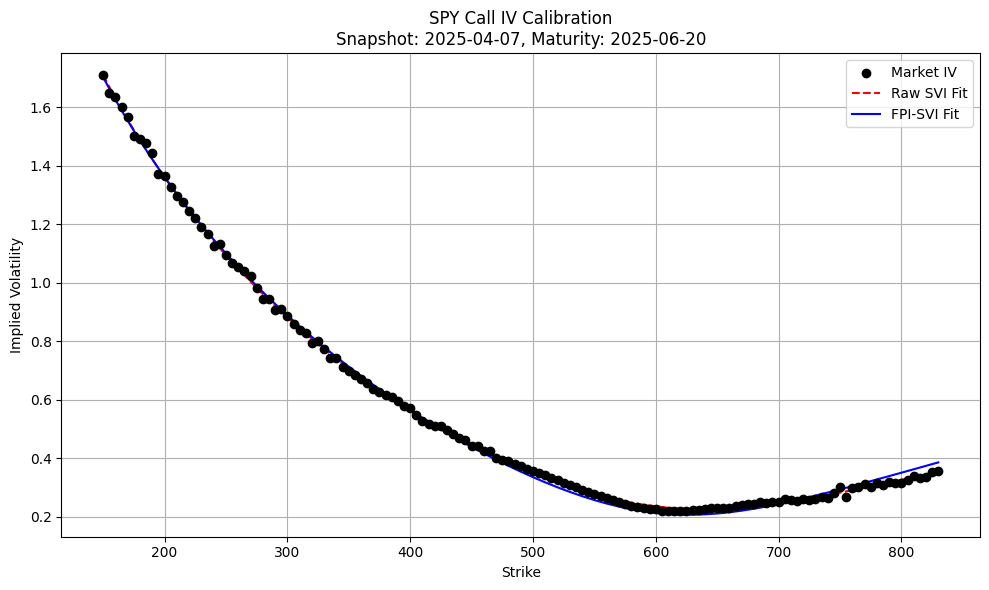

In [51]:
snapshot = '2025-04-07'
maturity = '2025-06-20'

# Get market IVs and strikes
market_iv = spy_call.sel(snapshot_date=snapshot, maturity=maturity).values
strikes = spy_call.coords['strike'].values.astype(float)

# Filter valid IVs
mask = (~np.isnan(market_iv)) & (market_iv > 0)
strikes_valid = strikes[mask]
market_iv_valid = market_iv[mask]

# --- Raw SVI Fit ---
params_raw = RawSVI_spy_call_params.sel(snapshot_date=snapshot, maturity=maturity).values
a_raw, b_raw, rho_raw, m_raw, sigma_raw, T_raw, F_raw = params_raw
iv_fit_raw = RawSVI_calibration(strikes_valid, a_raw, b_raw, rho_raw, m_raw, sigma_raw, T_raw, F_raw)/np.sqrt(T_raw)

# --- FPI-SVI Fit ---
params_fpi = FPISVI_spy_call_params.sel(snapshot_date=snapshot, maturity=maturity).values
a_fpi, b_fpi, rho_fpi, m_fpi, sigma_fpi, T_fpi, F_fpi = params_fpi
iv_fit_fpi = RawSVI_calibration(strikes_valid, a_fpi, b_fpi, rho_fpi, m_fpi, sigma_fpi, T_fpi, F_fpi)/np.sqrt(T_fpi)

# --- Plot ---
plt.figure(figsize=(10, 6))
plt.scatter(strikes_valid, market_iv_valid, color='black', label='Market IV', zorder=5)
plt.plot(strikes_valid, iv_fit_raw, 'r--', label='Raw SVI Fit')
plt.plot(strikes_valid, iv_fit_fpi, 'b-', label='FPI-SVI Fit')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.title(f'SPY Call IV Calibration\nSnapshot: {snapshot}, Maturity: {maturity}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Computing Theoretical prices

###Black-Scholes Formula

In [52]:
from scipy.stats import norm

def black_scholes_price(option_type, S, K, T, r, sigma):
    """
    Calculates the Black-Scholes option price.

    Parameters:
    - option_type: 'call' or 'put'
    - S: Spot price of the underlying asset
    - K: Strike price
    - T: Time to maturity (in years)
    - r: Risk-free interest rate
    - sigma: Implied volatility

    Returns:
    - Option price
    """
    d1 = (np.log(S / K) + (r + sigma ** 2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return price

###SABR


DataFrame with SABR Volatility:
   strike  premium snapshot_date    maturity     alpha       rho    sigma0  \
0   150.0  359.320    2025-04-07  2025-06-20  4.100412 -0.908767  0.346942   
1   155.0  354.130    2025-04-07  2025-06-20  4.100412 -0.908767  0.346942   
2   160.0  349.535    2025-04-07  2025-06-20  4.100412 -0.908767  0.346942   
3   165.0  344.660    2025-04-07  2025-06-20  4.100412 -0.908767  0.346942   
4   170.0  339.730    2025-04-07  2025-06-20  4.100412 -0.908767  0.346942   

         T        F        spot         r     sabr_volatility  
0  0.20274  509.725  504.380005  0.031975  1.5641788457423471  
1  0.20274  509.725  504.380005  0.031975  1.5363662585569104  
2  0.20274  509.725  504.380005  0.031975  1.5092930974222427  
3  0.20274  509.725  504.380005  0.031975    1.48291348548343  
4  0.20274  509.725  504.380005  0.031975  1.4571855477883988  

DataFrame with SABR Black-Scholes Price:
   strike  premium snapshot_date    maturity     alpha       rho    sigm

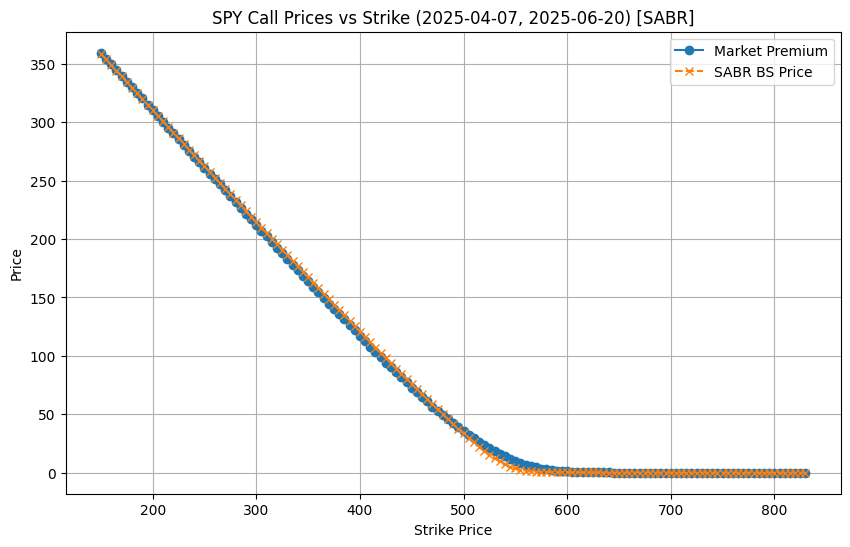

<ipython-input-53-4f86a57d0e95>:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df_sabr['price_diff'] = plot_df_sabr['premium'] - plot_df_sabr['bs_price']


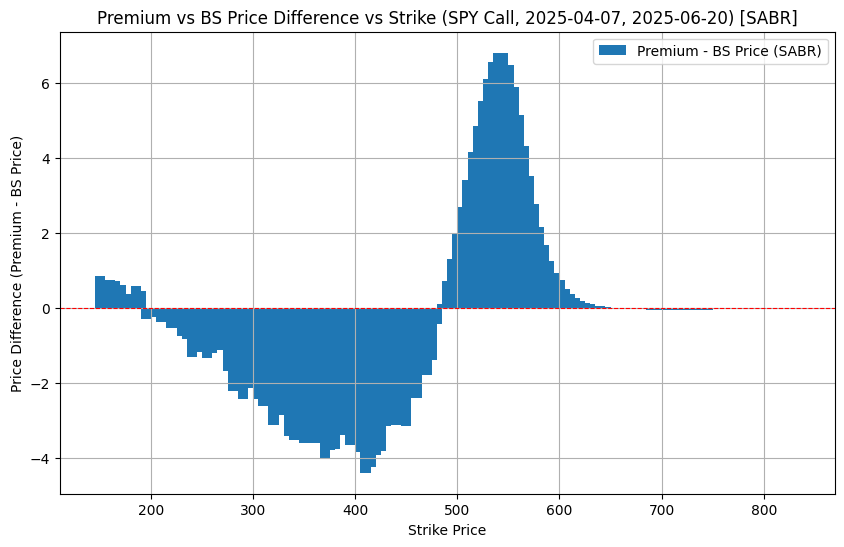


Statistics for Premium vs SABR BS Price Difference (SPY Call, 2025-04-07, 2025-06-20):
Mean Difference: -0.3268
Median Difference: -0.0456
Standard Deviation of Difference: 2.4511
Mean Absolute Error (MAE): 1.6751
Root Mean Squared Error (RMSE): 2.4639


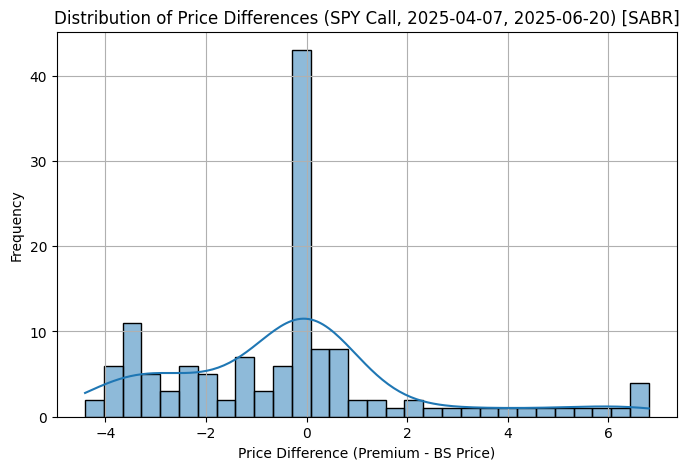

In [53]:

# Define your desired parameters for SABR price calculation
snapshot = '2025-04-07'  # Example snapshot date
maturity = '2025-06-20'  # Example maturity date
option_type = 'Call'      # 'Call' or 'Put'
asset = 'SPY'             # 'SPY' or 'QQQ'

# 1. Get strikes and premium data for the given parameters from premium_data
premium_key = f"{asset}_{option_type}"
if premium_key not in premium_data:
    raise ValueError(f"Premium data not found for {premium_key}")

try:
    premium_slice = premium_data[premium_key].sel(snapshot_date=snapshot, maturity=maturity)
    strikes = premium_slice.coords['strike'].values
    premiums = premium_slice.values
except KeyError:
    print(f"Premium data not available for {premium_key} on {snapshot} with maturity {maturity}")
    strikes = np.array([])
    premiums = np.array([])

# Create a DataFrame for premium data
premium_df_sabr = pd.DataFrame({
    'strike': strikes,
    'premium': premiums
})

# 2. Get SABR parameters for the given parameters from SABR_xxx_xxx_params
sabr_params_key = f"SABR_{asset}_{option_type.lower()}_params"

# Access the correct SABR parameters DataArray
if asset == 'SPY':
    if option_type == 'Call':
        sabr_params_da = SABR_spy_call_params
    elif option_type == 'Put':
        sabr_params_da = SABR_spy_put_params
    else:
         sabr_params_da = None
elif asset == 'QQQ':
    if option_type == 'Call':
        sabr_params_da = SABR_qqq_call_params
    elif option_type == 'Put':
        sabr_params_da = SABR_qqq_put_params
    else:
         sabr_params_da = None
else:
    sabr_params_da = None


sabr_params_df = pd.DataFrame()
if sabr_params_da is not None:
    try:
        # Select the slice for the specific snapshot and maturity
        params_slice = sabr_params_da.sel(snapshot_date=snapshot, maturity=maturity)

        # Convert the slice into a DataFrame suitable for merging.
        sabr_params_df = params_slice.to_dataframe(name='param_value').reset_index()

        # Pivot to get parameters as columns
        sabr_params_df = sabr_params_df.pivot(index=['snapshot_date', 'maturity'], columns='parameter', values='param_value')
        sabr_params_df = sabr_params_df.reset_index()

        # Keep only the relevant parameter columns and drop any NaNs if the calibration failed
        sabr_params_df = sabr_params_df[['snapshot_date', 'maturity', 'alpha', 'rho', 'sigma0', 'T', 'F']].dropna()

    except KeyError:
         print(f"SABR parameters not available for {asset}_{option_type} on {snapshot} with maturity {maturity}")
         sabr_params_df = pd.DataFrame() # Ensure it's an empty DataFrame if not found


# 3. Merge the dataframes

# Add snapshot and maturity columns to premium_df_sabr to facilitate merging
if not premium_df_sabr.empty:
    premium_df_sabr['snapshot_date'] = snapshot
    premium_df_sabr['maturity'] = maturity

if not sabr_params_df.empty and not premium_df_sabr.empty:
    # The sabr_params_df should only have one row for the target snapshot/maturity
    # We can merge this row onto every row in the premium_df_sabr
    merged_df_sabr = pd.merge(premium_df_sabr, sabr_params_df, on=['snapshot_date', 'maturity'], how='left')
else:
    print("Could not merge data. Check if premium data or SABR parameters were found.")
    merged_df_sabr = pd.DataFrame() # Return empty if merge is not possible


# 4. Get the spot value (same as before)
spot_value = np.nan
spot_row = spot_data[spot_data['Date'] == snapshot]
if not spot_row.empty:
    if asset == 'SPY':
        spot_value = float(spot_row['SPY'].iloc[0])
    elif asset == 'QQQ':
        spot_value = float(spot_row['QQQ'].iloc[0])
    else:
        print(f"Warning: Spot data not available for asset {asset}")

# Add spot value to the merged dataframe
if not merged_df_sabr.empty:
    merged_df_sabr['spot'] = spot_value
else:
    print("Cannot add spot value: merged_df_sabr is empty.")

# 5. Get the risk-free rate (r) from the theo_ir dataframe (same as before)
r_value = np.nan
if asset in theo_ir:
    try:
        r_da = theo_ir[asset]
        r_slice = r_da.sel(snapshot_date=snapshot, maturity=maturity)
        r_value = r_slice.item()
    except KeyError:
        print(f"Risk-free rate not available for {asset} on {snapshot} with maturity {maturity} in theo_ir")

# Add risk-free rate to the merged dataframe
if not merged_df_sabr.empty:
    merged_df_sabr['r'] = r_value
else:
    print("Cannot add risk-free rate: merged_df_sabr is empty.")


# Calculate SABR implied volatility for each row
if not merged_df_sabr.empty:
    merged_df_sabr['sabr_volatility'] = merged_df_sabr.apply(
        lambda row: SABR_calibration(
            row['strike'], row['alpha'], row['rho'], row['sigma0'], row['T'], row['F']
        ) if pd.notna(row[['alpha', 'rho', 'sigma0', 'T', 'F', 'strike']]).all() and row['T'] > 0 and row['sigma0'] > 0 else np.nan,
        axis=1
    )

    # Print the DataFrame with the new volatility column
    print("\nDataFrame with SABR Volatility:")
    print(merged_df_sabr.head())

else:
    print("Merged DataFrame (SABR) is empty, cannot compute volatility.")


if not merged_df_sabr.empty:
    # Calculate Black-Scholes price using SABR volatility for each row
    merged_df_sabr['bs_price'] = merged_df_sabr.apply(
        lambda row: black_scholes_price(
            option_type.lower(), # 'call' or 'put'
            row['spot'],          # S
            row['strike'],       # K
            row['T'],             # T (Time to maturity)
            row['r'],             # r (Risk-free rate)
            row['sabr_volatility'] # sigma (using the calculated SABR vol)
        ) if pd.notna(row[['spot', 'strike', 'T', 'r', 'sabr_volatility']]).all() and row['T'] > 0 and row['sabr_volatility'] > 0 else np.nan,
        axis=1
    )

    # Print the DataFrame with the new Black-Scholes price column
    print("\nDataFrame with SABR Black-Scholes Price:")
    print(merged_df_sabr.head())
else:
    print("Merged DataFrame (SABR) is empty, cannot compute Black-Scholes price.")


# Remove rows where either 'premium' or 'bs_price' is NaN for plotting (SABR)
plot_df_sabr = merged_df_sabr.dropna(subset=['premium', 'bs_price'])

if not plot_df_sabr.empty:
    # Plotting Premium vs BS Price against Strike (SABR)
    plt.figure(figsize=(10, 6))
    plt.plot(plot_df_sabr['strike'], plot_df_sabr['premium'], marker='o', linestyle='-', label='Market Premium')
    plt.plot(plot_df_sabr['strike'], plot_df_sabr['bs_price'], marker='x', linestyle='--', label='SABR BS Price')

    plt.title(f'{asset} {option_type} Prices vs Strike ({snapshot}, {maturity}) [SABR]')
    plt.xlabel('Strike Price')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data points to plot (SABR).")

# Optional: Plot the difference between premium and BS price (SABR)
if not plot_df_sabr.empty:
    plot_df_sabr['price_diff'] = plot_df_sabr['premium'] - plot_df_sabr['bs_price']

    plt.figure(figsize=(10, 6))
    plt.bar(plot_df_sabr['strike'], plot_df_sabr['price_diff'], width=10, label='Premium - BS Price (SABR)')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Add a zero line
    plt.title(f'Premium vs BS Price Difference vs Strike ({asset} {option_type}, {snapshot}, {maturity}) [SABR]')
    plt.xlabel('Strike Price')
    plt.ylabel('Price Difference (Premium - BS Price)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data points to plot the price difference (SABR).")


if not plot_df_sabr.empty:
    # Calculate statistics for the difference (SABR)
    mean_diff = plot_df_sabr['price_diff'].mean()
    median_diff = plot_df_sabr['price_diff'].median()
    std_diff = plot_df_sabr['price_diff'].std()
    mae = np.mean(np.abs(plot_df_sabr['price_diff'])) # Mean Absolute Error
    rmse = np.sqrt(mean_squared_error(plot_df_sabr['premium'], plot_df_sabr['bs_price'])) # RMSE

    print(f"\nStatistics for Premium vs SABR BS Price Difference ({asset} {option_type}, {snapshot}, {maturity}):")
    print(f"Mean Difference: {mean_diff:.4f}")
    print(f"Median Difference: {median_diff:.4f}")
    print(f"Standard Deviation of Difference: {std_diff:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # Add a distribution plot of the differences (SABR)
    plt.figure(figsize=(8, 5))
    sns.histplot(plot_df_sabr['price_diff'], bins=30, kde=True)
    plt.title(f'Distribution of Price Differences ({asset} {option_type}, {snapshot}, {maturity}) [SABR]')
    plt.xlabel('Price Difference (Premium - BS Price)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

else:
    print("No valid data points to calculate statistics or plot distribution (SABR).")

###RAW SVI


DataFrame with Black-Scholes Price:
   strike  premium snapshot_date    maturity         a         b       rho  \
0   150.0      NaN    2025-04-09  2027-12-17  0.020943  0.194341 -0.092759   
1   155.0      NaN    2025-04-09  2027-12-17  0.020943  0.194341 -0.092759   
2   160.0      NaN    2025-04-09  2027-12-17  0.020943  0.194341 -0.092759   
3   165.0      NaN    2025-04-09  2027-12-17  0.020943  0.194341 -0.092759   
4   170.0      NaN    2025-04-09  2027-12-17  0.020943  0.194341 -0.092759   

          m         sigma         T        F        spot         r  \
0  0.335914  1.055575e-07  2.690411  589.025  548.619995  0.039547   
1  0.335914  1.055575e-07  2.690411  589.025  548.619995  0.039547   
2  0.335914  1.055575e-07  2.690411  589.025  548.619995  0.039547   
3  0.335914  1.055575e-07  2.690411  589.025  548.619995  0.039547   
4  0.335914  1.055575e-07  2.690411  589.025  548.619995  0.039547   

   rawsvi_volatility    bs_price  
0           0.377187  414.410687  
1  

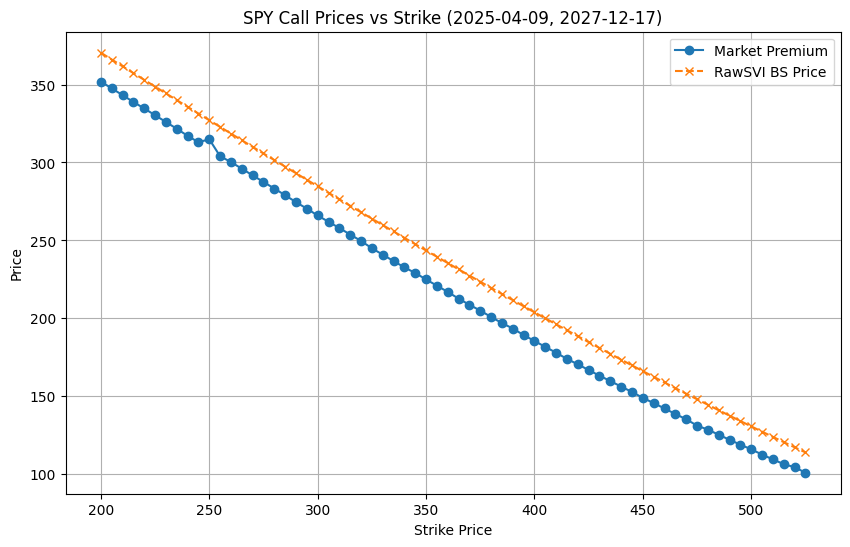

<ipython-input-54-8d963ca8caa6>:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['price_diff'] = plot_df['premium'] - plot_df['bs_price']


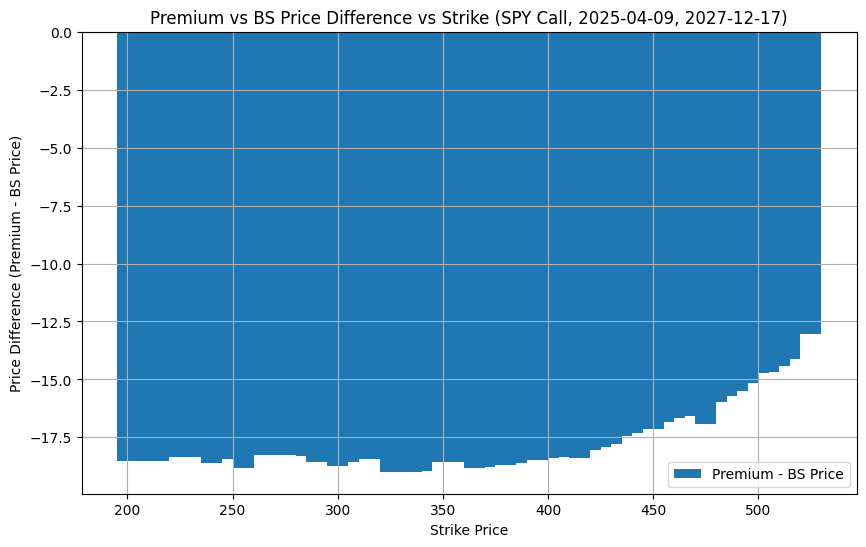


Statistics for Premium vs RawSVI BS Price Difference (SPY Call, 2025-04-09, 2027-12-17):
Mean Difference: -17.5810
Median Difference: -18.3321
Standard Deviation of Difference: 1.6260
Mean Absolute Error (MAE): 17.5810
Root Mean Squared Error (RMSE): 17.6549


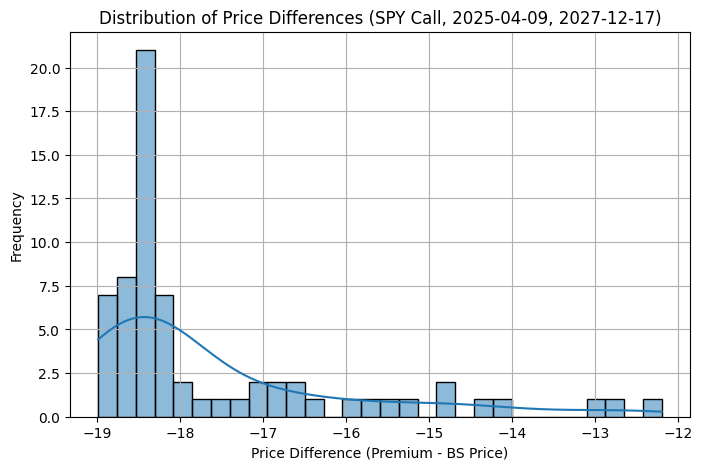

In [54]:

# Define your desired parameters
snapshot = '2025-04-09'  # Example snapshot date
maturity = '2027-12-17'  # Example maturity date
option_type = 'Call'      # 'Call' or 'Put'
asset = 'SPY'             # 'SPY' or 'QQQ'

# 1. Get strikes and premium data for the given parameters from premium_data
premium_key = f"{asset}_{option_type}"
if premium_key not in premium_data:
    raise ValueError(f"Premium data not found for {premium_key}")

try:
    premium_slice = premium_data[premium_key].sel(snapshot_date=snapshot, maturity=maturity)
    strikes = premium_slice.coords['strike'].values
    premiums = premium_slice.values
except KeyError:
    print(f"Premium data not available for {premium_key} on {snapshot} with maturity {maturity}")
    strikes = np.array([])
    premiums = np.array([])

# Create a DataFrame for premium data
premium_df = pd.DataFrame({
    'strike': strikes,
    'premium': premiums
})

# Remove rows where premium is NaN (this is important for the merge)
#premium_df = premium_df.dropna(subset=['premium'])


# 2. Get RawSVI parameters for the given parameters from RawSVI_xxx_xxx_params
rawsvi_params_key = f"RawSVI_{asset}_{option_type.lower()}_params"

# Access the correct RawSVI parameters DataArray
if asset == 'SPY':
    if option_type == 'Call':
        rawsvi_params_da = RawSVI_spy_call_params
    elif option_type == 'Put':
        rawsvi_params_da = RawSVI_spy_put_params
    else:
         rawsvi_params_da = None
elif asset == 'QQQ':
    if option_type == 'Call':
        rawsvi_params_da = RawSVI_qqq_call_params
    elif option_type == 'Put':
        rawsvi_params_da = RawSVI_qqq_put_params
    else:
         rawsvi_params_da = None
else:
    rawsvi_params_da = None


rawsvi_params_df = pd.DataFrame()
if rawsvi_params_da is not None:
    try:
        # Select the slice for the specific snapshot and maturity
        params_slice = rawsvi_params_da.sel(snapshot_date=snapshot, maturity=maturity)

        # Convert the slice (which is now just a single point for snapshot/maturity)
        # into a DataFrame suitable for merging. It has a 'parameter' dimension.
        rawsvi_params_df = params_slice.to_dataframe(name='param_value').reset_index()

        # Pivot to get parameters as columns
        rawsvi_params_df = rawsvi_params_df.pivot(index=['snapshot_date', 'maturity'], columns='parameter', values='param_value')
        rawsvi_params_df = rawsvi_params_df.reset_index()

        # Keep only the relevant parameter columns and drop any NaNs if the calibration failed
        rawsvi_params_df = rawsvi_params_df[['snapshot_date', 'maturity', 'a', 'b', 'rho', 'm', 'sigma', 'T', 'F']].dropna()

    except KeyError:
         print(f"RawSVI parameters not available for {asset}_{option_type} on {snapshot} with maturity {maturity}")
         rawsvi_params_df = pd.DataFrame() # Ensure it's an empty DataFrame if not found


# 3. Merge the dataframes

# Add snapshot and maturity columns to premium_df to facilitate merging
if not premium_df.empty:
    premium_df['snapshot_date'] = snapshot
    premium_df['maturity'] = maturity

if not rawsvi_params_df.empty and not premium_df.empty:
    # The rawsvi_params_df should only have one row for the target snapshot/maturity
    # We can merge this row onto every row in the premium_df
    merged_df = pd.merge(premium_df, rawsvi_params_df, on=['snapshot_date', 'maturity'], how='left')
else:
    print("Could not merge data. Check if premium data or RawSVI parameters were found.")
    merged_df = pd.DataFrame() # Return empty if merge is not possible

# 4. Get the spot value
# Find the spot price for the given snapshot date and asset
spot_value = np.nan
spot_row = spot_data[spot_data['Date'] == snapshot]
if not spot_row.empty:
    if asset == 'SPY':
        spot_value = float(spot_row['SPY'].iloc[0])
    elif asset == 'QQQ':
        spot_value = float(spot_row['QQQ'].iloc[0])
    else:
        print(f"Warning: Spot data not available for asset {asset}")

# Add spot value to the merged dataframe
if not merged_df.empty:
    merged_df['spot'] = spot_value
else:
    print("Cannot add spot value: merged_df is empty.")

# 5. Get the risk-free rate (r) from the theo_ir dataframe
r_value = np.nan
if asset in theo_ir:
    try:
        # theo_ir is an xarray DataArray
        r_da = theo_ir[asset]
        # Select the specific snapshot and maturity
        r_slice = r_da.sel(snapshot_date=snapshot, maturity=maturity)
        r_value = r_slice.item() # Use .item() to get the scalar value
    except KeyError:
        print(f"Risk-free rate not available for {asset} on {snapshot} with maturity {maturity} in theo_ir")

# Add risk-free rate to the merged dataframe
if not merged_df.empty:
    merged_df['r'] = r_value
else:
    print("Cannot add risk-free rate: merged_df is empty.")


# # Final Merged DataFrame with all required data
# print("\nFinal Merged DataFrame with Spot and Interest Rate:")
# print(merged_df.head())

if not merged_df.empty:
    # Calculate RawSVI implied volatility for each row
    # The RawSVI_calibration function returns total variance (sigma^2 * T), so we divide by sqrt(T)
    merged_df['rawsvi_volatility'] = merged_df.apply(
        lambda row: RawSVI_calibration(
            row['strike'], row['a'], row['b'], row['rho'], row['m'], row['sigma'], row['T'], row['F']
        ) / np.sqrt(row['T']) if pd.notna(row[['a', 'b', 'rho', 'm', 'sigma', 'T', 'F', 'strike']]).all() and row['T'] > 0 else np.nan,
        axis=1
    )

#     # Print the DataFrame with the new volatility column
#     print("\nDataFrame with RawSVI Volatility:")
#     print(merged_df.head())

# else:
#     print("Merged DataFrame is empty, cannot compute volatility.")

if not merged_df.empty:
    # Calculate Black-Scholes price for each row
    # Ensure all required inputs are available and valid
    merged_df['bs_price'] = merged_df.apply(
        lambda row: black_scholes_price(
            option_type.lower(), # 'call' or 'put'
            row['spot'],          # S
            row['strike'],       # K
            row['T'],             # T (Time to maturity)
            row['r'],             # r (Risk-free rate)
            row['rawsvi_volatility'] # sigma (using the calculated RawSVI vol)
        ) if pd.notna(row[['spot', 'strike', 'T', 'r', 'rawsvi_volatility']]).all() and row['T'] > 0 and row['rawsvi_volatility'] > 0 else np.nan,
        axis=1
    )

    # Print the DataFrame with the new Black-Scholes price column
    print("\nDataFrame with Black-Scholes Price:")
    print(merged_df.head())
else:
    print("Merged DataFrame is empty, cannot compute Black-Scholes price.")


# Remove rows where either 'premium' or 'bs_price' is NaN for plotting
plot_df = merged_df.dropna(subset=['premium', 'bs_price'])

if not plot_df.empty:
    # Plotting Premium vs BS Price against Strike
    plt.figure(figsize=(10, 6))
    plt.plot(plot_df['strike'], plot_df['premium'], marker='o', linestyle='-', label='Market Premium')
    plt.plot(plot_df['strike'], plot_df['bs_price'], marker='x', linestyle='--', label='RawSVI BS Price')

    plt.title(f'{asset} {option_type} Prices vs Strike ({snapshot}, {maturity})')
    plt.xlabel('Strike Price')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data points to plot.")

# Optional: Plot the difference between premium and BS price
if not plot_df.empty:
    plot_df['price_diff'] = plot_df['premium'] - plot_df['bs_price']

    plt.figure(figsize=(10, 6))
    plt.bar(plot_df['strike'], plot_df['price_diff'], width=10, label='Premium - BS Price')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Add a zero line
    plt.title(f'Premium vs BS Price Difference vs Strike ({asset} {option_type}, {snapshot}, {maturity})')
    plt.xlabel('Strike Price')
    plt.ylabel('Price Difference (Premium - BS Price)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data points to plot the price difference.")

# prompt: i want to add some statistics to see the diference

if not plot_df.empty:
    # Calculate statistics for the difference
    mean_diff = plot_df['price_diff'].mean()
    median_diff = plot_df['price_diff'].median()
    std_diff = plot_df['price_diff'].std()
    mae = np.mean(np.abs(plot_df['price_diff'])) # Mean Absolute Error
    rmse = np.sqrt(mean_squared_error(plot_df['premium'], plot_df['bs_price'])) # RMSE

    print(f"\nStatistics for Premium vs RawSVI BS Price Difference ({asset} {option_type}, {snapshot}, {maturity}):")
    print(f"Mean Difference: {mean_diff:.4f}")
    print(f"Median Difference: {median_diff:.4f}")
    print(f"Standard Deviation of Difference: {std_diff:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # Add a distribution plot of the differences
    plt.figure(figsize=(8, 5))
    sns.histplot(plot_df['price_diff'], bins=30, kde=True)
    plt.title(f'Distribution of Price Differences ({asset} {option_type}, {snapshot}, {maturity})')
    plt.xlabel('Price Difference (Premium - BS Price)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

else:
    print("No valid data points to calculate statistics or plot distribution.")



###Natural SVI


DataFrame with Natural SVI Volatility:
   strike  premium snapshot_date    maturity  delta        mu       rho  \
0   150.0  359.320    2025-04-07  2025-06-20   -2.0 -1.187799 -0.462591   
1   155.0  354.130    2025-04-07  2025-06-20   -2.0 -1.187799 -0.462591   
2   160.0  349.535    2025-04-07  2025-06-20   -2.0 -1.187799 -0.462591   
3   165.0  344.660    2025-04-07  2025-06-20   -2.0 -1.187799 -0.462591   
4   170.0  339.730    2025-04-07  2025-06-20   -2.0 -1.187799 -0.462591   

      omega       ksi        T        F        spot         r  \
0  2.557966  0.655808  0.20274  509.725  504.380005  0.031975   
1  2.557966  0.655808  0.20274  509.725  504.380005  0.031975   
2  2.557966  0.655808  0.20274  509.725  504.380005  0.031975   
3  2.557966  0.655808  0.20274  509.725  504.380005  0.031975   
4  2.557966  0.655808  0.20274  509.725  504.380005  0.031975   

   natsvi_volatility  
0           1.699734  
1           1.662008  
2           1.625316  
3           1.589607  
4  

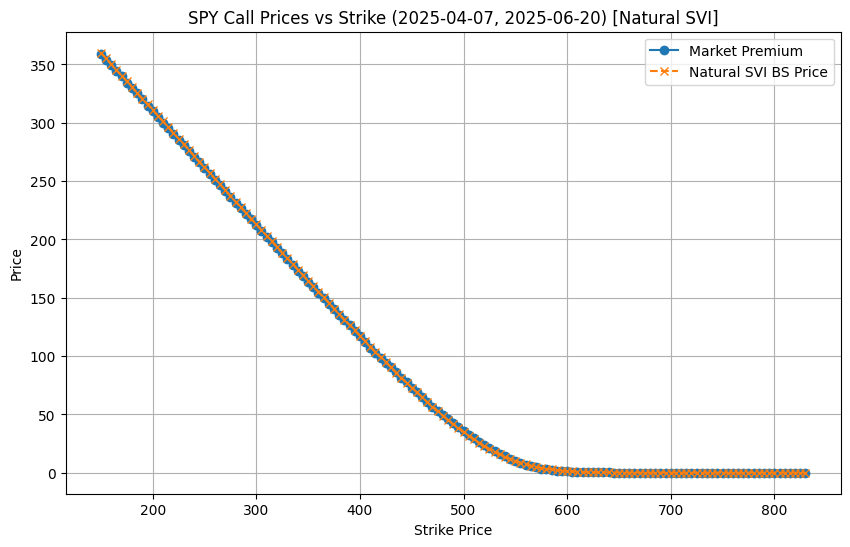

<ipython-input-55-f02d715ffee5>:178: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df_natsvi['price_diff'] = plot_df_natsvi['premium'] - plot_df_natsvi['bs_price']


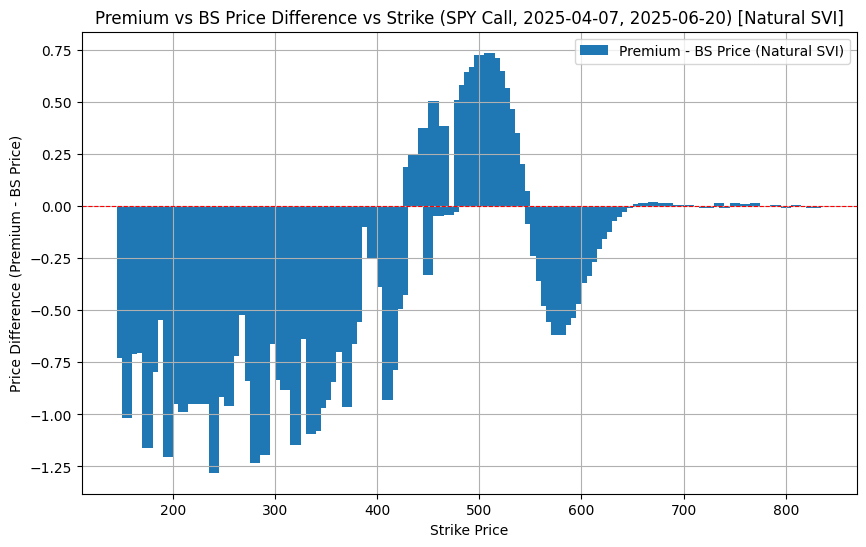


Statistics for Premium vs Natural SVI BS Price Difference (SPY Call, 2025-04-07, 2025-06-20):
Mean Difference: -0.2878
Median Difference: -0.1226
Standard Deviation of Difference: 0.4965
Mean Absolute Error (MAE): 0.4273
Root Mean Squared Error (RMSE): 0.5723


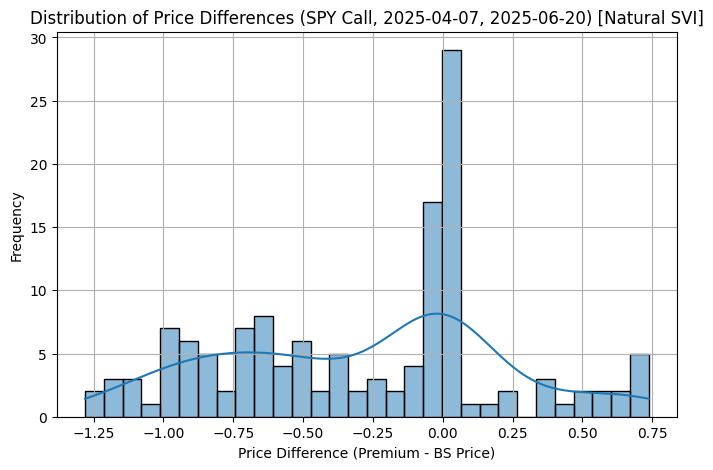

In [55]:

# Define your desired parameters for Natural SVI price calculation
snapshot = '2025-04-07'  # Example snapshot date
maturity = '2025-06-20'  # Example maturity date
option_type = 'Call'      # 'Call' or 'Put'
asset = 'SPY'             # 'SPY' or 'QQQ'

# 1. Get strikes and premium data for the given parameters from premium_data
premium_key = f"{asset}_{option_type}"
if premium_key not in premium_data:
    raise ValueError(f"Premium data not found for {premium_key}")

try:
    premium_slice = premium_data[premium_key].sel(snapshot_date=snapshot, maturity=maturity)
    strikes = premium_slice.coords['strike'].values
    premiums = premium_slice.values
except KeyError:
    print(f"Premium data not available for {premium_key} on {snapshot} with maturity {maturity}")
    strikes = np.array([])
    premiums = np.array([])

# Create a DataFrame for premium data
premium_df_natsvi = pd.DataFrame({
    'strike': strikes,
    'premium': premiums
})

# 2. Get Natural SVI parameters for the given parameters from NaturalSVI_xxx_xxx_params
naturalsvi_params_key = f"NaturalSVI_{asset}_{option_type.lower()}_params"

# Access the correct NaturalSVI parameters DataArray
if asset == 'SPY':
    if option_type == 'Call':
        naturalsvi_params_da = NaturalSVI_spy_call_params
    elif option_type == 'Put':
        naturalsvi_params_da = NaturalSVI_spy_put_params
    else:
         naturalsvi_params_da = None
elif asset == 'QQQ':
    if option_type == 'Call':
        naturalsvi_params_da = NaturalSVI_qqq_call_params
    elif option_type == 'Put':
        naturalsvi_params_da = NaturalSVI_qqq_put_params
    else:
         naturalsvi_params_da = None
else:
    naturalsvi_params_da = None


naturalsvi_params_df = pd.DataFrame()
if naturalsvi_params_da is not None:
    try:
        # Select the slice for the specific snapshot and maturity
        params_slice = naturalsvi_params_da.sel(snapshot_date=snapshot, maturity=maturity)

        # Convert the slice into a DataFrame suitable for merging.
        naturalsvi_params_df = params_slice.to_dataframe(name='param_value').reset_index()

        # Pivot to get parameters as columns
        naturalsvi_params_df = naturalsvi_params_df.pivot(index=['snapshot_date', 'maturity'], columns='parameter', values='param_value')
        naturalsvi_params_df = naturalsvi_params_df.reset_index()

        # Keep only the relevant parameter columns and drop any NaNs if the calibration failed
        naturalsvi_params_df = naturalsvi_params_df[['snapshot_date', 'maturity', 'delta', 'mu', 'rho', 'omega', 'ksi', 'T', 'F']].dropna()

    except KeyError:
         print(f"Natural SVI parameters not available for {asset}_{option_type} on {snapshot} with maturity {maturity}")
         naturalsvi_params_df = pd.DataFrame() # Ensure it's an empty DataFrame if not found


# 3. Merge the dataframes

# Add snapshot and maturity columns to premium_df_natsvi to facilitate merging
if not premium_df_natsvi.empty:
    premium_df_natsvi['snapshot_date'] = snapshot
    premium_df_natsvi['maturity'] = maturity

if not naturalsvi_params_df.empty and not premium_df_natsvi.empty:
    # The naturalsvi_params_df should only have one row for the target snapshot/maturity
    # We can merge this row onto every row in the premium_df_natsvi
    merged_df_natsvi = pd.merge(premium_df_natsvi, naturalsvi_params_df, on=['snapshot_date', 'maturity'], how='left')
else:
    print("Could not merge data. Check if premium data or Natural SVI parameters were found.")
    merged_df_natsvi = pd.DataFrame() # Return empty if merge is not possible


# 4. Get the spot value (same as before)
spot_value = np.nan
spot_row = spot_data[spot_data['Date'] == snapshot]
if not spot_row.empty:
    if asset == 'SPY':
        spot_value = float(spot_row['SPY'].iloc[0])
    elif asset == 'QQQ':
        spot_value = float(spot_row['QQQ'].iloc[0])
    else:
        print(f"Warning: Spot data not available for asset {asset}")

# Add spot value to the merged dataframe
if not merged_df_natsvi.empty:
    merged_df_natsvi['spot'] = spot_value
else:
    print("Cannot add spot value: merged_df_natsvi is empty.")

# 5. Get the risk-free rate (r) from the theo_ir dataframe (same as before)
r_value = np.nan
if asset in theo_ir:
    try:
        r_da = theo_ir[asset]
        r_slice = r_da.sel(snapshot_date=snapshot, maturity=maturity)
        r_value = r_slice.item()
    except KeyError:
        print(f"Risk-free rate not available for {asset} on {snapshot} with maturity {maturity} in theo_ir")

# Add risk-free rate to the merged dataframe
if not merged_df_natsvi.empty:
    merged_df_natsvi['r'] = r_value
else:
    print("Cannot add risk-free rate: merged_df_natsvi is empty.")


# Calculate Natural SVI implied volatility for each row
if not merged_df_natsvi.empty:
    merged_df_natsvi['natsvi_volatility'] = merged_df_natsvi.apply(
        lambda row: NaturalSVI_calibration(
            row['strike'], row['delta'], row['mu'], row['rho'], row['omega'], row['ksi'], row['T'], row['F']
        ) / np.sqrt(row['T']) if pd.notna(row[['delta', 'mu', 'rho', 'omega', 'ksi', 'T', 'F', 'strike']]).all() and row['T'] > 0 else np.nan,
        axis=1
    )

    # Print the DataFrame with the new volatility column
    print("\nDataFrame with Natural SVI Volatility:")
    print(merged_df_natsvi.head())

else:
    print("Merged DataFrame (Natural SVI) is empty, cannot compute volatility.")


if not merged_df_natsvi.empty:
    # Calculate Black-Scholes price using Natural SVI volatility for each row
    merged_df_natsvi['bs_price'] = merged_df_natsvi.apply(
        lambda row: black_scholes_price(
            option_type.lower(), # 'call' or 'put'
            row['spot'],          # S
            row['strike'],       # K
            row['T'],             # T (Time to maturity)
            row['r'],             # r (Risk-free rate)
            row['natsvi_volatility'] # sigma (using the calculated Natural SVI vol)
        ) if pd.notna(row[['spot', 'strike', 'T', 'r', 'natsvi_volatility']]).all() and row['T'] > 0 and row['natsvi_volatility'] > 0 else np.nan,
        axis=1
    )

    # Print the DataFrame with the new Black-Scholes price column
    print("\nDataFrame with Natural SVI Black-Scholes Price:")
    print(merged_df_natsvi.head())
else:
    print("Merged DataFrame (Natural SVI) is empty, cannot compute Black-Scholes price.")


# Remove rows where either 'premium' or 'bs_price' is NaN for plotting (Natural SVI)
plot_df_natsvi = merged_df_natsvi.dropna(subset=['premium', 'bs_price'])

if not plot_df_natsvi.empty:
    # Plotting Premium vs BS Price against Strike (Natural SVI)
    plt.figure(figsize=(10, 6))
    plt.plot(plot_df_natsvi['strike'], plot_df_natsvi['premium'], marker='o', linestyle='-', label='Market Premium')
    plt.plot(plot_df_natsvi['strike'], plot_df_natsvi['bs_price'], marker='x', linestyle='--', label='Natural SVI BS Price')

    plt.title(f'{asset} {option_type} Prices vs Strike ({snapshot}, {maturity}) [Natural SVI]')
    plt.xlabel('Strike Price')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data points to plot (Natural SVI).")

# Optional: Plot the difference between premium and BS price (Natural SVI)
if not plot_df_natsvi.empty:
    plot_df_natsvi['price_diff'] = plot_df_natsvi['premium'] - plot_df_natsvi['bs_price']

    plt.figure(figsize=(10, 6))
    plt.bar(plot_df_natsvi['strike'], plot_df_natsvi['price_diff'], width=10, label='Premium - BS Price (Natural SVI)')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Add a zero line
    plt.title(f'Premium vs BS Price Difference vs Strike ({asset} {option_type}, {snapshot}, {maturity}) [Natural SVI]')
    plt.xlabel('Strike Price')
    plt.ylabel('Price Difference (Premium - BS Price)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data points to plot the price difference (Natural SVI).")


if not plot_df_natsvi.empty:
    # Calculate statistics for the difference (Natural SVI)
    mean_diff = plot_df_natsvi['price_diff'].mean()
    median_diff = plot_df_natsvi['price_diff'].median()
    std_diff = plot_df_natsvi['price_diff'].std()
    mae = np.mean(np.abs(plot_df_natsvi['price_diff'])) # Mean Absolute Error
    rmse = np.sqrt(mean_squared_error(plot_df_natsvi['premium'], plot_df_natsvi['bs_price'])) # RMSE

    print(f"\nStatistics for Premium vs Natural SVI BS Price Difference ({asset} {option_type}, {snapshot}, {maturity}):")
    print(f"Mean Difference: {mean_diff:.4f}")
    print(f"Median Difference: {median_diff:.4f}")
    print(f"Standard Deviation of Difference: {std_diff:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # Add a distribution plot of the differences (Natural SVI)
    plt.figure(figsize=(8, 5))
    sns.histplot(plot_df_natsvi['price_diff'], bins=30, kde=True)
    plt.title(f'Distribution of Price Differences ({asset} {option_type}, {snapshot}, {maturity}) [Natural SVI]')
    plt.xlabel('Price Difference (Premium - BS Price)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

else:
    print("No valid data points to calculate statistics or plot distribution (Natural SVI).")



### FPI-SVI


DataFrame with FPI-SVI Volatility:
   strike  premium snapshot_date    maturity            a            b  \
0   150.0  359.320    2025-04-07  2025-06-20 -1081.092341  4950.586377   
1   155.0  354.130    2025-04-07  2025-06-20 -1081.092341  4950.586377   
2   160.0  349.535    2025-04-07  2025-06-20 -1081.092341  4950.586377   
3   165.0  344.660    2025-04-07  2025-06-20 -1081.092341  4950.586377   
4   170.0  339.730    2025-04-07  2025-06-20 -1081.092341  4950.586377   

        rho          m     sigma        T        F        spot         r  \
0 -0.997537 -44.073584  3.113484  0.20274  509.725  504.380005  0.031975   
1 -0.997537 -44.073584  3.113484  0.20274  509.725  504.380005  0.031975   
2 -0.997537 -44.073584  3.113484  0.20274  509.725  504.380005  0.031975   
3 -0.997537 -44.073584  3.113484  0.20274  509.725  504.380005  0.031975   
4 -0.997537 -44.073584  3.113484  0.20274  509.725  504.380005  0.031975   

   fpi_svi_volatility  
0            0.767038  
1            0

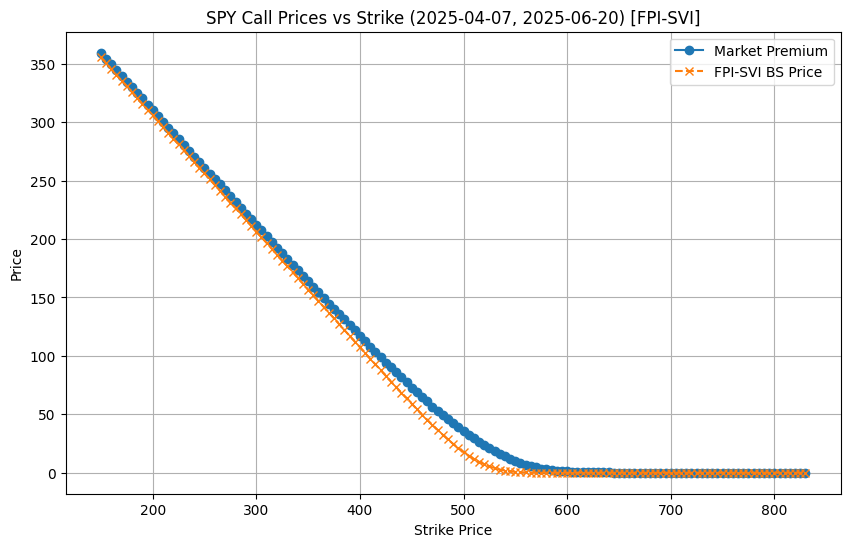

<ipython-input-56-4d1b205855bf>:176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df_fpi['price_diff'] = plot_df_fpi['premium'] - plot_df_fpi['bs_price']


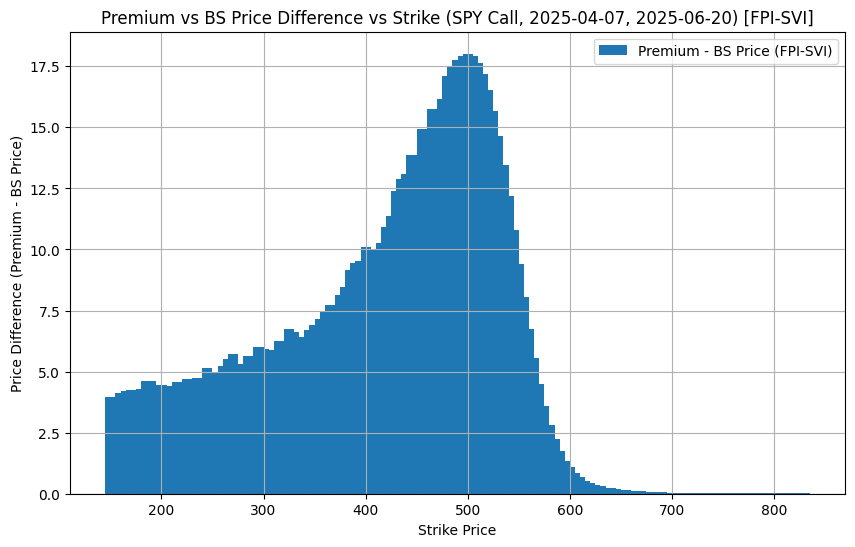


Statistics for Premium vs FPI-SVI BS Price Difference (SPY Call, 2025-04-07, 2025-06-20):
Mean Difference: 5.6060
Median Difference: 4.6299
Standard Deviation of Difference: 5.4969
Mean Absolute Error (MAE): 5.6060
Root Mean Squared Error (RMSE): 7.8372


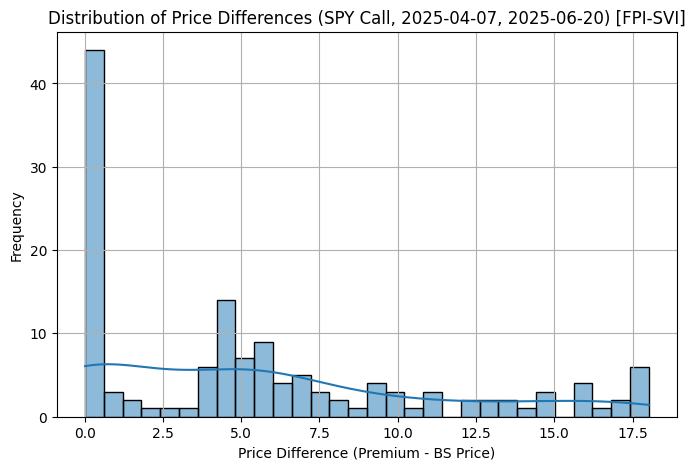

In [56]:
# Define your desired parameters for FPI-SVI price calculation
snapshot = '2025-04-07'  # Example snapshot date
maturity = '2025-06-20'  # Example maturity date
option_type = 'Call'      # 'Call' or 'Put'
asset = 'SPY'             # 'SPY' or 'QQQ'

# 1. Get strikes and premium data for the given parameters from premium_data
premium_key = f"{asset}_{option_type}"
if premium_key not in premium_data:
    raise ValueError(f"Premium data not found for {premium_key}")

try:
    premium_slice = premium_data[premium_key].sel(snapshot_date=snapshot, maturity=maturity)
    strikes = premium_slice.coords['strike'].values
    premiums = premium_slice.values
except KeyError:
    print(f"Premium data not available for {premium_key} on {snapshot} with maturity {maturity}")
    strikes = np.array([])
    premiums = np.array([])

# Create a DataFrame for premium data
premium_df_fpi = pd.DataFrame({
    'strike': strikes,
    'premium': premiums
})

# 2. Get FPI-SVI parameters for the given parameters from FPISVI_xxx_xxx_params
# Access the correct FPISVI parameters DataArray
if asset == 'SPY':
    if option_type == 'Call':
        fpi_params_da = FPISVI_spy_call_params
    elif option_type == 'Put':
        fpi_params_da = FPISVI_spy_put_params
    else:
         fpi_params_da = None
elif asset == 'QQQ':
    if option_type == 'Call':
        fpi_params_da = FPISVI_qqq_call_params
    elif option_type == 'Put':
        fpi_params_da = FPISVI_qqq_put_params
    else:
         fpi_params_da = None
else:
    fpi_params_da = None


fpi_params_df = pd.DataFrame()
if fpi_params_da is not None:
    try:
        # Select the slice for the specific snapshot and maturity
        params_slice = fpi_params_da.sel(snapshot_date=snapshot, maturity=maturity)

        # Convert the slice into a DataFrame suitable for merging.
        fpi_params_df = params_slice.to_dataframe(name='param_value').reset_index()

        # Pivot to get parameters as columns
        fpi_params_df = fpi_params_df.pivot(index=['snapshot_date', 'maturity'], columns='parameter', values='param_value')
        fpi_params_df = fpi_params_df.reset_index()

        # Keep only the relevant parameter columns and drop any NaNs if the calibration failed
        fpi_params_df = fpi_params_df[['snapshot_date', 'maturity', 'a', 'b', 'rho', 'm', 'sigma', 'T', 'F']].dropna()

    except KeyError:
         print(f"FPI-SVI parameters not available for {asset}_{option_type} on {snapshot} with maturity {maturity}")
         fpi_params_df = pd.DataFrame() # Ensure it's an empty DataFrame if not found


# 3. Merge the dataframes

# Add snapshot and maturity columns to premium_df_fpi to facilitate merging
if not premium_df_fpi.empty:
    premium_df_fpi['snapshot_date'] = snapshot
    premium_df_fpi['maturity'] = maturity

if not fpi_params_df.empty and not premium_df_fpi.empty:
    # The fpi_params_df should only have one row for the target snapshot/maturity
    # We can merge this row onto every row in the premium_df_fpi
    merged_df_fpi = pd.merge(premium_df_fpi, fpi_params_df, on=['snapshot_date', 'maturity'], how='left')
else:
    print("Could not merge data. Check if premium data or FPI-SVI parameters were found.")
    merged_df_fpi = pd.DataFrame() # Return empty if merge is not possible


# 4. Get the spot value (same as before)
spot_value = np.nan
spot_row = spot_data[spot_data['Date'] == snapshot]
if not spot_row.empty:
    if asset == 'SPY':
        spot_value = float(spot_row['SPY'].iloc[0])
    elif asset == 'QQQ':
        spot_value = float(spot_row['QQQ'].iloc[0])
    else:
        print(f"Warning: Spot data not available for asset {asset}")

# Add spot value to the merged dataframe
if not merged_df_fpi.empty:
    merged_df_fpi['spot'] = spot_value
else:
    print("Cannot add spot value: merged_df_fpi is empty.")

# 5. Get the risk-free rate (r) from the theo_ir dataframe (same as before)
r_value = np.nan
if asset in theo_ir:
    try:
        r_da = theo_ir[asset]
        r_slice = r_da.sel(snapshot_date=snapshot, maturity=maturity)
        r_value = r_slice.item()
    except KeyError:
        print(f"Risk-free rate not available for {asset} on {snapshot} with maturity {maturity} in theo_ir")

# Add risk-free rate to the merged dataframe
if not merged_df_fpi.empty:
    merged_df_fpi['r'] = r_value
else:
    print("Cannot add risk-free rate: merged_df_fpi is empty.")


# Calculate FPI-SVI implied volatility for each row
if not merged_df_fpi.empty:
    merged_df_fpi['fpi_svi_volatility'] = merged_df_fpi.apply(
        lambda row: RawSVI_calibration(
            row['strike'], row['a'], row['b'], row['rho'], row['m'], row['sigma'], row['T'], row['F']
        ) if pd.notna(row[['a', 'b', 'rho', 'm', 'sigma', 'T', 'F', 'strike']]).all() and row['T'] > 0 else np.nan,
        axis=1
    )

    # Print the DataFrame with the new volatility column
    print("\nDataFrame with FPI-SVI Volatility:")
    print(merged_df_fpi.head())

else:
    print("Merged DataFrame (FPI-SVI) is empty, cannot compute volatility.")


if not merged_df_fpi.empty:
    # Calculate Black-Scholes price using FPI-SVI volatility for each row
    merged_df_fpi['bs_price'] = merged_df_fpi.apply(
        lambda row: black_scholes_price(
            option_type.lower(), # 'call' or 'put'
            row['spot'],          # S
            row['strike'],       # K
            row['T'],             # T (Time to maturity)
            row['r'],             # r (Risk-free rate)
            row['fpi_svi_volatility'] # sigma (using the calculated FPI-SVI vol)
        ) if pd.notna(row[['spot', 'strike', 'T', 'r', 'fpi_svi_volatility']]).all() and row['T'] > 0 and row['fpi_svi_volatility'] > 0 else np.nan,
        axis=1
    )

    # Print the DataFrame with the new Black-Scholes price column
    print("\nDataFrame with FPI-SVI Black-Scholes Price:")
    print(merged_df_fpi.head())
else:
    print("Merged DataFrame (FPI-SVI) is empty, cannot compute Black-Scholes price.")


# Remove rows where either 'premium' or 'bs_price' is NaN for plotting (FPI-SVI)
plot_df_fpi = merged_df_fpi.dropna(subset=['premium', 'bs_price'])

if not plot_df_fpi.empty:
    # Plotting Premium vs BS Price against Strike (FPI-SVI)
    plt.figure(figsize=(10, 6))
    plt.plot(plot_df_fpi['strike'], plot_df_fpi['premium'], marker='o', linestyle='-', label='Market Premium')
    plt.plot(plot_df_fpi['strike'], plot_df_fpi['bs_price'], marker='x', linestyle='--', label='FPI-SVI BS Price')

    plt.title(f'{asset} {option_type} Prices vs Strike ({snapshot}, {maturity}) [FPI-SVI]')
    plt.xlabel('Strike Price')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data points to plot (FPI-SVI).")

# Optional: Plot the difference between premium and BS price (FPI-SVI)
if not plot_df_fpi.empty:
    plot_df_fpi['price_diff'] = plot_df_fpi['premium'] - plot_df_fpi['bs_price']

    plt.figure(figsize=(10, 6))
    plt.bar(plot_df_fpi['strike'], plot_df_fpi['price_diff'], width=10, label='Premium - BS Price (FPI-SVI)')
    plt.axhline(0, color='red', linestyle='--', linewidth=0.8) # Add a zero line
    plt.title(f'Premium vs BS Price Difference vs Strike ({asset} {option_type}, {snapshot}, {maturity}) [FPI-SVI]')
    plt.xlabel('Strike Price')
    plt.ylabel('Price Difference (Premium - BS Price)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No valid data points to plot the price difference (FPI-SVI).")


if not plot_df_fpi.empty:
    # Calculate statistics for the difference (FPI-SVI)
    mean_diff = plot_df_fpi['price_diff'].mean()
    median_diff = plot_df_fpi['price_diff'].median()
    std_diff = plot_df_fpi['price_diff'].std()
    mae = np.mean(np.abs(plot_df_fpi['price_diff'])) # Mean Absolute Error
    rmse = np.sqrt(mean_squared_error(plot_df_fpi['premium'], plot_df_fpi['bs_price'])) # RMSE

    print(f"\nStatistics for Premium vs FPI-SVI BS Price Difference ({asset} {option_type}, {snapshot}, {maturity}):")
    print(f"Mean Difference: {mean_diff:.4f}")
    print(f"Median Difference: {median_diff:.4f}")
    print(f"Standard Deviation of Difference: {std_diff:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    # Add a distribution plot of the differences (FPI-SVI)
    plt.figure(figsize=(8, 5))
    sns.histplot(plot_df_fpi['price_diff'], bins=30, kde=True)
    plt.title(f'Distribution of Price Differences ({asset} {option_type}, {snapshot}, {maturity}) [FPI-SVI]')
    plt.xlabel('Price Difference (Premium - BS Price)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

else:
    print("No valid data points to calculate statistics or plot distribution (FPI-SVI).")

###MSE PRICES

In [57]:


def compute_bs_price_mse(premium_data_xr, params_xr_dict, model_name, option_type, asset, spot_data_df, ir_data_dict):
    """
    Computes the Mean Squared Error (MSE) of Black-Scholes prices
    derived from model-calibrated volatilities against market premiums
    for a given option type and asset, across all snapshots and maturities.

    Parameters:
    - premium_data_xr: xarray DataArray containing market premiums
                       (dims: snapshot_date, maturity, strike)
    - params_xr_dict: Dictionary where keys are parameter names (e.g., 'alpha', 'rho')
                      and values are xarray DataArrays containing the calibrated parameters.
                      (dims: snapshot_date, maturity)
    - model_name: String name of the model (e.g., 'SABR', 'RawSVI') for logging/identification.
    - option_type: 'Call' or 'Put'
    - asset: 'SPY' or 'QQQ'
    - spot_data_df: DataFrame with spot prices (columns: 'Date', 'SPY', 'QQQ')
    - ir_data_dict: Dictionary where keys are assets ('SPY', 'QQQ') and values are
                    xarray DataArrays containing theoretical interest rates (dims: snapshot_date, maturity)

    Returns:
    - An xarray DataArray with MSE values (dims: snapshot_date, maturity)
    """
    snapshots = premium_data_xr.coords['snapshot_date'].values
    maturities = premium_data_xr.coords['maturity'].values
    strikes = premium_data_xr.coords['strike'].values

    # Ensure required parameters are in the params_xr_dict
    required_params = list(params_xr_dict.keys())
    if 'T' not in required_params or 'F' not in required_params:
         print(f"Warning: 'T' or 'F' missing in params_xr_dict for {model_name}.")
         # Attempt to get T and F from one of the params_xr_dict entries assuming they are consistent
         # A more robust approach might require T and F to be explicit inputs or part of the main params_xr
         if required_params:
              sample_param_xr = list(params_xr_dict.values())[0]
              if 'T' in sample_param_xr.parameter.values:
                   params_xr_dict['T'] = sample_param_xr.sel(parameter='T')
              if 'F' in sample_param_xr.parameter.values:
                   params_xr_dict['F'] = sample_param_xr.sel(parameter='F')


    mse_data = np.full((len(snapshots), len(maturities)), np.nan)

    for i, snapshot in enumerate(snapshots):
        for j, maturity in enumerate(maturities):

            # 1. Get Market Premiums
            premium_slice = premium_data_xr.sel(snapshot_date=snapshot, maturity=maturity).values
            # Filter out NaN premiums (no market data)
            market_premiums = premium_slice[~np.isnan(premium_slice)]
            strikes_valid = strikes[~np.isnan(premium_slice)]

            if len(market_premiums) == 0:
                continue # No market data for this slice

            # 2. Get Calibrated Model Parameters for this slice
            current_params = {}
            all_params_valid = True
            for param_name, param_da in params_xr_dict.items():
                 try:
                      param_value = param_da.sel(snapshot_date=snapshot, maturity=maturity).item()
                      current_params[param_name] = param_value
                      if pd.isna(param_value):
                           all_params_valid = False
                           break
                 except KeyError:
                      print(f"Warning: Parameter '{param_name}' missing for {snapshot}, {maturity} in {model_name} params.")
                      all_params_valid = False
                      break
                 except AttributeError:
                      # Handle case where param_da might not have 'parameter' dim (like T, F if extracted)
                       try:
                            param_value = param_da.sel(snapshot_date=snapshot, maturity=maturity).item()
                            current_params[param_name] = param_value
                            if pd.isna(param_value):
                                 all_params_valid = False
                                 break
                       except KeyError:
                            print(f"Warning: Parameter '{param_name}' missing for {snapshot}, {maturity} in {model_name} params (scalar check).")
                            all_params_valid = False
                            break


            if not all_params_valid:
                # print(f"Skipping {model_name} price computation for {snapshot}, {maturity}: Missing/NaN parameters.")
                continue

            T = current_params.get('T')
            F = current_params.get('F')

            if T is None or F is None or T <= 0:
                 # print(f"Skipping {model_name} price computation for {snapshot}, {maturity}: Invalid T ({T}) or F ({F}).")
                 continue


            # 3. Get Spot Price
            spot_value = np.nan
            spot_row = spot_data_df[spot_data_df['Date'] == snapshot]
            if not spot_row.empty:
                if asset == 'SPY' and 'SPY' in spot_row.columns:
                    spot_value = float(spot_row['SPY'].iloc[0])
                elif asset == 'QQQ' and 'QQQ' in spot_row.columns:
                    spot_value = float(spot_row['QQQ'].iloc[0])

            if pd.isna(spot_value):
                 # print(f"Skipping {model_name} price computation for {snapshot}, {maturity}: Missing spot price.")
                 continue

            # 4. Get Risk-Free Rate
            r_value = np.nan
            if asset in ir_data_dict:
                try:
                    r_da = ir_data_dict[asset]
                    r_slice = r_da.sel(snapshot_date=snapshot, maturity=maturity)
                    r_value = r_slice.item()
                except KeyError:
                    pass # r_value remains NaN

            if pd.isna(r_value):
                 # print(f"Skipping {model_name} price computation for {snapshot}, {maturity}: Missing risk-free rate.")
                 continue

            # 5. Compute Model Volatilities for the valid strikes
            model_vols = []
            vol_calculation_failed = False
            for k in strikes_valid:
                 try:
                      if model_name == 'SABR':
                           vol = SABR_calibration(k, current_params['alpha'], current_params['rho'], current_params['sigma0'], T, F)
                      elif model_name == 'RawSVI':
                           vol = RawSVI_calibration(k, current_params['a'], current_params['b'], current_params['rho'], current_params['m'], current_params['sigma'], T, F) / np.sqrt(T)
                      elif model_name == 'NaturalSVI':
                           vol = NaturalSVI_calibration(k, current_params['delta'], current_params['mu'], current_params['rho'], current_params['omega'], current_params['ksi'], T, F) / np.sqrt(T)
                      elif model_name == 'FPISVI' or model_name == 'RawFPISVI': # FPI-SVI uses RawSVI calibration function
                           vol = RawSVI_calibration(k, current_params['a'], current_params['b'], current_params['rho'], current_params['m'], current_params['sigma'], T, F) # FPISVI params ARE NOT total variance
                      else:
                           print(f"Unknown model: {model_name}")
                           vol_calculation_failed = True
                           break # Exit strike loop

                      model_vols.append(vol)
                 except Exception as e:
                      print(f"Error computing {model_name} vol for {snapshot}, {maturity}, strike {k}: {e}")
                      model_vols.append(np.nan)


            if vol_calculation_failed:
                 continue # Skip to next slice

            model_vols = np.array(model_vols)

            # 6. Compute Black-Scholes Prices using Model Volatilities
            bs_prices = []
            price_calculation_failed = False
            for k, vol in zip(strikes_valid, model_vols):
                if pd.notna(vol) and vol > 0:
                    try:
                        price = black_scholes_price(option_type.lower(), spot_value, k, T, r_value, vol)
                        bs_prices.append(price)
                    except Exception as e:
                        # print(f"Error computing BS price for {snapshot}, {maturity}, strike {k}, vol {vol}: {e}")
                        bs_prices.append(np.nan)
                else:
                    bs_prices.append(np.nan)

            bs_prices = np.array(bs_prices)

            # 7. Filter valid points (where both market premium and BS price are non-NaN)
            valid_mask = (~np.isnan(market_premiums)) & (~np.isnan(bs_prices))
            if np.sum(valid_mask) < 2: # Need at least 2 points for MSE
                 # print(f"Skipping MSE for {model_name} for {snapshot}, {maturity}: Not enough valid data points ({np.sum(valid_mask)}).")
                 continue

            market_premiums_valid = market_premiums[valid_mask]
            bs_prices_valid = bs_prices[valid_mask]

            # 8. Compute MSE
            mse = mean_squared_error(market_premiums_valid, bs_prices_valid)
            mse_data[i, j] = mse

    # Create the MSE xarray DataArray
    mse_xr = xr.DataArray(
        data=mse_data,
        coords={
            'snapshot_date': snapshots,
            'maturity': maturities
        },
        dims=['snapshot_date', 'maturity'],
        name=f'{model_name}_Price_MSE'
    )

    return mse_xr

# --- Compute Price MSE for each Model and Option Type ---

# Dictionary to store MSE results
price_mse_results = {}

# SABR Price MSE
print("Computing SABR Price MSE...")
price_mse_results['SABR_SPY_Call'] = compute_bs_price_mse(
    premium_data['SPY_Call'],
    {'alpha': SABR_spy_call_params.sel(parameter='alpha'),
     'rho': SABR_spy_call_params.sel(parameter='rho'),
     'sigma0': SABR_spy_call_params.sel(parameter='sigma0'),
     'T': SABR_spy_call_params.sel(parameter='T'),
     'F': SABR_spy_call_params.sel(parameter='F')},
    'SABR', 'Call', 'SPY', spot_data, theo_ir
)
price_mse_results['SABR_SPY_Put'] = compute_bs_price_mse(
    premium_data['SPY_Put'],
     {'alpha': SABR_spy_put_params.sel(parameter='alpha'),
     'rho': SABR_spy_put_params.sel(parameter='rho'),
     'sigma0': SABR_spy_put_params.sel(parameter='sigma0'),
     'T': SABR_spy_put_params.sel(parameter='T'),
     'F': SABR_spy_put_params.sel(parameter='F')},
    'SABR', 'Put', 'SPY', spot_data, theo_ir
)
price_mse_results['SABR_QQQ_Call'] = compute_bs_price_mse(
    premium_data['QQQ_Call'],
     {'alpha': SABR_qqq_call_params.sel(parameter='alpha'),
     'rho': SABR_qqq_call_params.sel(parameter='rho'),
     'sigma0': SABR_qqq_call_params.sel(parameter='sigma0'),
     'T': SABR_qqq_call_params.sel(parameter='T'),
     'F': SABR_qqq_call_params.sel(parameter='F')},
    'SABR', 'Call', 'QQQ', spot_data, theo_ir
)
price_mse_results['SABR_QQQ_Put'] = compute_bs_price_mse(
    premium_data['QQQ_Put'],
     {'alpha': SABR_qqq_put_params.sel(parameter='alpha'),
     'rho': SABR_qqq_put_params.sel(parameter='rho'),
     'sigma0': SABR_qqq_put_params.sel(parameter='sigma0'),
     'T': SABR_qqq_put_params.sel(parameter='T'),
     'F': SABR_qqq_put_params.sel(parameter='F')},
    'SABR', 'Put', 'QQQ', spot_data, theo_ir
)


# RawSVI Price MSE
print("Computing RawSVI Price MSE...")
price_mse_results['RawSVI_SPY_Call'] = compute_bs_price_mse(
    premium_data['SPY_Call'],
    {'a': RawSVI_spy_call_params.sel(parameter='a'),
     'b': RawSVI_spy_call_params.sel(parameter='b'),
     'rho': RawSVI_spy_call_params.sel(parameter='rho'),
     'm': RawSVI_spy_call_params.sel(parameter='m'),
     'sigma': RawSVI_spy_call_params.sel(parameter='sigma'),
     'T': RawSVI_spy_call_params.sel(parameter='T'),
     'F': RawSVI_spy_call_params.sel(parameter='F')},
    'RawSVI', 'Call', 'SPY', spot_data, theo_ir
)
price_mse_results['RawSVI_SPY_Put'] = compute_bs_price_mse(
    premium_data['SPY_Put'],
     {'a': RawSVI_spy_put_params.sel(parameter='a'),
     'b': RawSVI_spy_put_params.sel(parameter='b'),
     'rho': RawSVI_spy_put_params.sel(parameter='rho'),
     'm': RawSVI_spy_put_params.sel(parameter='m'),
     'sigma': RawSVI_spy_put_params.sel(parameter='sigma'),
     'T': RawSVI_spy_put_params.sel(parameter='T'),
     'F': RawSVI_spy_put_params.sel(parameter='F')},
    'RawSVI', 'Put', 'SPY', spot_data, theo_ir
)
price_mse_results['RawSVI_QQQ_Call'] = compute_bs_price_mse(
    premium_data['QQQ_Call'],
     {'a': RawSVI_qqq_call_params.sel(parameter='a'),
     'b': RawSVI_qqq_call_params.sel(parameter='b'),
     'rho': RawSVI_qqq_call_params.sel(parameter='rho'),
     'm': RawSVI_qqq_call_params.sel(parameter='m'),
     'sigma': RawSVI_qqq_call_params.sel(parameter='sigma'),
     'T': RawSVI_qqq_call_params.sel(parameter='T'),
     'F': RawSVI_qqq_call_params.sel(parameter='F')},
    'RawSVI', 'Call', 'QQQ', spot_data, theo_ir
)
price_mse_results['RawSVI_QQQ_Put'] = compute_bs_price_mse(
    premium_data['QQQ_Put'],
     {'a': RawSVI_qqq_put_params.sel(parameter='a'),
     'b': RawSVI_qqq_put_params.sel(parameter='b'),
     'rho': RawSVI_qqq_put_params.sel(parameter='rho'),
     'm': RawSVI_qqq_put_params.sel(parameter='m'),
     'sigma': RawSVI_qqq_put_params.sel(parameter='sigma'),
     'T': RawSVI_qqq_put_params.sel(parameter='T'),
     'F': RawSVI_qqq_put_params.sel(parameter='F')},
    'RawSVI', 'Put', 'QQQ', spot_data, theo_ir
)

# NaturalSVI Price MSE
print("Computing NaturalSVI Price MSE...")
price_mse_results['NaturalSVI_SPY_Call'] = compute_bs_price_mse(
    premium_data['SPY_Call'],
    {'delta': NaturalSVI_spy_call_params.sel(parameter='delta'),
     'mu': NaturalSVI_spy_call_params.sel(parameter='mu'),
     'rho': NaturalSVI_spy_call_params.sel(parameter='rho'),
     'omega': NaturalSVI_spy_call_params.sel(parameter='omega'),
     'ksi': NaturalSVI_spy_call_params.sel(parameter='ksi'),
     'T': NaturalSVI_spy_call_params.sel(parameter='T'),
     'F': NaturalSVI_spy_call_params.sel(parameter='F')},
    'NaturalSVI', 'Call', 'SPY', spot_data, theo_ir
)
price_mse_results['NaturalSVI_SPY_Put'] = compute_bs_price_mse(
    premium_data['SPY_Put'],
     {'delta': NaturalSVI_spy_put_params.sel(parameter='delta'),
     'mu': NaturalSVI_spy_put_params.sel(parameter='mu'),
     'rho': NaturalSVI_spy_put_params.sel(parameter='rho'),
     'omega': NaturalSVI_spy_put_params.sel(parameter='omega'),
     'ksi': NaturalSVI_spy_put_params.sel(parameter='ksi'),
     'T': NaturalSVI_spy_put_params.sel(parameter='T'),
     'F': NaturalSVI_spy_put_params.sel(parameter='F')},
    'NaturalSVI', 'Put', 'SPY', spot_data, theo_ir
)
price_mse_results['NaturalSVI_QQQ_Call'] = compute_bs_price_mse(
    premium_data['QQQ_Call'],
     {'delta': NaturalSVI_qqq_call_params.sel(parameter='delta'),
     'mu': NaturalSVI_qqq_call_params.sel(parameter='mu'),
     'rho': NaturalSVI_qqq_call_params.sel(parameter='rho'),
     'omega': NaturalSVI_qqq_call_params.sel(parameter='omega'),
     'ksi': NaturalSVI_qqq_call_params.sel(parameter='ksi'),
     'T': NaturalSVI_qqq_call_params.sel(parameter='T'),
     'F': NaturalSVI_qqq_call_params.sel(parameter='F')},
    'NaturalSVI', 'Call', 'QQQ', spot_data, theo_ir
)
price_mse_results['NaturalSVI_QQQ_Put'] = compute_bs_price_mse(
    premium_data['QQQ_Put'],
     {'delta': NaturalSVI_qqq_put_params.sel(parameter='delta'),
     'mu': NaturalSVI_qqq_put_params.sel(parameter='mu'),
     'rho': NaturalSVI_qqq_put_params.sel(parameter='rho'),
     'omega': NaturalSVI_qqq_put_params.sel(parameter='omega'),
     'ksi': NaturalSVI_qqq_put_params.sel(parameter='ksi'),
     'T': NaturalSVI_qqq_put_params.sel(parameter='T'),
     'F': NaturalSVI_qqq_put_params.sel(parameter='F')},
    'NaturalSVI', 'Put', 'QQQ', spot_data, theo_ir
)

# FPISVI Price MSE
print("Computing FPISVI Price MSE...")
price_mse_results['FPISVI_SPY_Call'] = compute_bs_price_mse(
    premium_data['SPY_Call'],
    {'a': FPISVI_spy_call_params.sel(parameter='a'),
     'b': FPISVI_spy_call_params.sel(parameter='b'),
     'rho': FPISVI_spy_call_params.sel(parameter='rho'),
     'm': FPISVI_spy_call_params.sel(parameter='m'),
     'sigma': FPISVI_spy_call_params.sel(parameter='sigma'),
     'T': FPISVI_spy_call_params.sel(parameter='T'),
     'F': FPISVI_spy_call_params.sel(parameter='F')},
    'FPISVI', 'Call', 'SPY', spot_data, theo_ir
)
price_mse_results['FPISVI_SPY_Put'] = compute_bs_price_mse(
    premium_data['SPY_Put'],
     {'a': FPISVI_spy_put_params.sel(parameter='a'),
     'b': FPISVI_spy_put_params.sel(parameter='b'),
     'rho': FPISVI_spy_put_params.sel(parameter='rho'),
     'm': FPISVI_spy_put_params.sel(parameter='m'),
     'sigma': FPISVI_spy_put_params.sel(parameter='sigma'),
     'T': FPISVI_spy_put_params.sel(parameter='T'),
     'F': FPISVI_spy_put_params.sel(parameter='F')},
    'FPISVI', 'Put', 'SPY', spot_data, theo_ir
)
price_mse_results['FPISVI_QQQ_Call'] = compute_bs_price_mse(
    premium_data['QQQ_Call'],
     {'a': FPISVI_qqq_call_params.sel(parameter='a'),
     'b': FPISVI_qqq_call_params.sel(parameter='b'),
     'rho': FPISVI_qqq_call_params.sel(parameter='rho'),
     'm': FPISVI_qqq_call_params.sel(parameter='m'),
     'sigma': FPISVI_qqq_call_params.sel(parameter='sigma'),
     'T': FPISVI_qqq_call_params.sel(parameter='T'),
     'F': FPISVI_qqq_call_params.sel(parameter='F')},
    'FPISVI', 'Call', 'QQQ', spot_data, theo_ir
)
price_mse_results['FPISVI_QQQ_Put'] = compute_bs_price_mse(
    premium_data['QQQ_Put'],
     {'a': FPISVI_qqq_put_params.sel(parameter='a'),
     'b': FPISVI_qqq_put_params.sel(parameter='b'),
     'rho': FPISVI_qqq_put_params.sel(parameter='rho'),
     'm': FPISVI_qqq_put_params.sel(parameter='m'),
     'sigma': FPISVI_qqq_put_params.sel(parameter='sigma'),
     'T': FPISVI_spy_put_params.sel(parameter='T'),
     'F': FPISVI_spy_put_params.sel(parameter='F')},
    'FPISVI', 'Put', 'QQQ', spot_data, theo_ir
)

# RawFPISVI Price MSE
print("Computing RawFPISVI Price MSE...")
price_mse_results['RawFPISVI_SPY_Call'] = compute_bs_price_mse(
    premium_data['SPY_Call'],
    {'a': RawFPISVI_spy_call_params.sel(parameter='a'),
     'b': RawFPISVI_spy_call_params.sel(parameter='b'),
     'rho': RawFPISVI_spy_call_params.sel(parameter='rho'),
     'm': RawFPISVI_spy_call_params.sel(parameter='m'),
     'sigma': RawFPISVI_spy_call_params.sel(parameter='sigma'),
     'T': RawFPISVI_spy_call_params.sel(parameter='T'),
     'F': RawFPISVI_spy_call_params.sel(parameter='F')},
    'RawFPISVI', 'Call', 'SPY', spot_data, theo_ir
)
price_mse_results['RawFPISVI_SPY_Put'] = compute_bs_price_mse(
    premium_data['SPY_Put'],
     {'a': RawFPISVI_spy_put_params.sel(parameter='a'),
     'b': RawFPISVI_spy_put_params.sel(parameter='b'),
     'rho': RawFPISVI_spy_put_params.sel(parameter='rho'),
     'm': RawFPISVI_spy_put_params.sel(parameter='m'),
     'sigma': RawFPISVI_spy_put_params.sel(parameter='sigma'),
     'T': RawFPISVI_spy_put_params.sel(parameter='T'),
     'F': RawFPISVI_spy_put_params.sel(parameter='F')},
    'RawFPISVI', 'Put', 'SPY', spot_data, theo_ir
)
price_mse_results['RawFPISVI_QQQ_Call'] = compute_bs_price_mse(
    premium_data['QQQ_Call'],
     {'a': RawFPISVI_qqq_call_params.sel(parameter='a'),
     'b': RawFPISVI_qqq_call_params.sel(parameter='b'),
     'rho': RawFPISVI_qqq_call_params.sel(parameter='rho'),
     'm': RawFPISVI_qqq_call_params.sel(parameter='m'),
     'sigma': RawFPISVI_qqq_call_params.sel(parameter='sigma'),
     'T': RawFPISVI_qqq_call_params.sel(parameter='T'),
     'F': RawFPISVI_qqq_call_params.sel(parameter='F')},
    'RawFPISVI', 'Call', 'QQQ', spot_data, theo_ir
)
price_mse_results['RawFPISVI_QQQ_Put'] = compute_bs_price_mse(
    premium_data['QQQ_Put'],
     {'a': RawFPISVI_qqq_put_params.sel(parameter='a'),
     'b': RawFPISVI_qqq_put_params.sel(parameter='b'),
     'rho': RawFPISVI_qqq_put_params.sel(parameter='rho'),
     'm': RawFPISVI_qqq_put_params.sel(parameter='m'),
     'sigma': RawFPISVI_qqq_put_params.sel(parameter='sigma'),
     'T': RawFPISVI_qqq_put_params.sel(parameter='T'),
     'F': RawFPISVI_qqq_put_params.sel(parameter='F')},
    'RawFPISVI', 'Put', 'QQQ', spot_data, theo_ir
)


print("\nPrice MSE computation complete.")

# Access the results (example)
# print("\nSABR SPY Call Price MSE:")
# print(price_mse_results['SABR_SPY_Call'].mean())
# print("\nRawSVI SPY Put Price MSE:")
# print(price_mse_results['RawSVI_SPY_Put'].mean())

# You can now access any of the computed MSE xarrays using their keys in price_mse_results



Computing SABR Price MSE...
Computing RawSVI Price MSE...
Computing NaturalSVI Price MSE...
Computing FPISVI Price MSE...
Computing RawFPISVI Price MSE...

Price MSE computation complete.


In [58]:
price_mse_results['RawSVI_SPY_Call'].sel(snapshot_date='2025-04-09', maturity='2027-12-17')

<xarray.DataArray 'RawSVI_Price_MSE' ()> Size: 8B
array(311.69382037)
Coordinates:
    snapshot_date  <U10 40B '2025-04-09'
    maturity       <U10 40B '2027-12-17'

In [59]:


# Compute the mean MSE across all snapshots and maturities for each model and option type
mean_price_mse = {}
for key, mse_xr in price_mse_results.items():
    # Flatten the DataArray and compute the mean, ignoring NaNs
    mean_mse = mse_xr.values.flatten()
    mean_mse = mean_mse[~np.isnan(mean_mse)]
    if len(mean_mse) > 0:
        mean_price_mse[key] = np.mean(mean_mse)
    else:
        mean_price_mse[key] = np.nan

# Create a DataFrame from the mean MSE results
mse_table_data = []
for key, mse_value in mean_price_mse.items():
    model, asset, option_type = key.split('_')
    mse_table_data.append({'Model': model, 'Asset': asset, 'Option Type': option_type, 'Mean Price MSE': mse_value})

mse_table_df = pd.DataFrame(mse_table_data)

# Pivot the table to have models as rows and Asset_Option Type as columns
mse_pivot_table = mse_table_df.pivot_table(
    index='Model',
    columns=['Asset', 'Option Type'],
    values='Mean Price MSE'
)

# Reorder columns for better readability (e.g., SPY Call, SPY Put, QQQ Call, QQQ Put)
try:
    col_order = [('SPY', 'Call'), ('SPY', 'Put'), ('QQQ', 'Call'), ('QQQ', 'Put')]
    # Filter columns that actually exist in the pivot table
    existing_cols = [col for col in col_order if col in mse_pivot_table.columns]
    mse_pivot_table = mse_pivot_table[existing_cols]
except KeyError:
    print("Warning: Some expected columns not found in MSE pivot table.")


# Format the MSE values for better readability (e.g., scientific notation or fixed decimal places)
# You might need to adjust the format string based on the typical scale of your MSE values
formatted_mse_pivot_table = mse_pivot_table.applymap(lambda x: f'{x:.6f}' if pd.notna(x) else '-')

# Print the table
print("\nComparison of Mean Price MSE across Models and Option Types:")
display(formatted_mse_pivot_table)




Comparison of Mean Price MSE across Models and Option Types:


<ipython-input-59-a0de5c3cc1ec>:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_mse_pivot_table = mse_pivot_table.applymap(lambda x: f'{x:.6f}' if pd.notna(x) else '-')


Asset                SPY                      QQQ             
Option Type         Call         Put         Call          Put
Model                                                         
FPISVI       2885.477519  276.276867  2177.393074  1232.781124
NaturalSVI     46.431618   91.196412    15.480398    32.633444
RawFPISVI    2759.724096  587.404274  1330.535424  3368.609607
RawSVI         46.492227   89.906536    15.454300    32.275605
SABR           46.953852   95.342288    15.800525    33.850390

In [71]:
###Geometric Mean of Absolute Differences

def compute_geometric_mean_abs_difference(premium_data_xr, params_xr_dict, model_name, option_type, asset, spot_data_df, ir_data_dict):
    """
    Computes the geometric mean of the absolute price difference |Market Price - Model Price|
    for Black-Scholes prices derived from model-calibrated volatilities against market premiums
    for a given option type and asset, across all snapshots and maturities.

    Parameters:
    - premium_data_xr: xarray DataArray containing market premiums
                       (dims: snapshot_date, maturity, strike)
    - params_xr_dict: Dictionary where keys are parameter names (e.g., 'alpha', 'rho')
                      and values are xarray DataArrays containing the calibrated parameters.
                      (dims: snapshot_date, maturity)
    - model_name: String name of the model (e.g., 'SABR', 'RawSVI') for identification.
    - option_type: 'Call' or 'Put'
    - asset: 'SPY' or 'QQQ'
    - spot_data_df: DataFrame with spot prices (columns: 'Date', 'SPY', 'QQQ')
    - ir_data_dict: Dictionary where keys are assets ('SPY', 'QQQ') and values are
                    xarray DataArrays containing theoretical interest rates (dims: snapshot_date, maturity)

    Returns:
    - An xarray DataArray with geometric mean absolute difference values
      (dims: snapshot_date, maturity)
    """
    snapshots = premium_data_xr.coords['snapshot_date'].values
    maturities = premium_data_xr.coords['maturity'].values
    strikes = premium_data_xr.coords['strike'].values

    # Ensure required parameters are in the params_xr_dict (add T and F explicitly if not present)
    required_params_keys = list(params_xr_dict.keys())
    if required_params_keys: # Check if params_xr_dict is not empty
        sample_param_da = list(params_xr_dict.values())[0]
        if hasattr(sample_param_da, 'parameter'): # Check if it has 'parameter' dimension
            if 'T' not in required_params_keys and 'T' in sample_param_da.parameter.values:
                 params_xr_dict['T'] = sample_param_da.sel(parameter='T')
                 required_params_keys.append('T')
            if 'F' not in required_params_keys and 'F' in sample_param_da.parameter.values:
                 params_xr_dict['F'] = sample_param_da.sel(parameter='F')
                 required_params_keys.append('F')
        else:
             # Handle case where T and F might be directly in the dict already
             if 'T' not in required_params_keys and 'T' in params_xr_dict:
                  required_params_keys.append('T')
             if 'F' not in required_params_keys and 'F' in params_xr_dict:
                  required_params_keys.append('F')


    geo_mean_abs_diff_data = np.full((len(snapshots), len(maturities)), np.nan)

    for i, snapshot in enumerate(snapshots):
        for j, maturity in enumerate(maturities):

            # 1. Get Market Premiums
            premium_slice = premium_data_xr.sel(snapshot_date=snapshot, maturity=maturity).values
            strikes_for_slice = strikes

            # 2. Get Calibrated Model Parameters for this slice
            current_params = {}
            all_params_valid = True
            for param_name in required_params_keys:
                 try:
                      param_da = params_xr_dict[param_name]
                      # If the parameter DataArray has a 'parameter' dimension, select it
                      if 'parameter' in param_da.dims:
                          param_value = param_da.sel(snapshot=snapshot, maturity=maturity).item()
                      else:
                          # If it's a scalar DataArray (like T or F might be), select directly
                          param_value = param_da.sel(snapshot_date=snapshot, maturity=maturity).item()
                      current_params[param_name] = param_value
                      if pd.isna(param_value):
                           all_params_valid = False
                           break
                 except KeyError:
                      # print(f"Warning: Parameter '{param_name}' missing for {snapshot}, {maturity} in {model_name} params.")
                      all_params_valid = False
                      break
                 except Exception as e:
                    #  print(f"Error accessing parameter '{param_name}' for {snapshot}, {maturity}: {e}")
                      all_params_valid = False
                      break


            if not all_params_valid:
                continue

            T = current_params.get('T')
            F = current_params.get('F')

            if T is None or F is None or T <= 0:
                 continue

            # 3. Get Spot Price
            spot_value = np.nan
            spot_row = spot_data_df[spot_data_df['Date'] == snapshot]
            if not spot_row.empty:
                if asset == 'SPY' and 'SPY' in spot_row.columns:
                    spot_value = float(spot_row['SPY'].iloc[0])
                elif asset == 'QQQ' and 'QQQ' in spot_row.columns:
                    spot_value = float(spot_row['QQQ'].iloc[0])

            if pd.isna(spot_value):
                 continue

            # 4. Get Risk-Free Rate
            r_value = np.nan
            if asset in ir_data_dict:
                try:
                    r_da = ir_data_dict[asset]
                    r_slice = r_da.sel(snapshot_date=snapshot, maturity=maturity)
                    r_value = r_slice.item()
                except KeyError:
                    pass # r_value remains NaN

            if pd.isna(r_value):
                 continue

            # 5. Compute Model Volatilities and BS Prices for ALL strikes in the slice
            model_vols = []
            bs_prices = []
            # Collect valid market premiums for this slice
            market_premiums_valid = []
            strikes_valid_for_bs = []

            for k, market_p in zip(strikes_for_slice, premium_slice):
                 if pd.isna(market_p) or market_p == 0: # Only compute for strikes with valid market premiums > 0
                     continue # Skip this strike

                 market_premiums_valid.append(market_p)
                 strikes_valid_for_bs.append(k)

                 try:
                      vol = np.nan
                      if model_name == 'SABR':
                           vol = SABR_calibration(k, current_params['alpha'], current_params['rho'], current_params['sigma0'], T, F)
                      elif model_name == 'RawSVI':
                           vol = RawSVI_calibration(k, current_params['a'], current_params['b'], current_params['rho'], current_params['m'], current_params['sigma'], T, F) / np.sqrt(T)
                      elif model_name == 'NaturalSVI':
                           vol = NaturalSVI_calibration(k, current_params['delta'], current_params['mu'], current_params['rho'], current_params['omega'], current_params['ksi'], T, F) / np.sqrt(T)
                      elif model_name == 'FPISVI' or model_name == 'RawFPISVI': # FPI-SVI uses RawSVI calibration function
                           vol = RawSVI_calibration(k, current_params['a'], current_params['b'], current_params['rho'], current_params['m'], current_params['sigma'], T, F) # FPISVI params ARE NOT total variance
                      else:
                           print(f"Unknown model: {model_name}")
                           vol = np.nan # Indicate failure

                      # Compute BS price if vol is valid and positive
                      if pd.notna(vol) and vol > 1e-6: # Add a small tolerance for vol = 0
                            price = black_scholes_price(option_type.lower(), spot_value, k, T, r_value, vol)
                            bs_prices.append(price)
                            model_vols.append(vol) # Keep vol for debugging if needed
                      else:
                            bs_prices.append(np.nan)
                            model_vols.append(np.nan)


                 except Exception as e:
                    #  print(f"Error processing strike {k} for {snapshot}, {maturity} ({model_name}): {e}")
                     model_vols.append(np.nan)
                     bs_prices.append(np.nan)

            # Ensure market_premiums_valid and bs_prices are aligned correctly based on valid strikes
            # Filter bs_prices to match strikes_valid_for_bs
            bs_prices_aligned = np.array(bs_prices) # Assuming order was preserved

            # 6. Compute Absolute Differences for valid points
            abs_differences = []
            valid_points_count = 0
            for market_p, model_p in zip(market_premiums_valid, bs_prices_aligned):
                if pd.notna(market_p) and pd.notna(model_p):
                    abs_diff = np.abs(market_p - model_p)
                    abs_differences.append(abs_diff)
                    valid_points_count += 1

            if valid_points_count == 0:
                # print(f"Skipping geometric mean for {model_name} for {snapshot}, {maturity}: No valid price pairs.")
                continue # No valid price pairs to compute mean

            # 7. Compute Geometric Mean of Absolute Differences
            # Use scipy.stats.gmean which handles zeros if occurrence is less than 1
            # but will result in 0 if any value is exactly 0 and occurrence is 1 or more.
            # Or use np.prod(abs_differences)**(1/len(abs_differences)) but need to handle zeros carefully.
            # Let's use gmean and handle the case where it returns NaN or inf (scipy gmean might return NaN for lists with zero)

            # Handle zero differences for geometric mean calculation
            abs_diffs_non_zero = [diff for diff in abs_differences if diff > 0]

            if not abs_diffs_non_zero:
                 # If all valid differences are zero, the geometric mean is 0.
                 geo_mean = 0.0
            else:
                 try:
                     # Calculate geometric mean only on non-zero absolute differences
                     geo_mean = gmean(abs_diffs_non_zero)
                 except ValueError:
                      # This can happen if there are NaNs or only zeros (handled above)
                      # or if gmean encounters issues with input (e.g. infinite).
                      # Treat as NaN in the output array.
                      geo_mean = np.nan


            # Assign the computed geometric mean
            geo_mean_abs_diff_data[i, j] = geo_mean


    # Create the Geometric Mean Absolute Difference xarray DataArray
    geo_mean_abs_diff_xr = xr.DataArray(
        data=geo_mean_abs_diff_data,
        coords={
            'snapshot_date': snapshots,
            'maturity': maturities
        },
        dims=['snapshot_date', 'maturity'],
        name=f'{model_name}_GeoMeanAbsPriceDiff'
    )

    return geo_mean_abs_diff_xr

# --- Compute Geometric Mean Absolute Difference for each Model and Option Type ---

print("Computing Geometric Mean Absolute Price Differences...")

# Dictionary to store geometric mean absolute difference results (xarray DataArrays)
geo_mean_abs_diff_results = {}

# SABR
print("Computing SABR GeoMean Absolute Price Diff...")
geo_mean_abs_diff_results['SABR_SPY_Call'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Call'],
    {'alpha': SABR_spy_call_params.sel(parameter='alpha'),
     'rho': SABR_spy_call_params.sel(parameter='rho'),
     'sigma0': SABR_spy_call_params.sel(parameter='sigma0'),
     'T': SABR_spy_call_params.sel(parameter='T'),
     'F': SABR_spy_call_params.sel(parameter='F')},
    'SABR', 'Call', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['SABR_SPY_Put'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Put'],
     {'alpha': SABR_spy_put_params.sel(parameter='alpha'),
     'rho': SABR_spy_put_params.sel(parameter='rho'),
     'sigma0': SABR_spy_put_params.sel(parameter='sigma0'),
     'T': SABR_spy_put_params.sel(parameter='T'),
     'F': SABR_spy_put_params.sel(parameter='F')},
    'SABR', 'Put', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['SABR_QQQ_Call'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Call'],
     {'alpha': SABR_qqq_call_params.sel(parameter='alpha'),
     'rho': SABR_qqq_call_params.sel(parameter='rho'),
     'sigma0': SABR_qqq_call_params.sel(parameter='sigma0'),
     'T': SABR_qqq_call_params.sel(parameter='T'),
     'F': SABR_qqq_call_params.sel(parameter='F')},
    'SABR', 'Call', 'QQQ', spot_data, theo_ir
)
geo_mean_abs_diff_results['SABR_QQQ_Put'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Put'],
     {'alpha': SABR_qqq_put_params.sel(parameter='alpha'),
     'rho': SABR_qqq_put_params.sel(parameter='rho'),
     'sigma0': SABR_qqq_put_params.sel(parameter='sigma0'),
     'T': SABR_qqq_put_params.sel(parameter='T'),
     'F': SABR_qqq_put_params.sel(parameter='F')},
    'SABR', 'Put', 'QQQ', spot_data, theo_ir
)

# RawSVI
print("Computing RawSVI GeoMean Absolute Price Diff...")
geo_mean_abs_diff_results['RawSVI_SPY_Call'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Call'],
    {'a': RawSVI_spy_call_params.sel(parameter='a'),
     'b': RawSVI_spy_call_params.sel(parameter='b'),
     'rho': RawSVI_spy_call_params.sel(parameter='rho'),
     'm': RawSVI_spy_call_params.sel(parameter='m'),
     'sigma': RawSVI_spy_call_params.sel(parameter='sigma'),
     'T': RawSVI_spy_call_params.sel(parameter='T'),
     'F': RawSVI_spy_call_params.sel(parameter='F')},
    'RawSVI', 'Call', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['RawSVI_SPY_Put'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Put'],
     {'a': RawSVI_spy_put_params.sel(parameter='a'),
     'b': RawSVI_spy_put_params.sel(parameter='b'),
     'rho': RawSVI_spy_put_params.sel(parameter='rho'),
     'm': RawSVI_spy_put_params.sel(parameter='m'),
     'sigma': RawSVI_spy_put_params.sel(parameter='sigma'),
     'T': RawSVI_spy_put_params.sel(parameter='T'),
     'F': RawSVI_spy_put_params.sel(parameter='F')},
    'RawSVI', 'Put', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['RawSVI_QQQ_Call'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Call'],
     {'a': RawSVI_qqq_call_params.sel(parameter='a'),
     'b': RawSVI_qqq_call_params.sel(parameter='b'),
     'rho': RawSVI_qqq_call_params.sel(parameter='rho'),
     'm': RawSVI_qqq_call_params.sel(parameter='m'),
     'sigma': RawSVI_qqq_call_params.sel(parameter='sigma'),
     'T': RawSVI_qqq_call_params.sel(parameter='T'),
     'F': RawSVI_qqq_call_params.sel(parameter='F')},
    'RawSVI', 'Call', 'QQQ', spot_data, theo_ir
)
geo_mean_abs_diff_results['RawSVI_QQQ_Put'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Put'],
     {'a': RawSVI_qqq_put_params.sel(parameter='a'),
     'b': RawSVI_qqq_put_params.sel(parameter='b'),
     'rho': RawSVI_qqq_put_params.sel(parameter='rho'),
     'm': RawSVI_qqq_put_params.sel(parameter='m'),
     'sigma': RawSVI_qqq_put_params.sel(parameter='sigma'),
     'T': RawSVI_qqq_put_params.sel(parameter='T'),
     'F': RawSVI_qqq_put_params.sel(parameter='F')},
    'RawSVI', 'Put', 'QQQ', spot_data, theo_ir
)

# NaturalSVI
print("Computing NaturalSVI GeoMean Absolute Price Diff...")
geo_mean_abs_diff_results['NaturalSVI_SPY_Call'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Call'],
    {'delta': NaturalSVI_spy_call_params.sel(parameter='delta'),
     'mu': NaturalSVI_spy_call_params.sel(parameter='mu'),
     'rho': NaturalSVI_spy_call_params.sel(parameter='rho'),
     'omega': NaturalSVI_spy_call_params.sel(parameter='omega'),
     'ksi': NaturalSVI_spy_call_params.sel(parameter='ksi'),
     'T': NaturalSVI_spy_call_params.sel(parameter='T'),
     'F': NaturalSVI_spy_call_params.sel(parameter='F')},
    'NaturalSVI', 'Call', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['NaturalSVI_SPY_Put'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Put'],
     {'delta': NaturalSVI_spy_put_params.sel(parameter='delta'),
     'mu': NaturalSVI_spy_put_params.sel(parameter='mu'),
     'rho': NaturalSVI_spy_put_params.sel(parameter='rho'),
     'omega': NaturalSVI_spy_put_params.sel(parameter='omega'),
     'ksi': NaturalSVI_spy_put_params.sel(parameter='ksi'),
     'T': NaturalSVI_spy_put_params.sel(parameter='T'),
     'F': NaturalSVI_spy_put_params.sel(parameter='F')},
    'NaturalSVI', 'Put', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['NaturalSVI_QQQ_Call'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Call'],
     {'delta': NaturalSVI_qqq_call_params.sel(parameter='delta'),
     'mu': NaturalSVI_qqq_call_params.sel(parameter='mu'),
     'rho': NaturalSVI_qqq_call_params.sel(parameter='rho'),
     'omega': NaturalSVI_qqq_call_params.sel(parameter='omega'),
     'ksi': NaturalSVI_qqq_call_params.sel(parameter='ksi'),
     'T': NaturalSVI_qqq_call_params.sel(parameter='T'),
     'F': NaturalSVI_qqq_call_params.sel(parameter='F')},
    'NaturalSVI', 'Call', 'QQQ', spot_data, theo_ir
)
geo_mean_abs_diff_results['NaturalSVI_QQQ_Put'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Put'],
     {'delta': NaturalSVI_qqq_put_params.sel(parameter='delta'),
     'mu': NaturalSVI_qqq_put_params.sel(parameter='mu'),
     'rho': NaturalSVI_qqq_put_params.sel(parameter='rho'),
     'omega': NaturalSVI_qqq_put_params.sel(parameter='omega'),
     'ksi': NaturalSVI_qqq_put_params.sel(parameter='ksi'),
     'T': NaturalSVI_qqq_put_params.sel(parameter='T'),
     'F': NaturalSVI_qqq_put_params.sel(parameter='F')},
    'NaturalSVI', 'Put', 'QQQ', spot_data, theo_ir
)

# FPISVI
print("Computing FPISVI GeoMean Absolute Price Diff...")
geo_mean_abs_diff_results['FPISVI_SPY_Call'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Call'],
    {'a': FPISVI_spy_call_params.sel(parameter='a'),
     'b': FPISVI_spy_call_params.sel(parameter='b'),
     'rho': FPISVI_spy_call_params.sel(parameter='rho'),
     'm': FPISVI_spy_call_params.sel(parameter='m'),
     'sigma': FPISVI_spy_call_params.sel(parameter='sigma'),
     'T': FPISVI_spy_call_params.sel(parameter='T'),
     'F': FPISVI_spy_call_params.sel(parameter='F')},
    'FPISVI', 'Call', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['FPISVI_SPY_Put'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Put'],
     {'a': FPISVI_spy_put_params.sel(parameter='a'),
     'b': FPISVI_spy_put_params.sel(parameter='b'),
     'rho': FPISVI_spy_put_params.sel(parameter='rho'),
     'm': FPISVI_spy_put_params.sel(parameter='m'),
     'sigma': FPISVI_spy_put_params.sel(parameter='sigma'),
     'T': FPISVI_spy_put_params.sel(parameter='T'),
     'F': FPISVI_spy_put_params.sel(parameter='F')},
    'FPISVI', 'Put', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['FPISVI_QQQ_Call'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Call'],
     {'a': FPISVI_qqq_call_params.sel(parameter='a'),
     'b': FPISVI_qqq_call_params.sel(parameter='b'),
     'rho': FPISVI_qqq_call_params.sel(parameter='rho'),
     'm': FPISVI_qqq_call_params.sel(parameter='m'),
     'sigma': FPISVI_qqq_call_params.sel(parameter='sigma'),
     'T': FPISVI_qqq_call_params.sel(parameter='T'),
     'F': FPISVI_qqq_call_params.sel(parameter='F')},
    'FPISVI', 'Call', 'QQQ', spot_data, theo_ir
)
geo_mean_abs_diff_results['FPISVI_QQQ_Put'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Put'],
     {'a': FPISVI_qqq_put_params.sel(parameter='a'),
     'b': FPISVI_qqq_put_params.sel(parameter='b'),
     'rho': FPISVI_qqq_put_params.sel(parameter='rho'),
     'm': FPISVI_qqq_put_params.sel(parameter='m'),
     'sigma': FPISVI_qqq_put_params.sel(parameter='sigma'),
     'T': FPISVI_qqq_put_params.sel(parameter='T'),
     'F': FPISVI_qqq_put_params.sel(parameter='F')},
    'FPISVI', 'Put', 'QQQ', spot_data, theo_ir
)

# RawFPISVI
print("Computing RawFPISVI GeoMean Absolute Price Diff...")
geo_mean_abs_diff_results['RawFPISVI_SPY_Call'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Call'],
    {'a': RawFPISVI_spy_call_params.sel(parameter='a'),
     'b': RawFPISVI_spy_call_params.sel(parameter='b'),
     'rho': RawFPISVI_spy_call_params.sel(parameter='rho'),
     'm': RawFPISVI_spy_call_params.sel(parameter='m'),
     'sigma': RawFPISVI_spy_call_params.sel(parameter='sigma'),
     'T': RawFPISVI_spy_call_params.sel(parameter='T'),
     'F': RawFPISVI_spy_call_params.sel(parameter='F')},
    'RawFPISVI', 'Call', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['RawFPISVI_SPY_Put'] = compute_geometric_mean_abs_difference(
    premium_data['SPY_Put'],
     {'a': RawFPISVI_spy_put_params.sel(parameter='a'),
     'b': RawFPISVI_spy_put_params.sel(parameter='b'),
     'rho': RawFPISVI_spy_put_params.sel(parameter='rho'),
     'm': RawFPISVI_spy_put_params.sel(parameter='m'),
     'sigma': RawFPISVI_spy_put_params.sel(parameter='sigma'),
     'T': RawFPISVI_spy_put_params.sel(parameter='T'),
     'F': RawFPISVI_spy_put_params.sel(parameter='F')},
    'RawFPISVI', 'Put', 'SPY', spot_data, theo_ir
)
geo_mean_abs_diff_results['RawFPISVI_QQQ_Call'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Call'],
     {'a': RawFPISVI_qqq_call_params.sel(parameter='a'),
     'b': RawFPISVI_qqq_call_params.sel(parameter='b'),
     'rho': RawFPISVI_qqq_call_params.sel(parameter='rho'),
     'm': RawFPISVI_qqq_call_params.sel(parameter='m'),
     'sigma': RawFPISVI_qqq_call_params.sel(parameter='sigma'),
     'T': RawFPISVI_qqq_call_params.sel(parameter='T'),
     'F': RawFPISVI_qqq_call_params.sel(parameter='F')},
    'RawFPISVI', 'Call', 'QQQ', spot_data, theo_ir
)
geo_mean_abs_diff_results['RawFPISVI_QQQ_Put'] = compute_geometric_mean_abs_difference(
    premium_data['QQQ_Put'],
     {'a': RawFPISVI_qqq_put_params.sel(parameter='a'),
     'b': RawFPISVI_qqq_put_params.sel(parameter='b'),
     'rho': RawFPISVI_qqq_put_params.sel(parameter='rho'),
     'm': RawFPISVI_qqq_put_params.sel(parameter='m'),
     'sigma': RawFPISVI_qqq_put_params.sel(parameter='sigma'),
     'T': RawFPISVI_qqq_put_params.sel(parameter='T'),
     'F': RawFPISVI_qqq_put_params.sel(parameter='F')},
    'RawFPISVI', 'Put', 'QQQ', spot_data, theo_ir
)


print("\nGeometric Mean Absolute Price Difference computation complete.")

# --- Create a Table Showing Geometric Mean Absolute Difference ---

# Compute the geometric mean of the absolute difference across all snapshots and maturities
mean_geo_mean_abs_diff = {}
for key, geo_mean_abs_diff_xr in geo_mean_abs_diff_results.items():
    # Flatten the DataArray and compute the mean, ignoring NaNs
    values = geo_mean_abs_diff_xr.values.flatten()
    values = values[~np.isnan(values)]
    if len(values) > 0:
        # Calculate the mean of the *geometric means* calculated per snapshot-maturity slice
        # This gives an overall geometric mean of the error magnitudes
        mean_geo_mean_abs_diff[key] = np.mean(values)
    else:
        mean_geo_mean_abs_diff[key] = np.nan

# Create a DataFrame from the mean geometric mean absolute difference results
geo_mean_abs_diff_table_data = []
for key, value in mean_geo_mean_abs_diff.items():
    model, asset, option_type = key.split('_')
    geo_mean_abs_diff_table_data.append({'Model': model, 'Asset': asset, 'Option Type': option_type, 'Mean Geometric Mean Absolute Price Difference': value})

geo_mean_abs_diff_table_df = pd.DataFrame(geo_mean_abs_diff_table_data)

# Pivot the table
geo_mean_abs_diff_pivot_table = geo_mean_abs_diff_table_df.pivot_table(
    index='Model',
    columns=['Asset', 'Option Type'],
    values='Mean Geometric Mean Absolute Price Difference'
)

# Reorder columns for better readability
try:
    col_order = [('SPY', 'Call'), ('SPY', 'Put'), ('QQQ', 'Call'), ('QQQ', 'Put')]
    # Filter columns that actually exist in the pivot table
    existing_cols = [col for col in col_order if col in geo_mean_abs_diff_pivot_table.columns]
    geo_mean_abs_diff_pivot_table = geo_mean_abs_diff_pivot_table[existing_cols]
except KeyError:
    print("Warning: Some expected columns not found in geometric mean absolute difference pivot table.")


# Format the values
formatted_geo_mean_abs_diff_pivot_table = geo_mean_abs_diff_pivot_table.applymap(lambda x: f'{x:.6f}' if pd.notna(x) else '-')

# Print the table
print("\nComparison of Mean Geometric Mean Absolute Price Difference across Models and Option Types:")
display(formatted_geo_mean_abs_diff_pivot_table)

Computing Geometric Mean Absolute Price Differences...
Computing SABR GeoMean Absolute Price Diff...
Computing RawSVI GeoMean Absolute Price Diff...
Computing NaturalSVI GeoMean Absolute Price Diff...
Computing FPISVI GeoMean Absolute Price Diff...
Computing RawFPISVI GeoMean Absolute Price Diff...

Geometric Mean Absolute Price Difference computation complete.

Comparison of Mean Geometric Mean Absolute Price Difference across Models and Option Types:


<ipython-input-71-76f37a0bc03b>:496: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_geo_mean_abs_diff_pivot_table = geo_mean_abs_diff_pivot_table.applymap(lambda x: f'{x:.6f}' if pd.notna(x) else '-')


Asset              SPY                   QQQ           
Option Type       Call        Put       Call        Put
Model                                                  
FPISVI       16.867168   8.394812  15.066977  12.233670
NaturalSVI    3.914465   2.196563   1.607124   1.235007
RawFPISVI    14.385286  10.711561  11.654328  17.370791
RawSVI        3.920841   2.114277   1.606819   1.213985
SABR          3.998370   2.265493   1.643658   1.236443

###Relative Differences

In [60]:
def compute_relative_price_difference(premium_data_xr, params_xr_dict, model_name, option_type, asset, spot_data_df, ir_data_dict):
    """
    Computes the relative price difference (Market Price - Model Price) / Market Price
    for Black-Scholes prices derived from model-calibrated volatilities against market premiums
    for a given option type and asset, across all snapshots, maturities, and strikes.

    Parameters:
    - premium_data_xr: xarray DataArray containing market premiums
                       (dims: snapshot_date, maturity, strike)
    - params_xr_dict: Dictionary where keys are parameter names (e.g., 'alpha', 'rho')
                      and values are xarray DataArrays containing the calibrated parameters.
                      (dims: snapshot_date, maturity)
    - model_name: String name of the model (e.g., 'SABR', 'RawSVI') for identification.
    - option_type: 'Call' or 'Put'
    - asset: 'SPY' or 'QQQ'
    - spot_data_df: DataFrame with spot prices (columns: 'Date', 'SPY', 'QQQ')
    - ir_data_dict: Dictionary where keys are assets ('SPY', 'QQQ') and values are
                    xarray DataArrays containing theoretical interest rates (dims: snapshot_date, maturity)

    Returns:
    - A pandas DataFrame containing columns: snapshot_date, maturity, strike, market_premium, model_price, relative_diff
    """
    snapshots = premium_data_xr.coords['snapshot_date'].values
    maturities = premium_data_xr.coords['maturity'].values
    strikes = premium_data_xr.coords['strike'].values

    all_relative_diffs = []

    # Ensure required parameters are in the params_xr_dict (add T and F explicitly if not present)
    required_params_keys = list(params_xr_dict.keys())
    if 'T' not in required_params_keys and 'T' in list(params_xr_dict.values())[0].parameter.values:
         params_xr_dict['T'] = list(params_xr_dict.values())[0].sel(parameter='T')
         required_params_keys.append('T')
    if 'F' not in required_params_keys and 'F' in list(params_xr_dict.values())[0].parameter.values:
         params_xr_dict['F'] = list(params_xr_dict.values())[0].sel(parameter='F')
         required_params_keys.append('F')


    for i, snapshot in enumerate(snapshots):
        for j, maturity in enumerate(maturities):

            # 1. Get Market Premiums
            premium_slice = premium_data_xr.sel(snapshot_date=snapshot, maturity=maturity).values
            strikes_for_slice = strikes

            # 2. Get Calibrated Model Parameters for this slice
            current_params = {}
            all_params_valid = True
            for param_name in required_params_keys:
                 try:
                      param_da = params_xr_dict[param_name]
                      param_value = param_da.sel(snapshot_date=snapshot, maturity=maturity).item()
                      current_params[param_name] = param_value
                      if pd.isna(param_value):
                           all_params_valid = False
                           break
                 except KeyError:
                      print(f"Warning: Parameter '{param_name}' missing for {snapshot}, {maturity} in {model_name} params.")
                      all_params_valid = False
                      break
                 except Exception as e:
                      print(f"Error accessing parameter '{param_name}' for {snapshot}, {maturity}: {e}")
                      all_params_valid = False
                      break


            if not all_params_valid:
                continue

            T = current_params.get('T')
            F = current_params.get('F')

            if T is None or F is None or T <= 0:
                 continue

            # 3. Get Spot Price
            spot_value = np.nan
            spot_row = spot_data_df[spot_data_df['Date'] == snapshot]
            if not spot_row.empty:
                if asset == 'SPY' and 'SPY' in spot_row.columns:
                    spot_value = float(spot_row['SPY'].iloc[0])
                elif asset == 'QQQ' and 'QQQ' in spot_row.columns:
                    spot_value = float(spot_row['QQQ'].iloc[0])

            if pd.isna(spot_value):
                 continue

            # 4. Get Risk-Free Rate
            r_value = np.nan
            if asset in ir_data_dict:
                try:
                    r_da = ir_data_dict[asset]
                    r_slice = r_da.sel(snapshot_date=snapshot, maturity=maturity)
                    r_value = r_slice.item()
                except KeyError:
                    pass # r_value remains NaN

            if pd.isna(r_value):
                 continue

            # 5. Compute Model Volatilities and BS Prices for ALL strikes in the slice
            model_vols = []
            bs_prices = []
            for k, market_p in zip(strikes_for_slice, premium_slice):
                 if pd.isna(market_p) or market_p == 0: # Only compute for strikes with valid market premiums > 0
                     model_vols.append(np.nan)
                     bs_prices.append(np.nan)
                     continue

                 try:
                      vol = np.nan
                      if model_name == 'SABR':
                           vol = SABR_calibration(k, current_params['alpha'], current_params['rho'], current_params['sigma0'], T, F)
                      elif model_name == 'RawSVI':
                           vol = RawSVI_calibration(k, current_params['a'], current_params['b'], current_params['rho'], current_params['m'], current_params['sigma'], T, F) / np.sqrt(T)
                      elif model_name == 'NaturalSVI':
                           vol = NaturalSVI_calibration(k, current_params['delta'], current_params['mu'], current_params['rho'], current_params['omega'], current_params['ksi'], T, F) / np.sqrt(T)
                      elif model_name == 'FPISVI' or model_name == 'RawFPISVI': # FPI-SVI uses RawSVI calibration function
                           vol = RawSVI_calibration(k, current_params['a'], current_params['b'], current_params['rho'], current_params['m'], current_params['sigma'], T, F) # FPISVI params ARE NOT total variance
                      else:
                           print(f"Unknown model: {model_name}")
                           vol = np.nan # Indicate failure

                      model_vols.append(vol)

                      # Compute BS price if vol is valid and positive
                      if pd.notna(vol) and vol > 1e-6: # Add a small tolerance for vol = 0
                            price = black_scholes_price(option_type.lower(), spot_value, k, T, r_value, vol)
                            bs_prices.append(price)
                      else:
                            bs_prices.append(np.nan)

                 except Exception as e:
                    #  print(f"Error processing strike {k} for {snapshot}, {maturity} ({model_name}): {e}")
                     model_vols.append(np.nan)
                     bs_prices.append(np.nan)


            # 6. Compute Relative Difference for valid points
            for k, market_p, model_p in zip(strikes_for_slice, premium_slice, bs_prices):
                if pd.notna(market_p) and market_p > 1e-6 and pd.notna(model_p): # Ensure market price is valid and non-zero
                    relative_diff = (market_p - model_p) / market_p
                    all_relative_diffs.append({
                        'snapshot_date': snapshot,
                        'maturity': maturity,
                        'strike': k,
                        'market_premium': market_p,
                        'model_price': model_p,
                        'relative_diff': relative_diff,
                        'model': model_name,
                        'asset': asset,
                        'option_type': option_type
                    })
                else:
                    # Include rows even if relative_diff couldn't be calculated, but mark as NaN
                    all_relative_diffs.append({
                        'snapshot_date': snapshot,
                        'maturity': maturity,
                        'strike': k,
                        'market_premium': market_p,
                        'model_price': model_p,
                        'relative_diff': np.nan,
                        'model': model_name,
                        'asset': asset,
                        'option_type': option_type
                    })


    # Create a DataFrame from all collected differences
    relative_diff_df = pd.DataFrame(all_relative_diffs)

    return relative_diff_df

# --- Compute Relative Price Difference for each Model and Option Type ---

print("Computing Relative Price Differences...")

# Dictionary to store DataFrames of relative differences
relative_diff_dfs = {}

# SABR
relative_diff_dfs['SABR_SPY_Call'] = compute_relative_price_difference(
    premium_data['SPY_Call'],
    {'alpha': SABR_spy_call_params.sel(parameter='alpha'),
     'rho': SABR_spy_call_params.sel(parameter='rho'),
     'sigma0': SABR_spy_call_params.sel(parameter='sigma0'),
     'T': SABR_spy_call_params.sel(parameter='T'),
     'F': SABR_spy_call_params.sel(parameter='F')},
    'SABR', 'Call', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['SABR_SPY_Put'] = compute_relative_price_difference(
    premium_data['SPY_Put'],
     {'alpha': SABR_spy_put_params.sel(parameter='alpha'),
     'rho': SABR_spy_put_params.sel(parameter='rho'),
     'sigma0': SABR_spy_put_params.sel(parameter='sigma0'),
     'T': SABR_spy_put_params.sel(parameter='T'),
     'F': SABR_spy_put_params.sel(parameter='F')},
    'SABR', 'Put', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['SABR_QQQ_Call'] = compute_relative_price_difference(
    premium_data['QQQ_Call'],
     {'alpha': SABR_qqq_call_params.sel(parameter='alpha'),
     'rho': SABR_qqq_call_params.sel(parameter='rho'),
     'sigma0': SABR_qqq_call_params.sel(parameter='sigma0'),
     'T': SABR_qqq_call_params.sel(parameter='T'),
     'F': SABR_qqq_call_params.sel(parameter='F')},
    'SABR', 'Call', 'QQQ', spot_data, theo_ir
)
relative_diff_dfs['SABR_QQQ_Put'] = compute_relative_price_difference(
    premium_data['QQQ_Put'],
     {'alpha': SABR_qqq_put_params.sel(parameter='alpha'),
     'rho': SABR_qqq_put_params.sel(parameter='rho'),
     'sigma0': SABR_qqq_put_params.sel(parameter='sigma0'),
     'T': SABR_qqq_put_params.sel(parameter='T'),
     'F': SABR_qqq_put_params.sel(parameter='F')},
    'SABR', 'Put', 'QQQ', spot_data, theo_ir
)

# RawSVI
relative_diff_dfs['RawSVI_SPY_Call'] = compute_relative_price_difference(
    premium_data['SPY_Call'],
    {'a': RawSVI_spy_call_params.sel(parameter='a'),
     'b': RawSVI_spy_call_params.sel(parameter='b'),
     'rho': RawSVI_spy_call_params.sel(parameter='rho'),
     'm': RawSVI_spy_call_params.sel(parameter='m'),
     'sigma': RawSVI_spy_call_params.sel(parameter='sigma'),
     'T': RawSVI_spy_call_params.sel(parameter='T'),
     'F': RawSVI_spy_call_params.sel(parameter='F')},
    'RawSVI', 'Call', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['RawSVI_SPY_Put'] = compute_relative_price_difference(
    premium_data['SPY_Put'],
     {'a': RawSVI_spy_put_params.sel(parameter='a'),
     'b': RawSVI_spy_put_params.sel(parameter='b'),
     'rho': RawSVI_spy_put_params.sel(parameter='rho'),
     'm': RawSVI_spy_put_params.sel(parameter='m'),
     'sigma': RawSVI_spy_put_params.sel(parameter='sigma'),
     'T': RawSVI_spy_put_params.sel(parameter='T'),
     'F': RawSVI_spy_put_params.sel(parameter='F')},
    'RawSVI', 'Put', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['RawSVI_QQQ_Call'] = compute_relative_price_difference(
    premium_data['QQQ_Call'],
     {'a': RawSVI_qqq_call_params.sel(parameter='a'),
     'b': RawSVI_qqq_call_params.sel(parameter='b'),
     'rho': RawSVI_qqq_call_params.sel(parameter='rho'),
     'm': RawSVI_qqq_call_params.sel(parameter='m'),
     'sigma': RawSVI_qqq_call_params.sel(parameter='sigma'),
     'T': RawSVI_qqq_call_params.sel(parameter='T'),
     'F': RawSVI_qqq_call_params.sel(parameter='F')},
    'RawSVI', 'Call', 'QQQ', spot_data, theo_ir
)
relative_diff_dfs['RawSVI_QQQ_Put'] = compute_relative_price_difference(
    premium_data['QQQ_Put'],
     {'a': RawSVI_qqq_put_params.sel(parameter='a'),
     'b': RawSVI_qqq_put_params.sel(parameter='b'),
     'rho': RawSVI_qqq_put_params.sel(parameter='rho'),
     'm': RawSVI_qqq_put_params.sel(parameter='m'),
     'sigma': RawSVI_qqq_put_params.sel(parameter='sigma'),
     'T': RawSVI_qqq_put_params.sel(parameter='T'),
     'F': RawSVI_qqq_put_params.sel(parameter='F')},
    'RawSVI', 'Put', 'QQQ', spot_data, theo_ir
)

# NaturalSVI
relative_diff_dfs['NaturalSVI_SPY_Call'] = compute_relative_price_difference(
    premium_data['SPY_Call'],
    {'delta': NaturalSVI_spy_call_params.sel(parameter='delta'),
     'mu': NaturalSVI_spy_call_params.sel(parameter='mu'),
     'rho': NaturalSVI_spy_call_params.sel(parameter='rho'),
     'omega': NaturalSVI_spy_call_params.sel(parameter='omega'),
     'ksi': NaturalSVI_spy_call_params.sel(parameter='ksi'),
     'T': NaturalSVI_spy_call_params.sel(parameter='T'),
     'F': NaturalSVI_spy_call_params.sel(parameter='F')},
    'NaturalSVI', 'Call', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['NaturalSVI_SPY_Put'] = compute_relative_price_difference(
    premium_data['SPY_Put'],
     {'delta': NaturalSVI_spy_put_params.sel(parameter='delta'),
     'mu': NaturalSVI_spy_put_params.sel(parameter='mu'),
     'rho': NaturalSVI_spy_put_params.sel(parameter='rho'),
     'omega': NaturalSVI_spy_put_params.sel(parameter='omega'),
     'ksi': NaturalSVI_spy_put_params.sel(parameter='ksi'),
     'T': NaturalSVI_spy_put_params.sel(parameter='T'),
     'F': NaturalSVI_spy_put_params.sel(parameter='F')},
    'NaturalSVI', 'Put', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['NaturalSVI_QQQ_Call'] = compute_relative_price_difference(
    premium_data['QQQ_Call'],
     {'delta': NaturalSVI_qqq_call_params.sel(parameter='delta'),
     'mu': NaturalSVI_qqq_call_params.sel(parameter='mu'),
     'rho': NaturalSVI_qqq_call_params.sel(parameter='rho'),
     'omega': NaturalSVI_qqq_call_params.sel(parameter='omega'),
     'ksi': NaturalSVI_qqq_call_params.sel(parameter='ksi'),
     'T': NaturalSVI_qqq_call_params.sel(parameter='T'),
     'F': NaturalSVI_qqq_call_params.sel(parameter='F')},
    'NaturalSVI', 'Call', 'QQQ', spot_data, theo_ir
)
relative_diff_dfs['NaturalSVI_QQQ_Put'] = compute_relative_price_difference(
    premium_data['QQQ_Put'],
     {'delta': NaturalSVI_qqq_put_params.sel(parameter='delta'),
     'mu': NaturalSVI_qqq_put_params.sel(parameter='mu'),
     'rho': NaturalSVI_qqq_put_params.sel(parameter='rho'),
     'omega': NaturalSVI_qqq_put_params.sel(parameter='omega'),
     'ksi': NaturalSVI_qqq_put_params.sel(parameter='ksi'),
     'T': NaturalSVI_qqq_put_params.sel(parameter='T'),
     'F': NaturalSVI_qqq_put_params.sel(parameter='F')},
    'NaturalSVI', 'Put', 'QQQ', spot_data, theo_ir
)

# FPISVI
relative_diff_dfs['FPISVI_SPY_Call'] = compute_relative_price_difference(
    premium_data['SPY_Call'],
    {'a': FPISVI_spy_call_params.sel(parameter='a'),
     'b': FPISVI_spy_call_params.sel(parameter='b'),
     'rho': FPISVI_spy_call_params.sel(parameter='rho'),
     'm': FPISVI_spy_call_params.sel(parameter='m'),
     'sigma': FPISVI_spy_call_params.sel(parameter='sigma'),
     'T': FPISVI_spy_call_params.sel(parameter='T'),
     'F': FPISVI_spy_call_params.sel(parameter='F')},
    'FPISVI', 'Call', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['FPISVI_SPY_Put'] = compute_relative_price_difference(
    premium_data['SPY_Put'],
     {'a': FPISVI_spy_put_params.sel(parameter='a'),
     'b': FPISVI_spy_put_params.sel(parameter='b'),
     'rho': FPISVI_spy_put_params.sel(parameter='rho'),
     'm': FPISVI_spy_put_params.sel(parameter='m'),
     'sigma': FPISVI_spy_put_params.sel(parameter='sigma'),
     'T': FPISVI_spy_put_params.sel(parameter='T'),
     'F': FPISVI_spy_put_params.sel(parameter='F')},
    'FPISVI', 'Put', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['FPISVI_QQQ_Call'] = compute_relative_price_difference(
    premium_data['QQQ_Call'],
     {'a': FPISVI_qqq_call_params.sel(parameter='a'),
     'b': FPISVI_qqq_call_params.sel(parameter='b'),
     'rho': FPISVI_qqq_call_params.sel(parameter='rho'),
     'm': FPISVI_qqq_call_params.sel(parameter='m'),
     'sigma': FPISVI_qqq_call_params.sel(parameter='sigma'),
     'T': FPISVI_qqq_call_params.sel(parameter='T'),
     'F': FPISVI_qqq_call_params.sel(parameter='F')},
    'FPISVI', 'Call', 'QQQ', spot_data, theo_ir
)
relative_diff_dfs['FPISVI_QQQ_Put'] = compute_relative_price_difference(
    premium_data['QQQ_Put'],
     {'a': FPISVI_qqq_put_params.sel(parameter='a'),
     'b': FPISVI_qqq_put_params.sel(parameter='b'),
     'rho': FPISVI_qqq_put_params.sel(parameter='rho'),
     'm': FPISVI_qqq_put_params.sel(parameter='m'),
     'sigma': FPISVI_qqq_put_params.sel(parameter='sigma'),
     'T': FPISVI_qqq_put_params.sel(parameter='T'),
     'F': FPISVI_qqq_put_params.sel(parameter='F')},
    'FPISVI', 'Put', 'QQQ', spot_data, theo_ir
)

# RawFPISVI
relative_diff_dfs['RawFPISVI_SPY_Call'] = compute_relative_price_difference(
    premium_data['SPY_Call'],
    {'a': RawFPISVI_spy_call_params.sel(parameter='a'),
     'b': RawFPISVI_spy_call_params.sel(parameter='b'),
     'rho': RawFPISVI_spy_call_params.sel(parameter='rho'),
     'm': RawFPISVI_spy_call_params.sel(parameter='m'),
     'sigma': RawFPISVI_spy_call_params.sel(parameter='sigma'),
     'T': RawFPISVI_spy_call_params.sel(parameter='T'),
     'F': RawFPISVI_spy_call_params.sel(parameter='F')},
    'RawFPISVI', 'Call', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['RawFPISVI_SPY_Put'] = compute_relative_price_difference(
    premium_data['SPY_Put'],
     {'a': RawFPISVI_spy_put_params.sel(parameter='a'),
     'b': RawFPISVI_spy_put_params.sel(parameter='b'),
     'rho': RawFPISVI_spy_put_params.sel(parameter='rho'),
     'm': RawFPISVI_spy_put_params.sel(parameter='m'),
     'sigma': RawFPISVI_spy_put_params.sel(parameter='sigma'),
     'T': RawFPISVI_spy_put_params.sel(parameter='T'),
     'F': RawFPISVI_spy_put_params.sel(parameter='F')},
    'RawFPISVI', 'Put', 'SPY', spot_data, theo_ir
)
relative_diff_dfs['RawFPISVI_QQQ_Call'] = compute_relative_price_difference(
    premium_data['QQQ_Call'],
     {'a': RawFPISVI_qqq_call_params.sel(parameter='a'),
     'b': RawFPISVI_qqq_call_params.sel(parameter='b'),
     'rho': RawFPISVI_qqq_call_params.sel(parameter='rho'),
     'm': RawFPISVI_qqq_call_params.sel(parameter='m'),
     'sigma': RawFPISVI_qqq_call_params.sel(parameter='sigma'),
     'T': RawFPISVI_qqq_call_params.sel(parameter='T'),
     'F': RawFPISVI_qqq_call_params.sel(parameter='F')},
    'RawFPISVI', 'Call', 'QQQ', spot_data, theo_ir
)
relative_diff_dfs['RawFPISVI_QQQ_Put'] = compute_relative_price_difference(
    premium_data['QQQ_Put'],
     {'a': RawFPISVI_qqq_put_params.sel(parameter='a'),
     'b': RawFPISVI_qqq_put_params.sel(parameter='b'),
     'rho': RawFPISVI_qqq_put_params.sel(parameter='rho'),
     'm': RawFPISVI_qqq_put_params.sel(parameter='m'),
     'sigma': RawFPISVI_qqq_put_params.sel(parameter='sigma'),
     'T': RawFPISVI_qqq_put_params.sel(parameter='T'),
     'F': RawFPISVI_qqq_put_params.sel(parameter='F')},
    'RawFPISVI', 'Put', 'QQQ', spot_data, theo_ir
)

print("\nRelative Price Difference computation complete.")


# --- Create a Table Showing Mean Absolute Relative Difference ---

# Concatenate all relative difference DataFrames
combined_relative_diff_df = pd.concat(relative_diff_dfs.values(), ignore_index=True)

# Compute Mean Absolute Relative Difference for each model and option type
mean_abs_relative_diff = combined_relative_diff_df.groupby(['model', 'asset', 'option_type'])['relative_diff'].apply(
    lambda x: np.mean(np.abs(x.dropna())) # Calculate mean of absolute values, ignoring NaNs
)

# Convert the Series back to a DataFrame
mean_abs_relative_diff_df = mean_abs_relative_diff.reset_index(name='Mean Absolute Relative Difference')

# Pivot the table to have models as rows and Asset_Option Type as columns
relative_diff_pivot_table = mean_abs_relative_diff_df.pivot_table(
    index='model',
    columns=['asset', 'option_type'],
    values='Mean Absolute Relative Difference'
)

# Reorder columns for better readability
try:
    col_order = [('SPY', 'Call'), ('SPY', 'Put'), ('QQQ', 'Call'), ('QQQ', 'Put')]
    existing_cols = [col for col in col_order if col in relative_diff_pivot_table.columns]
    relative_diff_pivot_table = relative_diff_pivot_table[existing_cols]
except KeyError:
     print("Warning: Some expected columns not found in relative difference pivot table.")


# Format the values
formatted_relative_diff_pivot_table = relative_diff_pivot_table.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')

# Print the table
print("\nComparison of Mean Absolute Relative Price Difference across Models and Option Types:")
display(formatted_relative_diff_pivot_table)


Computing Relative Price Differences...

Relative Price Difference computation complete.

Comparison of Mean Absolute Relative Price Difference across Models and Option Types:


<ipython-input-60-5e8fc2590bdf>:436: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_relative_diff_pivot_table = relative_diff_pivot_table.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')


asset           SPY             QQQ        
option_type    Call     Put    Call     Put
model                                      
FPISVI       1.4303  0.8113  0.6647  0.9562
NaturalSVI   0.1252  0.1723  0.0982  0.1333
RawFPISVI    3.6600  0.8704  0.5805  5.0258
RawSVI       0.1254  0.1610  0.0973  0.1261
SABR         0.2185  0.1998  0.1636  0.1352

In [61]:
# Function to compute relative price difference aggregated by snapshot
def compute_aggregated_relative_difference(relative_diff_dfs):
    """
    Aggregates the relative price differences by snapshot and model/asset/option type combination.

    Parameters:
    - relative_diff_dfs: Dictionary where keys are 'Model_Asset_OptionType' strings
                         and values are DataFrames from compute_relative_price_difference.

    Returns:
    - A pandas DataFrame with snapshots as index and columns for each model/asset/option type
      showing the mean absolute relative difference for that snapshot.
    """
    aggregated_data = []

    for key, df in relative_diff_dfs.items():
        # Ensure 'relative_diff' column is numeric
        df['relative_diff'] = pd.to_numeric(df['relative_diff'], errors='coerce')

        # Group by snapshot_date and calculate the mean absolute difference
        mean_abs_diff_by_snapshot = df.groupby('snapshot_date')['relative_diff'].apply(
            lambda x: np.mean(np.abs(x.dropna())) # Calculate mean of absolute values, ignoring NaNs
        )

        # Convert the Series to a DataFrame and add the 'Model' column
        mean_abs_diff_df = mean_abs_diff_by_snapshot.reset_index(name=key) # Use key as column name

        aggregated_data.append(mean_abs_diff_df)

    # Merge the DataFrames on 'snapshot_date'
    if not aggregated_data:
        return pd.DataFrame()

    # Start with the first dataframe
    final_aggregated_df = aggregated_data[0]

    # Merge the rest
    for i in range(1, len(aggregated_data)):
        final_aggregated_df = pd.merge(
            final_aggregated_df,
            aggregated_data[i],
            on='snapshot_date',
            how='outer' # Use outer join to keep all snapshots
        )

    # Set snapshot_date as the index
    final_aggregated_df = final_aggregated_df.set_index('snapshot_date')

    # Sort by snapshot date if needed
    final_aggregated_df.sort_index(inplace=True)

    return final_aggregated_df

# Compute the aggregated relative differences
aggregated_relative_diffs = compute_aggregated_relative_difference(relative_diff_dfs)

# Format the table for display
formatted_aggregated_relative_diffs = aggregated_relative_diffs.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')

# Print the aggregated table
print("\nAggregated Mean Absolute Relative Price Difference by Snapshot:")
display(formatted_aggregated_relative_diffs)



Aggregated Mean Absolute Relative Price Difference by Snapshot:


<ipython-input-61-da685cafd265>:58: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_aggregated_relative_diffs = aggregated_relative_diffs.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')


SABR_SPY_Call SABR_SPY_Put SABR_QQQ_Call SABR_QQQ_Put  \
snapshot_date                                                         
2025-04-07           0.2203       0.0410        0.1225       0.0447   
2025-04-09           0.0463       0.1892        0.1735       0.1117   
2025-04-10           0.2774       0.2361        0.1766       0.1244   
2025-04-11           0.0297       0.0826        0.0114       0.0599   
2025-04-16           0.2663       0.0864        0.0093       0.0345   
2025-04-17           0.0225       0.1437        0.1584       0.0536   
2025-04-21           0.0239       0.1886        0.1413       0.0738   
2025-04-22           0.0222       0.2124        0.0114       0.0806   
2025-04-24           0.4254       0.2895        0.2677       0.2722   
2025-04-28           0.0325       0.0813        0.0117       0.0511   
2025-05-01           0.0311       0.1533        0.0182       0.1047   
2025-05-05           0.3596       0.2053        0.3165       0.2181   
2025-05-09           0.3740       0.4795        0.2491       0.2717   
2025-05-14           0.2289       0.1119        0.1341       0.0753   

              RawSVI_SPY_Call RawSVI_SPY_Put RawSVI_QQQ_Call RawSVI_QQQ_Put  \
snapshot_date                                                                 
2025-04-07             0.1118         0.0391          0.0750         0.0375   
2025-04-09             0.0506         0.1269          0.1137         0.0967   
2025-04-10             0.1540         0.1515          0.0929         0.1046   
2025-04-11             0.0282         0.0812          0.0068         0.0534   
2025-04-16             0.1344         0.0792          0.0093         0.0360   
2025-04-17             0.0217         0.1061          0.0777         0.0510   
2025-04-21             0.0193         0.1310          0.1029         0.1011   
2025-04-22             0.0211         0.1350          0.0146         0.0699   
2025-04-24             0.1969         0.2450          0.2079         0.2812   
2025-04-28             0.0239         0.0712          0.0116         0.0473   
2025-05-01             0.0307         0.0974          0.0189         0.0817   
2025-05-05             0.2443         0.1990          0.2074         0.2146   
2025-05-09             0.2571         0.4598          0.1042         0.2102   
2025-05-14             0.1204         0.1445          0.0541         0.0671   

              NaturalSVI_SPY_Call NaturalSVI_SPY_Put NaturalSVI_QQQ_Call  \
snapshot_date                                                              
2025-04-07                 0.1118             0.2362              0.0761   
2025-04-09                 0.0497             0.1269              0.1169   
2025-04-10                 0.1550             0.1516              0.0944   
2025-04-11                 0.0282             0.0811              0.0076   
2025-04-16                 0.1345             0.0792              0.0093   
2025-04-17                 0.0217             0.1066              0.0785   
2025-04-21                 0.0193             0.1311              0.1033   
2025-04-22                 0.0211             0.1361              0.0146   
2025-04-24                 0.1967             0.2472              0.2076   
2025-04-28                 0.0239             0.0712              0.0116   
2025-05-01                 0.0307             0.0974              0.0189   
2025-05-05                 0.2443             0.1990              0.2073   
2025-05-09                 0.2549             0.4598              0.1047   
2025-05-14                 0.1205             0.1447              0.0550   

              NaturalSVI_QQQ_Put FPISVI_SPY_Call FPISVI_SPY_Put  \
snapshot_date                                                     
2025-04-07                0.0382          0.9679         0.7724   
2025-04-09                0.0967          0.4477         0.6572   
2025-04-10                0.1047          2.3297         1.1246   
2025-04-11                0.0550          0.1481         1.1

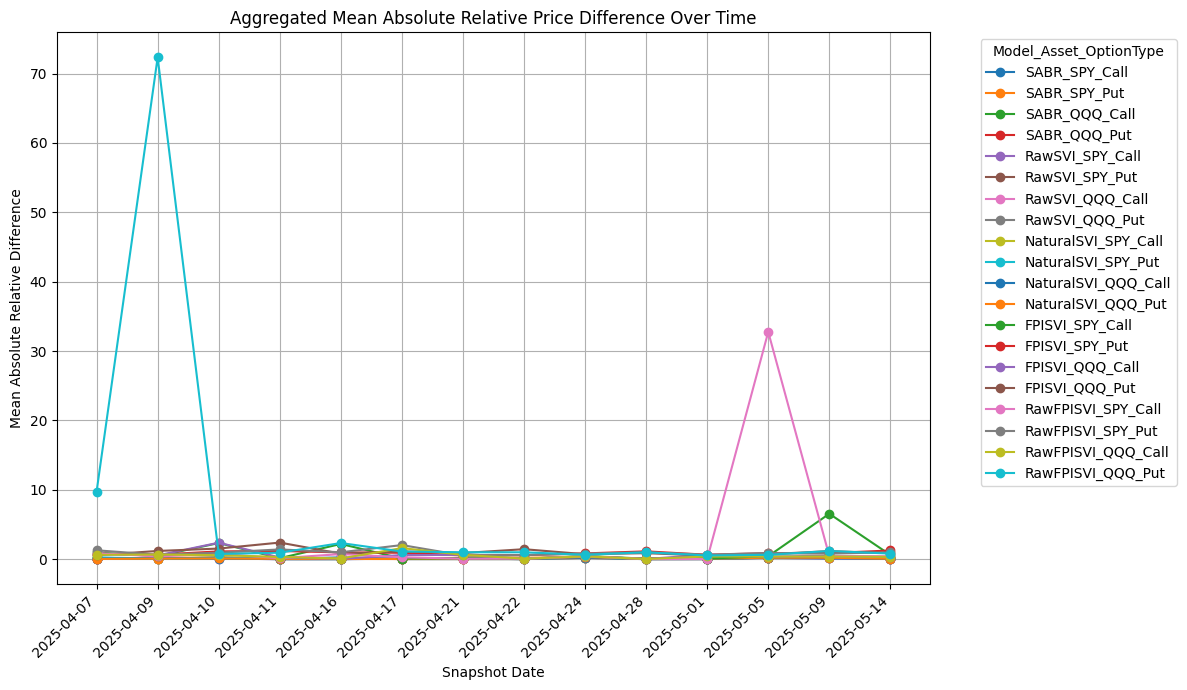

In [62]:


# Function to plot the aggregated relative differences
def plot_aggregated_relative_difference(aggregated_df, title_suffix=""):
    """
    Plots the aggregated mean absolute relative price differences over time.

    Parameters:
    - aggregated_df: DataFrame with snapshots as index and columns for each model/asset/option type.
    - title_suffix: String to append to the plot title.
    """
    if aggregated_df.empty:
        print("Aggregated DataFrame is empty, cannot plot.")
        return

    plt.figure(figsize=(12, 7))

    for column in aggregated_df.columns:
        plt.plot(aggregated_df.index, aggregated_df[column], marker='o', linestyle='-', label=column)

    plt.title(f'Aggregated Mean Absolute Relative Price Difference Over Time{title_suffix}')
    plt.xlabel('Snapshot Date')
    plt.ylabel('Mean Absolute Relative Difference')
    plt.legend(title='Model_Asset_OptionType', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot the aggregated relative differences
plot_aggregated_relative_difference(aggregated_relative_diffs)


Overall Mean Absolute Relative Price Difference Across All Models by Snapshot:


snapshot_date  Overall_Mean_Abs_Relative_Difference
0     2025-04-07                              0.606868
1     2025-04-09                              1.756076
2     2025-04-10                              0.637379
3     2025-04-11                              0.319603
4     2025-04-16                              0.509477
5     2025-04-17                              0.416595
6     2025-04-21                              0.274045
7     2025-04-22                              0.240194
8     2025-04-24                              0.396286
9     2025-04-28                              0.209063
10    2025-05-01                              0.248824
11    2025-05-05                              2.047105
12    2025-05-09                              0.803217
13    2025-05-14                              0.299073

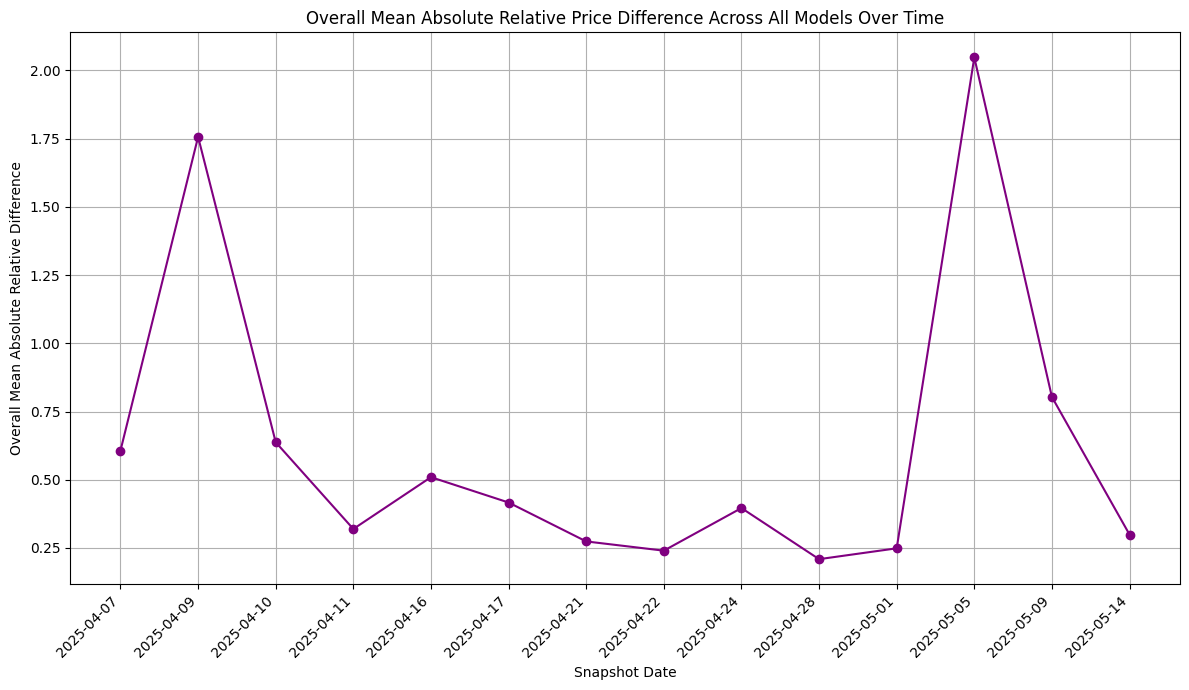


Mean Absolute Relative Price Difference by Model and Snapshot:


<ipython-input-63-da7b92f7c94a>:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_model_snapshot_relative_diff = model_snapshot_relative_diff.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')


model          FPISVI NaturalSVI RawFPISVI  RawSVI    SABR
snapshot_date                                             
2025-04-07     0.8035     0.1145    2.1070  0.0764  0.1320
2025-04-09     0.6428     0.1089    9.2568  0.1079  0.1521
2025-04-10     2.0909     0.1294    0.7660  0.1286  0.2197
2025-04-11     1.0261     0.0445    0.7174  0.0439  0.0472
2025-04-16     1.4151     0.0882    0.9855  0.0882  0.1515
2025-04-17     0.6540     0.0657    1.3083  0.0673  0.1078
2025-04-21     0.5596     0.0978    0.5306  0.0976  0.1291
2025-04-22     0.5147     0.0813    0.4737  0.0808  0.1232
2025-04-24     0.6125     0.2438    0.5808  0.2318  0.3171
2025-04-28     0.5397     0.0407    0.5212  0.0407  0.0494
2025-05-01     0.5338     0.0712    0.4995  0.0712  0.0996
2025-05-05     0.5942     0.2165    8.9332  0.2165  0.2751
2025-05-09     2.4499     0.2668    0.6682  0.2673  0.3553
2025-05-14     0.6635     0.0948    0.5413  0.0944  0.1540

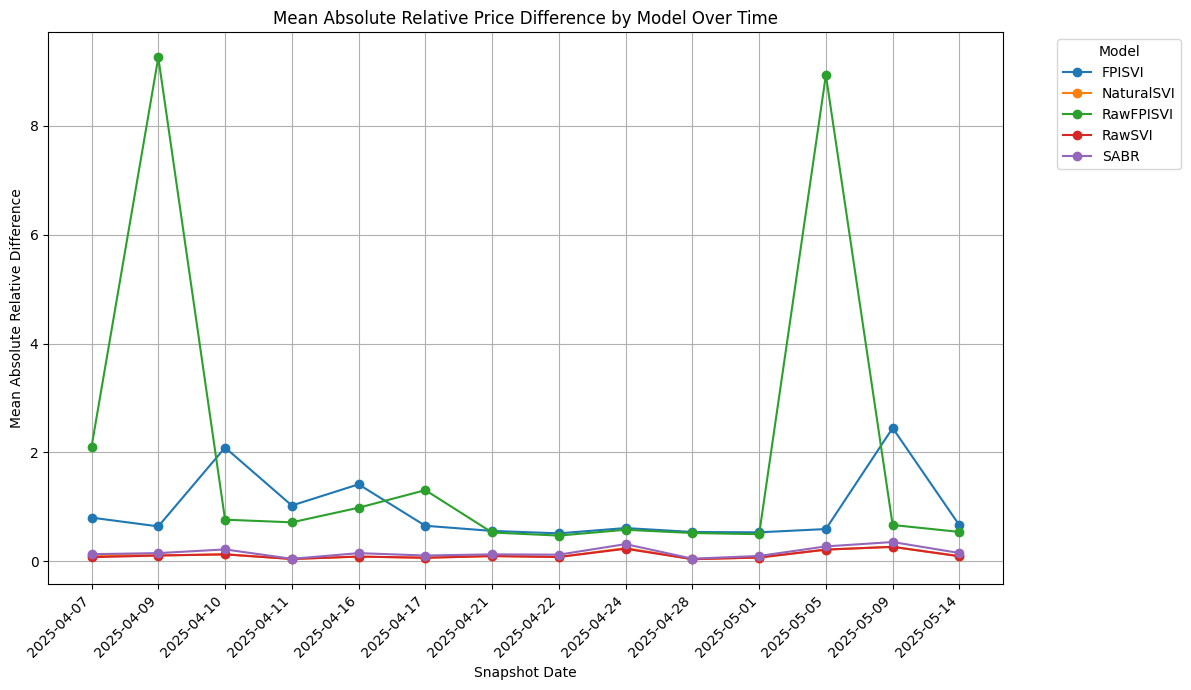


Mean Absolute Relative Price Difference by Asset/Option Type and Snapshot:


<ipython-input-63-da7b92f7c94a>:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_asset_option_snapshot_relative_diff = asset_option_snapshot_relative_diff.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')


asset             QQQ              SPY        
option_type      Call      Put    Call     Put
snapshot_date                                 
2025-04-07     0.3157   1.9288  0.4505  0.4178
2025-04-09     0.3089  12.2511  0.1855  0.3432
2025-04-10     0.6715   0.4788  0.7392  0.4684
2025-04-11     0.1039   0.6066  0.0681  0.5047
2025-04-16     0.0287   0.5296  0.6927  0.4113
2025-04-17     0.5029   0.4387  0.0831  0.5834
2025-04-21     0.3200   0.3896  0.0490  0.3033
2025-04-22     0.0336   0.5020  0.0362  0.3159
2025-04-24     0.2959   0.4506  0.3446  0.4854
2025-04-28     0.0176   0.3088  0.0371  0.4243
2025-05-01     0.2110   0.2657  0.0400  0.3295
2025-05-05     0.2911   0.3997  6.8084  0.4730
2025-05-09     0.2540   0.6087  1.5811  0.6165
2025-05-14     0.1834   0.3266  0.2949  0.5188

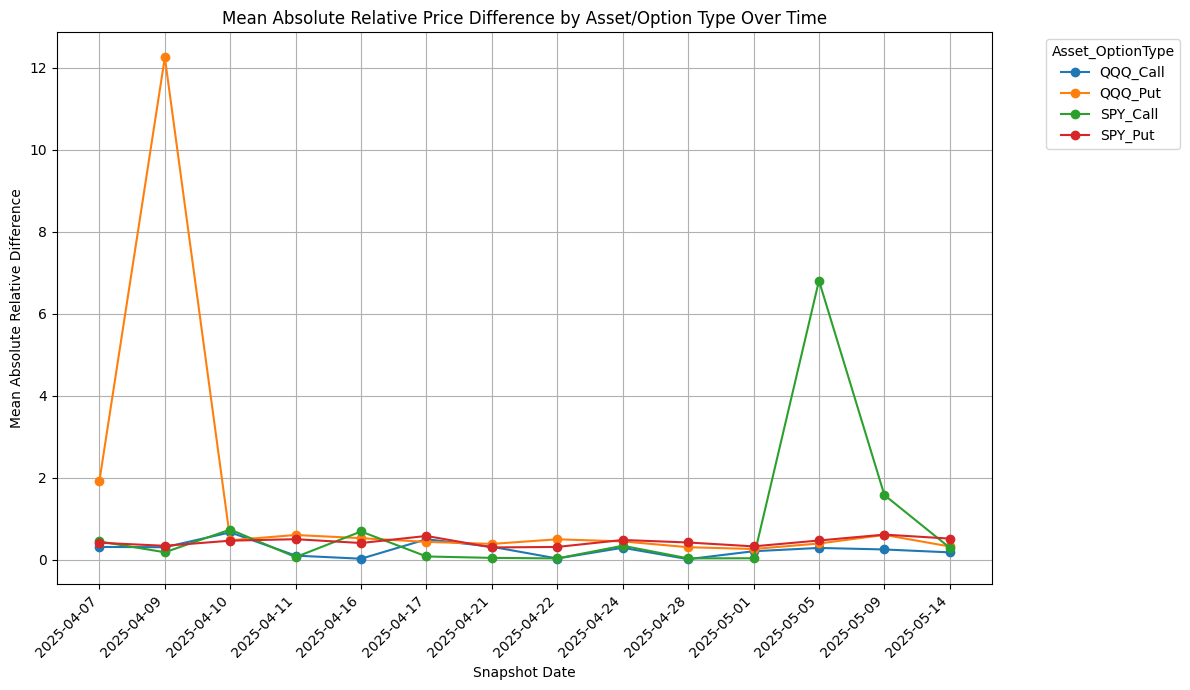


Overall Mean Absolute Relative Price Difference by Model and Asset/Option Type:


<ipython-input-63-da7b92f7c94a>:118: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted_model_asset_option_pivot_table = model_asset_option_pivot_table.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')


asset           SPY             QQQ        
option_type    Call     Put    Call     Put
model                                      
FPISVI       1.4303  0.8113  0.6647  0.9562
NaturalSVI   0.1252  0.1723  0.0982  0.1333
RawFPISVI    3.6600  0.8704  0.5805  5.0258
RawSVI       0.1254  0.1610  0.0973  0.1261
SABR         0.2185  0.1998  0.1636  0.1352

In [63]:


# Group the combined_relative_diff_df by snapshot_date and calculate the mean of the absolute relative difference for each snapshot.
# This gives us the performance of all models combined for each snapshot.
overall_mean_abs_relative_diff_by_snapshot = combined_relative_diff_df.groupby('snapshot_date')['relative_diff'].apply(
    lambda x: np.mean(np.abs(x.dropna()))
)

# Convert the Series back to a DataFrame
overall_mean_abs_relative_diff_by_snapshot_df = overall_mean_abs_relative_diff_by_snapshot.reset_index(name='Overall_Mean_Abs_Relative_Difference')

# Print the results
print("\nOverall Mean Absolute Relative Price Difference Across All Models by Snapshot:")
display(overall_mean_abs_relative_diff_by_snapshot_df)

# Plot the overall mean absolute relative price difference over time
plt.figure(figsize=(12, 7))
plt.plot(overall_mean_abs_relative_diff_by_snapshot_df['snapshot_date'],
         overall_mean_abs_relative_diff_by_snapshot_df['Overall_Mean_Abs_Relative_Difference'],
         marker='o', linestyle='-', color='purple')

plt.title('Overall Mean Absolute Relative Price Difference Across All Models Over Time')
plt.xlabel('Snapshot Date')
plt.ylabel('Overall Mean Absolute Relative Difference')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Group by model and snapshot_date and calculate the mean absolute relative difference
model_snapshot_relative_diff = combined_relative_diff_df.groupby(['model', 'snapshot_date'])['relative_diff'].apply(
    lambda x: np.mean(np.abs(x.dropna()))
).unstack(level='model') # Unstack to have models as columns

# Sort the index (snapshot dates)
model_snapshot_relative_diff.sort_index(inplace=True)

# Format the table for display
formatted_model_snapshot_relative_diff = model_snapshot_relative_diff.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')

# Print the table
print("\nMean Absolute Relative Price Difference by Model and Snapshot:")
display(formatted_model_snapshot_relative_diff)


# Plot the Mean Absolute Relative Price Difference by Model over time
plt.figure(figsize=(12, 7))

for column in model_snapshot_relative_diff.columns:
    plt.plot(model_snapshot_relative_diff.index, model_snapshot_relative_diff[column], marker='o', linestyle='-', label=column)

plt.title('Mean Absolute Relative Price Difference by Model Over Time')
plt.xlabel('Snapshot Date')
plt.ylabel('Mean Absolute Relative Difference')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Group by asset_option_type (e.g., SPY_Call, QQQ_Put) and snapshot_date and calculate the mean absolute relative difference
asset_option_snapshot_relative_diff = combined_relative_diff_df.groupby(['asset', 'option_type', 'snapshot_date'])['relative_diff'].apply(
    lambda x: np.mean(np.abs(x.dropna()))
).unstack(level=['asset', 'option_type']) # Unstack to have (Asset, OptionType) as columns

# Sort the index (snapshot dates)
asset_option_snapshot_relative_diff.sort_index(inplace=True)

# Format the table for display
formatted_asset_option_snapshot_relative_diff = asset_option_snapshot_relative_diff.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')

# Print the table
print("\nMean Absolute Relative Price Difference by Asset/Option Type and Snapshot:")
display(formatted_asset_option_snapshot_relative_diff)

# Plot the Mean Absolute Relative Price Difference by Asset/Option Type over time
plt.figure(figsize=(12, 7))

for column in asset_option_snapshot_relative_diff.columns:
    col_label = f"{column[0]}_{column[1]}" # Create label like 'SPY_Call'
    plt.plot(asset_option_snapshot_relative_diff.index, asset_option_snapshot_relative_diff[column], marker='o', linestyle='-', label=col_label)

plt.title('Mean Absolute Relative Price Difference by Asset/Option Type Over Time')
plt.xlabel('Snapshot Date')
plt.ylabel('Mean Absolute Relative Difference')
plt.legend(title='Asset_OptionType', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Group by model, asset, and option_type and calculate the mean absolute relative difference
model_asset_option_relative_diff = combined_relative_diff_df.groupby(['model', 'asset', 'option_type'])['relative_diff'].apply(
    lambda x: np.mean(np.abs(x.dropna()))
)

# Convert the Series back to a DataFrame
model_asset_option_relative_diff_df = model_asset_option_relative_diff.reset_index(name='Mean Absolute Relative Difference')

# Pivot the table to have models as rows and (Asset, Option Type) as columns
model_asset_option_pivot_table = model_asset_option_relative_diff_df.pivot_table(
    index='model',
    columns=['asset', 'option_type'],
    values='Mean Absolute Relative Difference'
)

# Reorder columns for better readability
try:
    col_order = [('SPY', 'Call'), ('SPY', 'Put'), ('QQQ', 'Call'), ('QQQ', 'Put')]
    existing_cols = [col for col in col_order if col in model_asset_option_pivot_table.columns]
    model_asset_option_pivot_table = model_asset_option_pivot_table[existing_cols]
except KeyError:
    print("Warning: Some expected columns not found in model_asset_option_pivot_table.")


# Format the values
formatted_model_asset_option_pivot_table = model_asset_option_pivot_table.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-')

# Print the table
print("\nOverall Mean Absolute Relative Price Difference by Model and Asset/Option Type:")
display(formatted_model_asset_option_pivot_table)



In [64]:
# Table 1: Mean Absolute Relative Price Difference by Asset/Option Type and Model
print("\nTable 1: Mean Absolute Relative Price Difference by Asset/Option Type and Model")
# The table `model_asset_option_pivot_table` already has models as rows and (Asset, Option Type) as columns
# We just need to transpose it to get Asset/Option Type as rows and Models as columns
table1 = model_asset_option_pivot_table.T
table1.index = [f"{idx[0]}_{idx[1]}" for idx in table1.index] # Make index a single string for display
display(table1.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-'))


# Function to compute relative price difference aggregated by maturity
def compute_aggregated_relative_difference_by_maturity(relative_diff_dfs):
    """
    Aggregates the relative price differences by maturity and model.

    Parameters:
    - relative_diff_dfs: Dictionary where keys are 'Model_Asset_OptionType' strings
                         and values are DataFrames from compute_relative_price_difference.

    Returns:
    - A pandas DataFrame with maturities as index and columns for each model,
      showing the mean absolute relative difference for that maturity across all asset/option types.
    """
    aggregated_data = []

    # First, combine all individual dataframes into one
    combined_df = pd.concat(relative_diff_dfs.values(), ignore_index=True)

    # Ensure 'relative_diff' column is numeric
    combined_df['relative_diff'] = pd.to_numeric(combined_df['relative_diff'], errors='coerce')

    # Group by model and maturity and calculate the mean absolute difference
    mean_abs_diff_by_model_maturity = combined_df.groupby(['model', 'maturity'])['relative_diff'].apply(
        lambda x: np.mean(np.abs(x.dropna())) # Calculate mean of absolute values, ignoring NaNs
    )

    # Unstack to have models as columns and maturity as index
    aggregated_df = mean_abs_diff_by_model_maturity.unstack(level='model')

    # Sort by maturity if needed
    # You might need to convert maturity to a sortable type if it's not already (e.g., datetime)
    # Assuming maturity is already sortable string 'YYYY-MM-DD' or similar
    aggregated_df.sort_index(inplace=True)

    return aggregated_df

# Compute the aggregated relative differences by maturity
aggregated_relative_diffs_by_maturity = compute_aggregated_relative_difference_by_maturity(relative_diff_dfs)

# Table 2: Mean Absolute Relative Price Difference by Maturity and Model
print("\nTable 2: Mean Absolute Relative Price Difference by Maturity and Model")
display(aggregated_relative_diffs_by_maturity.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-'))


# Function to compute relative price difference aggregated by snapshot date
def compute_aggregated_relative_difference_by_snapshot(relative_diff_dfs):
    """
    Aggregates the relative price differences by snapshot date and model.

    Parameters:
    - relative_diff_dfs: Dictionary where keys are 'Model_Asset_OptionType' strings
                         and values are DataFrames from compute_relative_price_difference.

    Returns:
    - A pandas DataFrame with snapshot dates as index and columns for each model,
      showing the mean absolute relative difference for that snapshot across all asset/option types and maturities.
    """
    aggregated_data = []

    # First, combine all individual dataframes into one
    combined_df = pd.concat(relative_diff_dfs.values(), ignore_index=True)

    # Ensure 'relative_diff' column is numeric
    combined_df['relative_diff'] = pd.to_numeric(combined_df['relative_diff'], errors='coerce')

    # Group by model and snapshot_date and calculate the mean absolute difference
    mean_abs_diff_by_model_snapshot = combined_df.groupby(['model', 'snapshot_date'])['relative_diff'].apply(
        lambda x: np.mean(np.abs(x.dropna())) # Calculate mean of absolute values, ignoring NaNs
    )

    # Unstack to have models as columns and snapshot_date as index
    aggregated_df = mean_abs_diff_by_model_snapshot.unstack(level='model')

    # Sort by snapshot date
    aggregated_df.sort_index(inplace=True)

    return aggregated_df

# Compute the aggregated relative differences by snapshot date
aggregated_relative_diffs_by_snapshot = compute_aggregated_relative_difference_by_snapshot(relative_diff_dfs)


# Table 3: Mean Absolute Relative Price Difference by Snapshot Date and Model
print("\nTable 3: Mean Absolute Relative Price Difference by Snapshot Date and Model")
display(aggregated_relative_diffs_by_snapshot.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-'))



Table 1: Mean Absolute Relative Price Difference by Asset/Option Type and Model


<ipython-input-64-405a12fb87d2>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(table1.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-'))


model     FPISVI NaturalSVI RawFPISVI  RawSVI    SABR
SPY_Call  1.4303     0.1252    3.6600  0.1254  0.2185
SPY_Put   0.8113     0.1723    0.8704  0.1610  0.1998
QQQ_Call  0.6647     0.0982    0.5805  0.0973  0.1636
QQQ_Put   0.9562     0.1333    5.0258  0.1261  0.1352


Table 2: Mean Absolute Relative Price Difference by Maturity and Model


<ipython-input-64-405a12fb87d2>:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(aggregated_relative_diffs_by_maturity.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-'))


model       FPISVI NaturalSVI RawFPISVI  RawSVI    SABR
maturity                                               
2025-04-11  0.6561     0.2375    0.7072  0.1879  0.3627
2025-04-25  0.5842     0.1671    1.3709  0.1581  0.3007
2025-05-16  0.5707     0.1603    0.5340  0.1536  0.2231
2025-06-20  0.9462     0.0945    5.2321  0.0945  0.2010
2025-12-19  0.3326     0.0868    8.1824  0.0858  0.1148
2026-06-18  2.9243     0.1137    0.5270  0.1131  0.1192
2026-12-18  0.7511     0.1222    0.8120  0.1221  0.1277
2027-01-15  0.8448     0.1259    0.7761  0.1257  0.1295
2027-12-17  1.4934     0.1362    1.4449  0.1362  0.1388


Table 3: Mean Absolute Relative Price Difference by Snapshot Date and Model


<ipython-input-64-405a12fb87d2>:94: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  display(aggregated_relative_diffs_by_snapshot.applymap(lambda x: f'{x:.4f}' if pd.notna(x) else '-'))


model          FPISVI NaturalSVI RawFPISVI  RawSVI    SABR
snapshot_date                                             
2025-04-07     0.8035     0.1145    2.1070  0.0764  0.1320
2025-04-09     0.6428     0.1089    9.2568  0.1079  0.1521
2025-04-10     2.0909     0.1294    0.7660  0.1286  0.2197
2025-04-11     1.0261     0.0445    0.7174  0.0439  0.0472
2025-04-16     1.4151     0.0882    0.9855  0.0882  0.1515
2025-04-17     0.6540     0.0657    1.3083  0.0673  0.1078
2025-04-21     0.5596     0.0978    0.5306  0.0976  0.1291
2025-04-22     0.5147     0.0813    0.4737  0.0808  0.1232
2025-04-24     0.6125     0.2438    0.5808  0.2318  0.3171
2025-04-28     0.5397     0.0407    0.5212  0.0407  0.0494
2025-05-01     0.5338     0.0712    0.4995  0.0712  0.0996
2025-05-05     0.5942     0.2165    8.9332  0.2165  0.2751
2025-05-09     2.4499     0.2668    0.6682  0.2673  0.3553
2025-05-14     0.6635     0.0948    0.5413  0.0944  0.1540

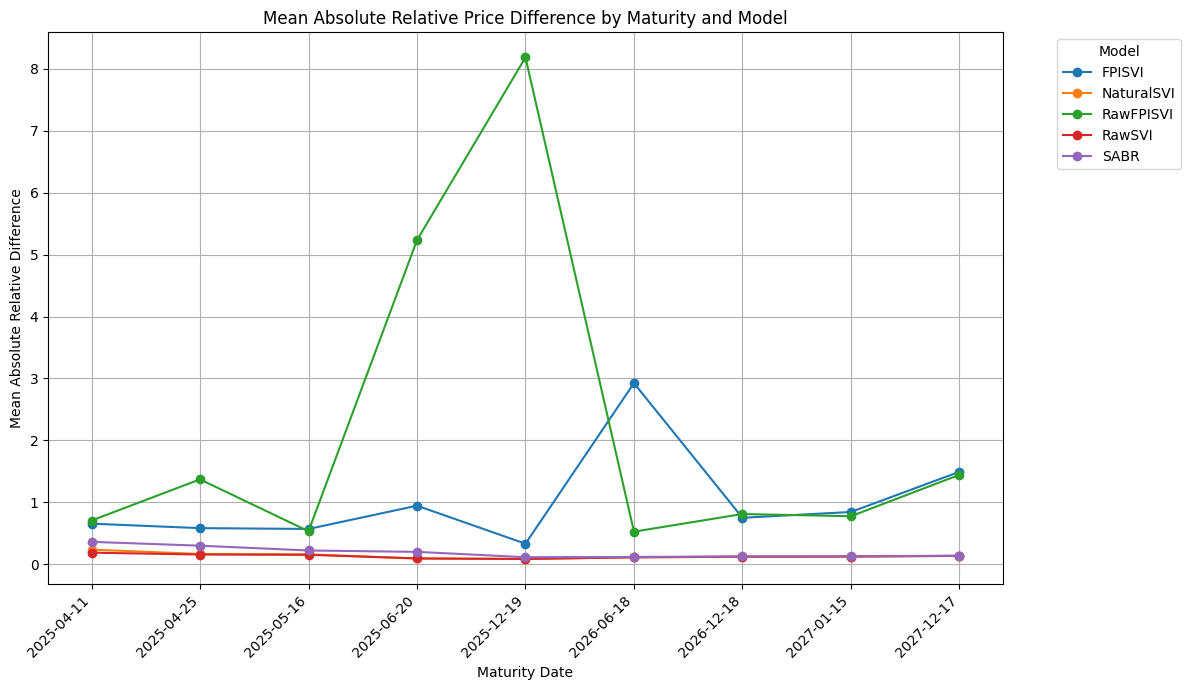

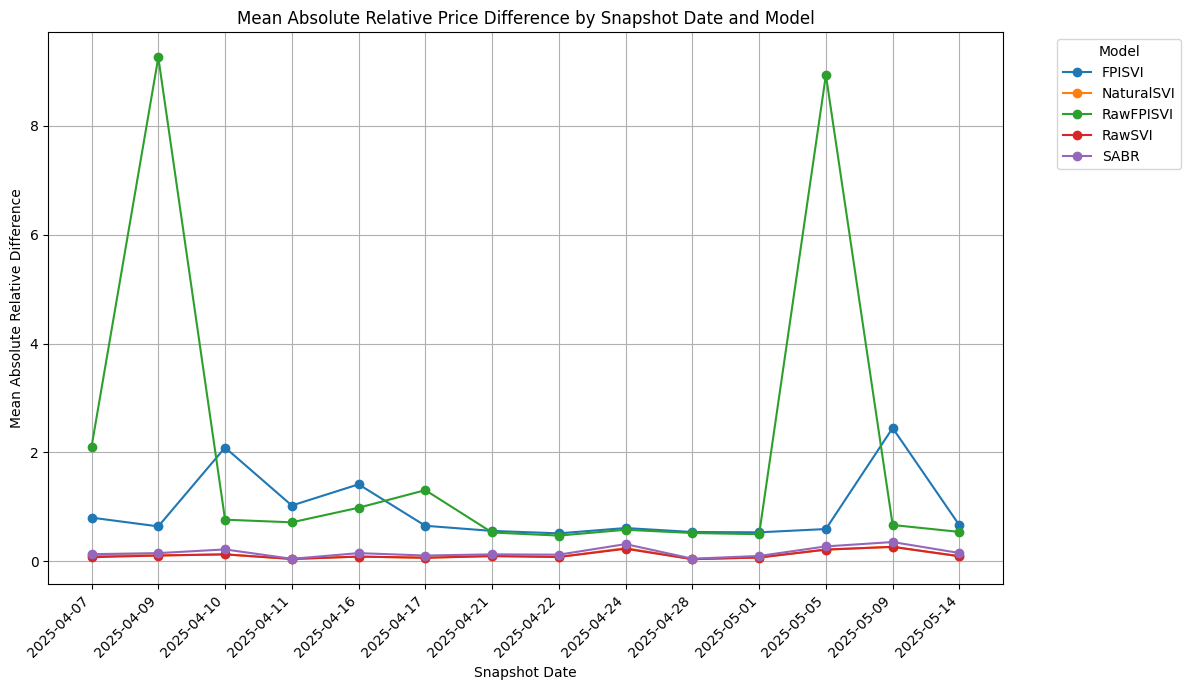

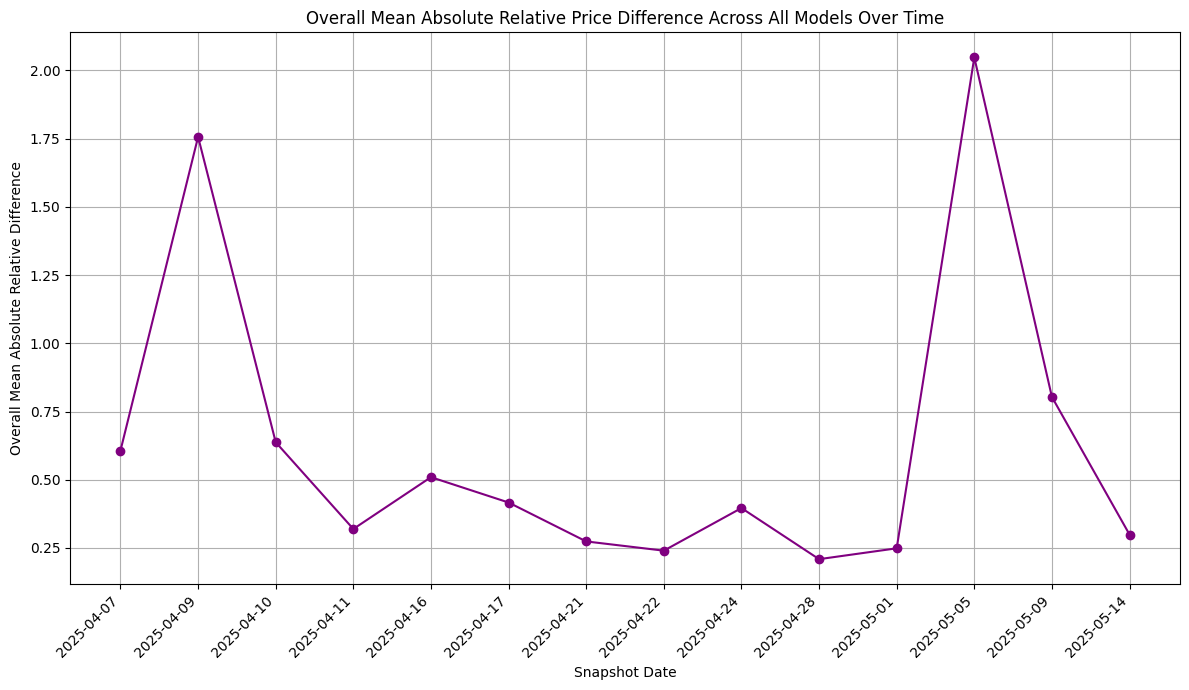

In [65]:


# Graph 1: Mean Absolute Relative Price Difference by Maturity and Model
plt.figure(figsize=(12, 7))

for column in aggregated_relative_diffs_by_maturity.columns:
    plt.plot(aggregated_relative_diffs_by_maturity.index, aggregated_relative_diffs_by_maturity[column], marker='o', linestyle='-', label=column)

plt.title('Mean Absolute Relative Price Difference by Maturity and Model')
plt.xlabel('Maturity Date')
plt.ylabel('Mean Absolute Relative Difference')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Graph 2: Mean Absolute Relative Price Difference by Snapshot Date and Model
plt.figure(figsize=(12, 7))

for column in aggregated_relative_diffs_by_snapshot.columns:
    plt.plot(aggregated_relative_diffs_by_snapshot.index, aggregated_relative_diffs_by_snapshot[column], marker='o', linestyle='-', label=column)

plt.title('Mean Absolute Relative Price Difference by Snapshot Date and Model')
plt.xlabel('Snapshot Date')
plt.ylabel('Mean Absolute Relative Difference')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Graph 3: Overall Mean Absolute Relative Price Difference Across All Models by Snapshot (Already plotted, just repeating for clarity if needed)
# This graph shows the average performance across all models for each snapshot date.
# You can use the previously created dataframe `overall_mean_abs_relative_diff_by_snapshot_df`
if not overall_mean_abs_relative_diff_by_snapshot_df.empty:
    plt.figure(figsize=(12, 7))
    plt.plot(overall_mean_abs_relative_diff_by_snapshot_df['snapshot_date'],
             overall_mean_abs_relative_diff_by_snapshot_df['Overall_Mean_Abs_Relative_Difference'],
             marker='o', linestyle='-', color='purple')

    plt.title('Overall Mean Absolute Relative Price Difference Across All Models Over Time')
    plt.xlabel('Snapshot Date')
    plt.ylabel('Overall Mean Absolute Relative Difference')
    plt.grid(True)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Overall Mean Absolute Relative Price Difference DataFrame is empty, cannot plot the third graph.")

### More plots

call market - call calibrated pero divido entre col market el error relativo


DataFrame with Relative Absolute Errors:
   snapshot_date    maturity  strike  premium  sabr_bs_price  rawsvi_bs_price  \
10    2025-04-09  2027-12-17   200.0   351.89            NaN       370.408045   
11    2025-04-09  2027-12-17   205.0   347.53            NaN       366.042315   
12    2025-04-09  2027-12-17   210.0   343.23            NaN       361.683737   
13    2025-04-09  2027-12-17   215.0   338.81            NaN       357.332537   
14    2025-04-09  2027-12-17   220.0   334.66            NaN       352.988946   

    natsvi_bs_price  fpi_bs_price  sabr_rel_abs_error  rawsvi_rel_abs_error  \
10              NaN           NaN                 NaN              0.052625   
11              NaN           NaN                 NaN              0.053268   
12              NaN           NaN                 NaN              0.053765   
13              NaN           NaN                 NaN              0.054669   
14              NaN           NaN                 NaN              0.054769 

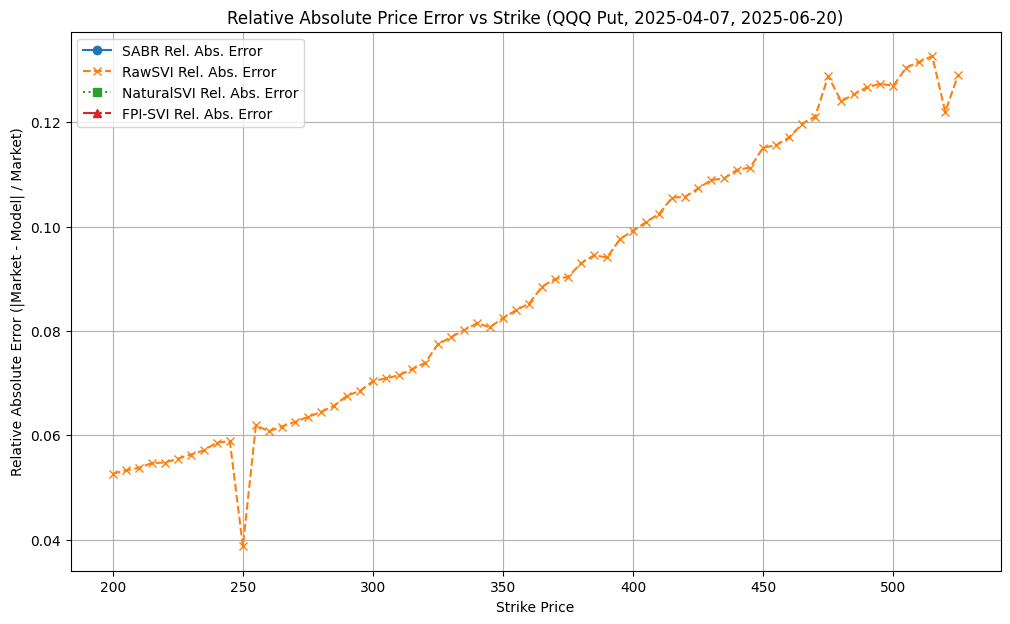

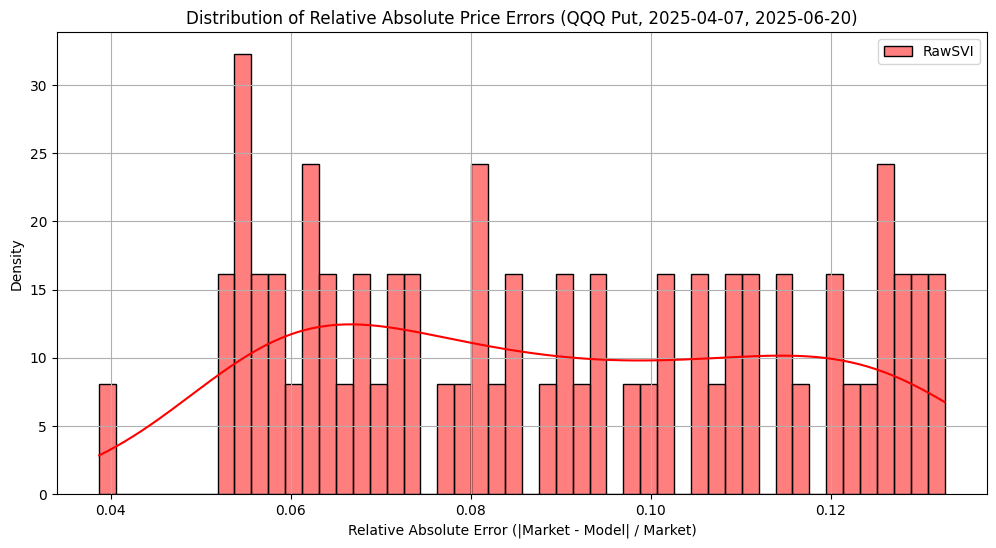

In [66]:
# prompt: i want to get the relative diference of all of the models above

# Combine the price dataframes for comparison
# Ensure they have the same columns and index for merging
df_sabr = merged_df_sabr[['snapshot_date', 'maturity', 'strike', 'premium', 'bs_price']].copy()
df_rawsvi = merged_df[['snapshot_date', 'maturity', 'strike', 'premium', 'bs_price']].copy()
df_natsvi = merged_df_natsvi[['snapshot_date', 'maturity', 'strike', 'premium', 'bs_price']].copy()
df_fpi = merged_df_fpi[['snapshot_date', 'maturity', 'strike', 'premium', 'bs_price']].copy()

# Rename 'bs_price' columns to indicate the model
df_sabr = df_sabr.rename(columns={'bs_price': 'sabr_bs_price'})
df_rawsvi = df_rawsvi.rename(columns={'bs_price': 'rawsvi_bs_price'})
df_natsvi = df_natsvi.rename(columns={'bs_price': 'natsvi_bs_price'})
df_fpi = df_fpi.rename(columns={'bs_price': 'fpi_bs_price'})

# Merge the dataframes on common keys
# Start with premium data, then merge each model's BS price
comparison_price_df = premium_df[['snapshot_date', 'maturity', 'strike', 'premium']].copy()
comparison_price_df = pd.merge(comparison_price_df, df_sabr[['snapshot_date', 'maturity', 'strike', 'sabr_bs_price']], on=['snapshot_date', 'maturity', 'strike'], how='left')
comparison_price_df = pd.merge(comparison_price_df, df_rawsvi[['snapshot_date', 'maturity', 'strike', 'rawsvi_bs_price']], on=['snapshot_date', 'maturity', 'strike'], how='left')
comparison_price_df = pd.merge(comparison_price_df, df_natsvi[['snapshot_date', 'maturity', 'strike', 'natsvi_bs_price']], on=['snapshot_date', 'maturity', 'strike'], how='left')
comparison_price_df = pd.merge(comparison_price_df, df_fpi[['snapshot_date', 'maturity', 'strike', 'fpi_bs_price']], on=['snapshot_date', 'maturity', 'strike'], how='left')

# Drop rows where the market premium is zero or NaN (as we divide by it)
comparison_price_df = comparison_price_df.dropna(subset=['premium'])
comparison_price_df = comparison_price_df[comparison_price_df['premium'] != 0].copy()

# Calculate Relative Absolute Error for each model
comparison_price_df['sabr_rel_abs_error'] = np.abs(comparison_price_df['premium'] - comparison_price_df['sabr_bs_price']) / comparison_price_df['premium']
comparison_price_df['rawsvi_rel_abs_error'] = np.abs(comparison_price_df['premium'] - comparison_price_df['rawsvi_bs_price']) / comparison_price_df['premium']
comparison_price_df['natsvi_rel_abs_error'] = np.abs(comparison_price_df['premium'] - comparison_price_df['natsvi_bs_price']) / comparison_price_df['premium']
comparison_price_df['fpi_rel_abs_error'] = np.abs(comparison_price_df['premium'] - comparison_price_df['fpi_bs_price']) / comparison_price_df['premium']

# Display the resulting DataFrame with errors
print("\nDataFrame with Relative Absolute Errors:")
print(comparison_price_df.head())

# Calculate summary statistics for the relative absolute errors
rel_error_stats = {
    'SABR Mean Rel Abs Error': comparison_price_df['sabr_rel_abs_error'].mean(),
    'SABR Median Rel Abs Error': comparison_price_df['sabr_rel_abs_error'].median(),
    'SABR Max Rel Abs Error': comparison_price_df['sabr_rel_abs_error'].max(),
    'RawSVI Mean Rel Abs Error': comparison_price_df['rawsvi_rel_abs_error'].mean(),
    'RawSVI Median Rel Abs Error': comparison_price_df['rawsvi_rel_abs_error'].median(),
    'RawSVI Max Rel Abs Error': comparison_price_df['rawsvi_rel_abs_error'].max(),
    'NaturalSVI Mean Rel Abs Error': comparison_price_df['natsvi_rel_abs_error'].mean(),
    'NaturalSVI Median Rel Abs Error': comparison_price_df['natsvi_rel_abs_error'].median(),
    'NaturalSVI Max Rel Abs Error': comparison_price_df['natsvi_rel_abs_error'].max(),
    'FPI-SVI Mean Rel Abs Error': comparison_price_df['fpi_rel_abs_error'].mean(),
    'FPI-SVI Median Rel Abs Error': comparison_price_df['fpi_rel_abs_error'].median(),
    'FPI-SVI Max Rel Abs Error': comparison_price_df['fpi_rel_abs_error'].max(),
    'Number of Points Compared': len(comparison_price_df)
}

print("\nSummary Statistics for Relative Absolute Price Errors:")
print(pd.Series(rel_error_stats))


# Optional: Plot the relative absolute errors
if not comparison_price_df.empty:
    plt.figure(figsize=(12, 7))
    plt.plot(comparison_price_df['strike'], comparison_price_df['sabr_rel_abs_error'], marker='o', linestyle='-', label='SABR Rel. Abs. Error')
    plt.plot(comparison_price_df['strike'], comparison_price_df['rawsvi_rel_abs_error'], marker='x', linestyle='--', label='RawSVI Rel. Abs. Error')
    plt.plot(comparison_price_df['strike'], comparison_price_df['natsvi_rel_abs_error'], marker='s', linestyle=':', label='NaturalSVI Rel. Abs. Error')
    plt.plot(comparison_price_df['strike'], comparison_price_df['fpi_rel_abs_error'], marker='^', linestyle='-.', label='FPI-SVI Rel. Abs. Error')

    plt.title(f'Relative Absolute Price Error vs Strike ({asset} {option_type}, {snapshot}, {maturity})')
    plt.xlabel('Strike Price')
    plt.ylabel('Relative Absolute Error (|Market - Model| / Market)')
    plt.legend()
    plt.grid(True)
    # Optional: set y-limit to focus on smaller errors if needed
    # plt.ylim(0, 1)
    plt.show()
else:
    print("No valid data points to plot relative errors.")

# Optional: Distribution plot of relative absolute errors
if not comparison_price_df.empty:
    plt.figure(figsize=(12, 6))

    sns.histplot(comparison_price_df['sabr_rel_abs_error'].dropna(), bins=50, kde=True, color='blue', label='SABR', stat='density', common_norm=False)
    sns.histplot(comparison_price_df['rawsvi_rel_abs_error'].dropna(), bins=50, kde=True, color='red', label='RawSVI', stat='density', common_norm=False)
    sns.histplot(comparison_price_df['natsvi_rel_abs_error'].dropna(), bins=50, kde=True, color='green', label='NaturalSVI', stat='density', common_norm=False)
    sns.histplot(comparison_price_df['fpi_rel_abs_error'].dropna(), bins=50, kde=True, color='purple', label='FPI-SVI', stat='density', common_norm=False)

    plt.title(f'Distribution of Relative Absolute Price Errors ({asset} {option_type}, {snapshot}, {maturity})')
    plt.xlabel('Relative Absolute Error (|Market - Model| / Market)')
    plt.ylabel('Density')
    plt.legend()
    # Optional: set x-limit to focus on smaller errors
    # plt.xlim(0, 1)
    plt.grid(True)
    plt.show()
else:
    print("No valid data points to plot relative error distributions.")


## Analysis

### MSE

In [67]:
# Assuming you have xarrays named like SABR_spy_call_mse, etc.
models = ['SABR', 'RawSVI', 'NaturalSVI', 'FPISVI', 'RawFPISVI']
tickers = ['spy', 'qqq']
option_types = ['call', 'put']

# Initialize DataFrame to store results
index = ['SPY Call', 'SPY Put', 'QQQ Call', 'QQQ Put']
columns = ['SABR', 'Raw SVI', 'Nat SVI', 'FPI-SVI', 'Raw FPI-SVI']
results = pd.DataFrame(index=index, columns=columns)

# Map model names to nice labels
model_label_map = {
    'SABR': 'SABR',
    'RawSVI': 'Raw SVI',
    'NaturalSVI': 'Nat SVI',
    'FPISVI': 'FPI-SVI',
    'RawFPISVI': 'Raw FPI-SVI'
}

for ticker in tickers:
    for opt_type in option_types:
        row_label = f"{ticker.upper()} {opt_type.capitalize()}"
        for model in models:
            # Build variable name dynamically
            var_name = f"{model}_{ticker}_{opt_type}_mse"
            # Assume you have each xarray in your namespace
            arr = globals()[var_name]
            values = arr.values.flatten()
            values = values[~np.isnan(values)]  # Remove NaNs
            rmse = np.sqrt(values)
            if len(values) > 0:
                mean_rmse = gmean(rmse)
            else:
                mean_rmse = np.nan
            results.loc[row_label, model_label_map[model]] = mean_rmse

# Optionally format for better readability
results = results.astype(float).round(6)
print(results)


              SABR   Raw SVI   Nat SVI   FPI-SVI  Raw FPI-SVI
SPY Call  0.012459  0.007483  0.007482  0.041616     0.069677
SPY Put   0.008175  0.004015  0.004357  0.027605     0.061307
QQQ Call  0.013372  0.008169  0.008468  0.040291     0.071552
QQQ Put   0.005869  0.003603  0.003769  0.042507     0.110793


In [68]:
models = ['SABR', 'RawSVI', 'NaturalSVI', 'FPISVI', 'RawFPISVI']
tickers = ['spy', 'qqq']
option_types = ['call', 'put']

maturity_results = {}

for model in models:
    maturity_list = []

    for ticker in tickers:
        for opt_type in option_types:
            var_name = f"{model}_{ticker}_{opt_type}_mse"
            da = globals()[var_name]  # Each is a DataArray with dims [snapshot_date, maturity]
            maturity_list.append(da)

    # Stack all 4 instruments into new dim
    stacked = xr.concat(maturity_list, dim='instrument')

    # Reshape to 2D (obs × maturity)
    reshaped = stacked.stack(obs=('snapshot_date', 'instrument'))

    # Compute geometric mean across obs for each maturity
    gm_values = []
    for m in reshaped.maturity:
        data = reshaped.sel(maturity=m).values
        data = data[~np.isnan(data)]  # remove NaNs
        rmse = np.sqrt(data)
        if len(data) > 0:
            gm = gmean(rmse)
        else:
            gm = np.nan
        gm_values.append(gm)

    maturity_results[model] = gm_values

# Build final DataFrame
maturities = stacked['maturity'].values
df_maturity = pd.DataFrame(maturity_results, index=maturities)

# Rename columns for clean output
df_maturity.columns = ['SABR', 'Raw SVI', 'Nat SVI', 'FPI-SVI', 'Raw FPI-SVI']
df_maturity.index.name = 'Maturity'
df_maturity = df_maturity.round(6)

print(df_maturity)

                SABR   Raw SVI   Nat SVI   FPI-SVI  Raw FPI-SVI
Maturity                                                       
2025-04-11  0.074774  0.042483  0.059472  0.196800     0.672894
2025-04-25  0.032560  0.023650  0.025888  0.116407     0.681069
2025-05-16  0.019325  0.012744  0.013502  0.070353     0.347231
2025-06-20  0.020295  0.010014  0.010146  0.057711     0.044057
2025-12-19  0.008549  0.003993  0.004135  0.028711     0.040569
2026-06-18  0.006430  0.003394  0.003501  0.024447     0.036904
2026-12-18  0.004591  0.002491  0.002617  0.019855     0.028390
2027-01-15  0.005392  0.003409  0.003482  0.022785     0.161006
2027-12-17  0.004331  0.002849  0.002923  0.029068     0.039329


In [69]:
models = ['SABR', 'RawSVI', 'NaturalSVI', 'FPISVI', 'RawFPISVI']
tickers = ['spy', 'qqq']
option_types = ['call', 'put']

snapshot_results = {}

for model in models:
    da_list = []

    for ticker in tickers:
        for opt_type in option_types:
            var_name = f"{model}_{ticker}_{opt_type}_mse"
            da = globals()[var_name]  # Assume each is [snapshot_date, maturity]
            da_list.append(da)

    # Stack along new 'instrument' dimension
    stacked = xr.concat(da_list, dim='instrument')  # dims: snapshot_date × maturity × instrument

    # Reshape: snapshot_date × (maturity * instrument)
    reshaped = stacked.stack(flat=('maturity', 'instrument'))  # dims: snapshot_date × flat

    # Compute geometric mean for each snapshot (row)
    gm_values = []
    for s in reshaped.snapshot_date:
        values = reshaped.sel(snapshot_date=s).values
        values = values[~np.isnan(values)]
        rmse = np.sqrt(values)
        gm = gmean(rmse) if len(rmse) > 0 else np.nan
        gm_values.append(gm)

    snapshot_results[model] = gm_values

# Build final DataFrame
snapshot_dates = reshaped['snapshot_date'].values
df_snapshot = pd.DataFrame(snapshot_results, index=snapshot_dates)

df_snapshot.columns = ['SABR', 'Raw SVI', 'Nat SVI', 'FPI-SVI', 'Raw FPI-SVI']
df_snapshot.index.name = 'Snapshot Date'
df_snapshot = df_snapshot.round(6)

print(df_snapshot)

                   SABR   Raw SVI   Nat SVI   FPI-SVI  Raw FPI-SVI
Snapshot Date                                                     
2025-04-07     0.009010  0.005386  0.007020  0.034270     0.167258
2025-04-09     0.021559  0.016002  0.015240  0.047408     0.106309
2025-04-10     0.008931  0.005559  0.005685  0.042462     0.038715
2025-04-11     0.004959  0.003142  0.003315  0.042216     0.262450
2025-04-16     0.005395  0.002616  0.002740  0.045016     0.095190
2025-04-17     0.005056  0.002781  0.002713  0.039259     0.157106
2025-04-21     0.010379  0.006041  0.006153  0.033856     0.076606
2025-04-22     0.009372  0.006363  0.006446  0.046080     0.118875
2025-04-24     0.023271  0.009182  0.010233  0.026647     0.030191
2025-04-28     0.003279  0.002974  0.003002  0.081389     0.191809
2025-05-01     0.017429  0.009307  0.009320  0.040455     0.054722
2025-05-05     0.016873  0.008236  0.008300  0.019205     0.026109
2025-05-09     0.011051  0.005272  0.005501  0.031083     0.04

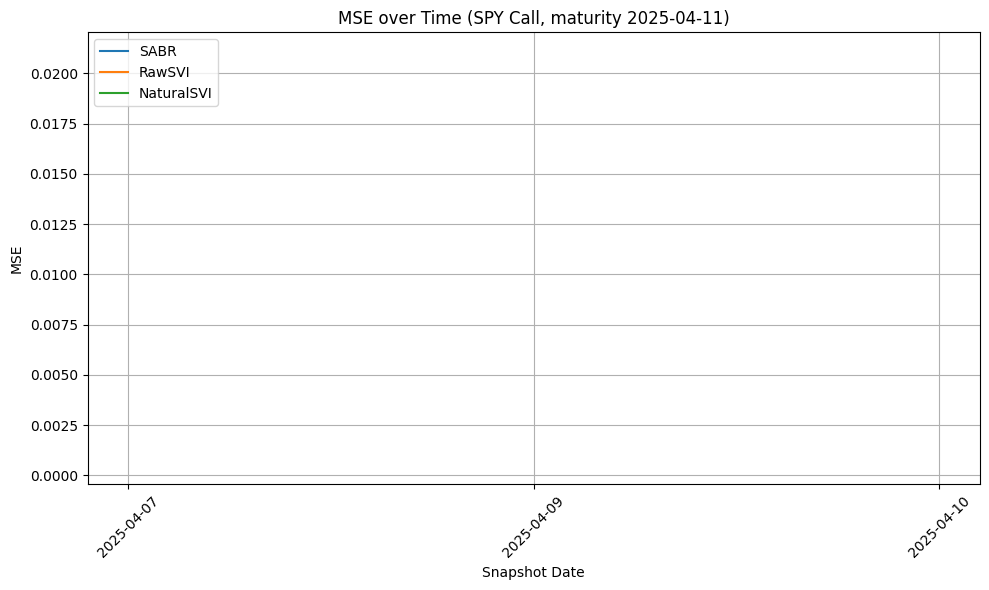

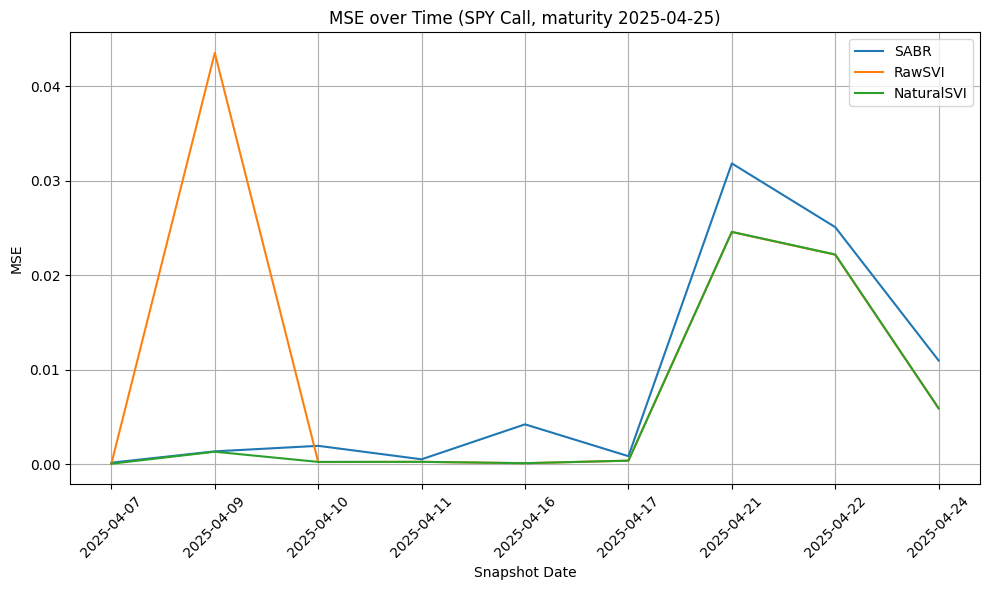

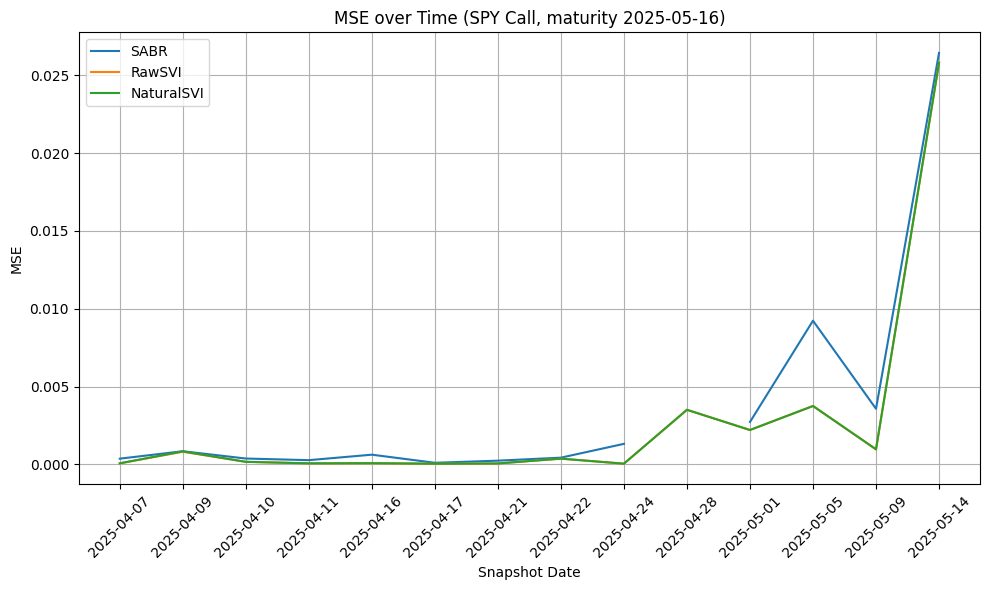

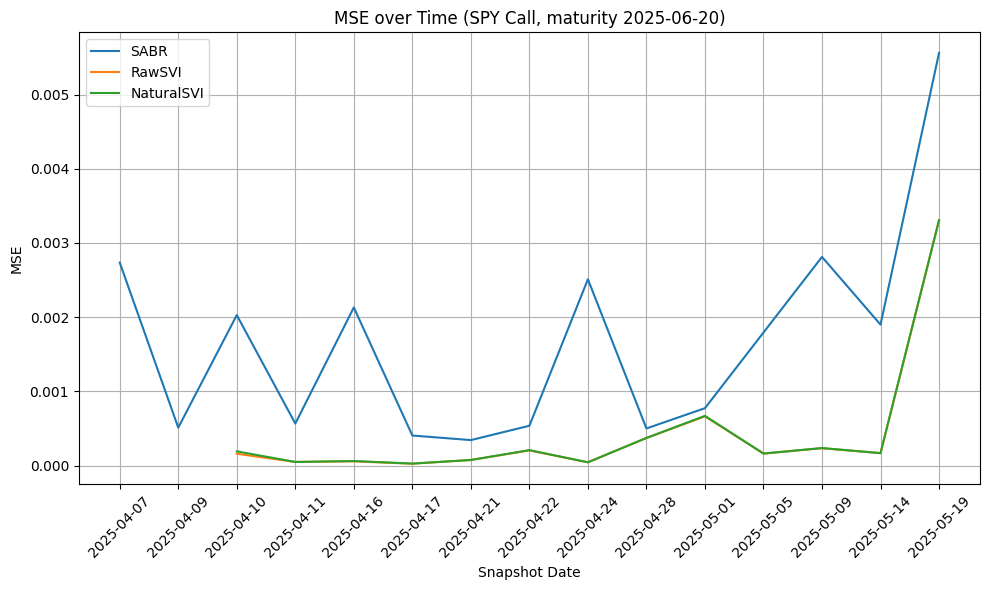

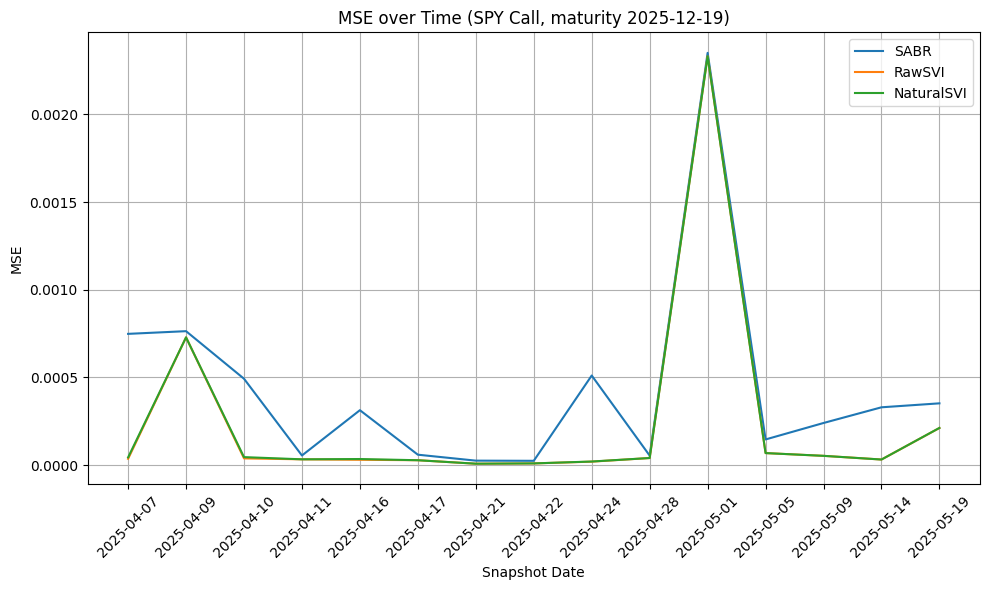

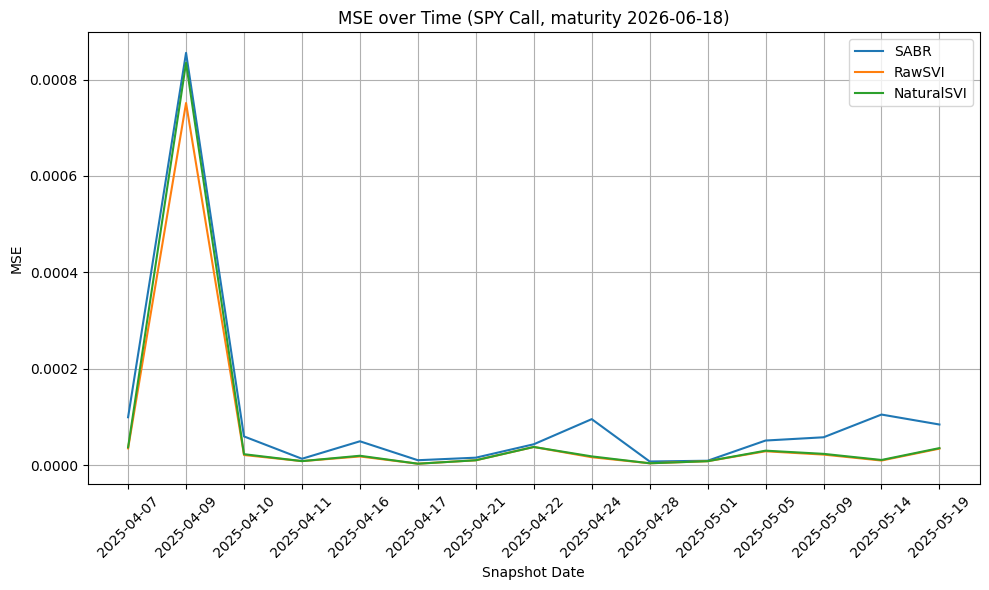

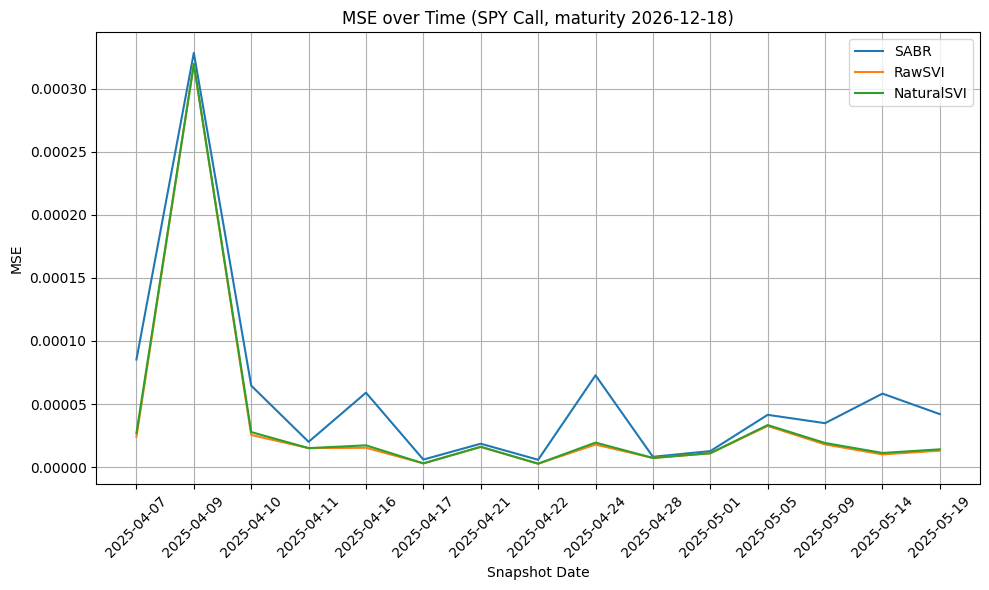

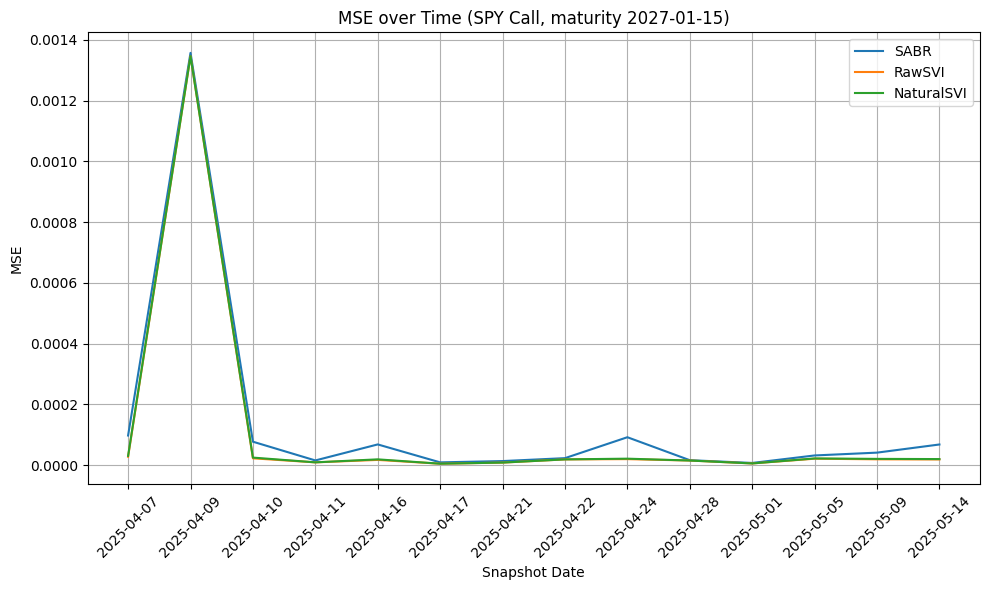

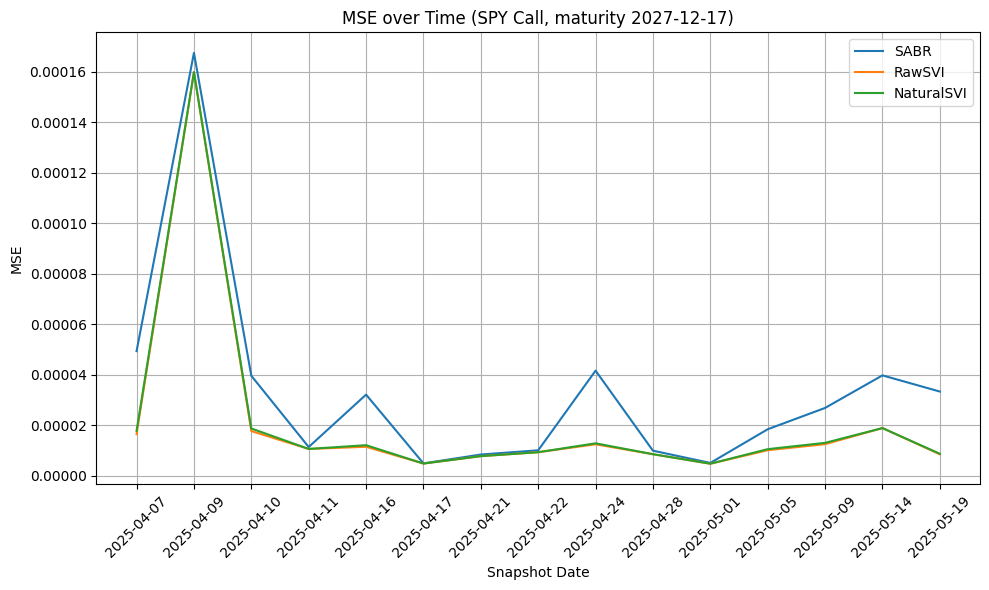

In [70]:
maturities = spy_call.coords['maturity'].values

mse_map = {
    'SABR': SABR_spy_call_mse,
    'RawSVI': RawSVI_spy_call_mse,
    'NaturalSVI': NaturalSVI_spy_call_mse
    #'FPI-SVI': FPISVI_spy_call_mse,
    #'RawFPI-SVI': RawFPISVI_spy_call_mse
}

for maturity in maturities:
    plt.figure(figsize=(10, 6))
    for model_name, mse_xr in mse_map.items():
        mse_series = mse_xr.sel(maturity=maturity).to_pandas()
        plt.plot(mse_series.index, mse_series.values, label=model_name)

    plt.ylabel('MSE')
    plt.title(f'MSE over Time (SPY Call, maturity {maturity})')
    plt.xlabel('Snapshot Date')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Parameter evolution

In [ ]:
# Parameters
param_names = ['alpha', 'rho', 'sigma0']
n_params = len(param_names)

# List of all xarrays and their titles
datasets = [
    ('SPY Put', SABR_spy_put_params),
    ('SPY Call', SABR_spy_call_params),
    ('QQQ Put', SABR_qqq_put_params),
    ('QQQ Call', SABR_qqq_call_params),
]

# Create a multi-page PDF
with PdfPages('sabr_param_evolution_all.pdf') as pdf:
    for title_prefix, sabr_params in datasets:
        # Create subplots
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=True)
        if n_params == 1:
            axes = [axes]  # ensure iterable

        # Plot each parameter's evolution
        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = sabr_params.sel(parameter=param)
            dates = pd.to_datetime(param_data.snapshot_date.values)

            for maturity in param_data.maturity.values:
                ax.plot(
                    dates,
                    param_data.sel(maturity=maturity),
                    label=f'{maturity}'
                )

            ax.set_title(f"{title_prefix} — Evolution of '{param}' Over Time")
            ax.set_ylabel(param)
            ax.grid(True)

            # Show all snapshot dates
            if i == n_params - 1:
                ax.set_xticks(dates)
                ax.set_xticklabels(dates.strftime('%Y-%m-%d'), rotation=45, ha='right')
                ax.set_xlabel("Snapshot Date")

            if i == 0:
                ax.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)


In [ ]:
raw_svi_datasets = [
    ('SPY Put', RawSVI_spy_put_params),
    ('SPY Call', RawSVI_spy_call_params),
    ('QQQ Put', RawSVI_qqq_put_params),
    ('QQQ Call', RawSVI_qqq_call_params),
]

param_names = ['a', 'b', 'rho', 'm', 'sigma']
n_params = len(param_names)

with PdfPages('rawsvi_param_evolution_all.pdf') as pdf:
    for title_prefix, svi_params in raw_svi_datasets:
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=True)
        if n_params == 1:
            axes = [axes]

        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = svi_params.sel(parameter=param)

            for maturity in param_data.maturity.values:
                ax.plot(
                    param_data.snapshot_date,
                    param_data.sel(maturity=maturity),
                    label=f'{maturity}'
                )

            ax.set_title(f"{title_prefix} — Evolution of '{param}' Over Time")
            ax.set_ylabel(param)
            ax.grid(True)
            if i == n_params - 1:
                ax.set_xlabel("Snapshot Date")
            if i == 0:
                ax.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)


In [ ]:
natural_svi_datasets = [
    ('SPY Put', NaturalSVI_spy_put_params),
    ('SPY Call', NaturalSVI_spy_call_params),
    ('QQQ Put', NaturalSVI_qqq_put_params),
    ('QQQ Call', NaturalSVI_qqq_call_params),
]

param_names = ['delta', 'mu', 'rho', 'omega', 'ksi']
n_params = len(param_names)

with PdfPages('naturalsvi_param_evolution_all.pdf') as pdf:
    for title_prefix, svi_params in natural_svi_datasets:
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=True)
        if n_params == 1:
            axes = [axes]

        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = svi_params.sel(parameter=param)

            for maturity in param_data.maturity.values:
                ax.plot(
                    param_data.snapshot_date,
                    param_data.sel(maturity=maturity),
                    label=f'{maturity}'
                )

            ax.set_title(f"{title_prefix} — Evolution of '{param}' Over Time")
            ax.set_ylabel(param)
            ax.grid(True)
            if i == n_params - 1:
                ax.set_xlabel("Snapshot Date")
            if i == 0:
                ax.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

In [ ]:
fpi_svi_datasets = [
    ('SPY Put', FPISVI_spy_put_params),
    ('SPY Call', FPISVI_spy_call_params),
    ('QQQ Put', FPISVI_qqq_put_params),
    ('QQQ Call', FPISVI_qqq_call_params),
]

param_names = ['a', 'b', 'rho', 'm', 'sigma']
n_params = len(param_names)

with PdfPages('fpissvi_param_evolution_all.pdf') as pdf:
    for title_prefix, svi_params in fpi_svi_datasets:
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=True)
        if n_params == 1:
            axes = [axes]

        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = svi_params.sel(parameter=param)

            for maturity in param_data.maturity.values:
                ax.plot(
                    param_data.snapshot_date,
                    param_data.sel(maturity=maturity),
                    label=f'{maturity}'
                )

            ax.set_title(f"{title_prefix} — Evolution of '{param}' Over Time")
            ax.set_ylabel(param)
            ax.grid(True)
            if i == n_params - 1:
                ax.set_xlabel("Snapshot Date")
            if i == 0:
                ax.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

In [ ]:
raw_fpi_svi_datasets = [
    ('SPY Put', RawFPISVI_spy_put_params),
    ('SPY Call', RawFPISVI_spy_call_params),
    ('QQQ Put', RawFPISVI_qqq_put_params),
    ('QQQ Call', RawFPISVI_qqq_call_params),
]

param_names = ['a', 'b', 'rho', 'm', 'sigma']
n_params = len(param_names)

with PdfPages('raw_fpissvi_param_evolution_all.pdf') as pdf:
    for title_prefix, svi_params in raw_fpi_svi_datasets:
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=True)
        if n_params == 1:
            axes = [axes]

        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = svi_params.sel(parameter=param)

            for maturity in param_data.maturity.values:
                ax.plot(
                    param_data.snapshot_date,
                    param_data.sel(maturity=maturity),
                    label=f'{maturity}'
                )

            ax.set_title(f"{title_prefix} — Evolution of '{param}' Over Time")
            ax.set_ylabel(param)
            ax.grid(True)
            if i == n_params - 1:
                ax.set_xlabel("Snapshot Date")
            if i == 0:
                ax.legend(title='Maturity', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

In [ ]:
# List of datasets with labels
sabr_datasets = [
    ('SPY Put', SABR_spy_put_params),
    ('SPY Call', SABR_spy_call_params),
    ('QQQ Put', SABR_qqq_put_params),
    ('QQQ Call', SABR_qqq_call_params),
]

param_names = ['alpha', 'rho', 'sigma0']
n_params = len(param_names)

with PdfPages("sabr_param_vs_ttm_all.pdf") as pdf:
    for title_prefix, sabr_params in sabr_datasets:
        # Create subplots
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=False)
        if n_params == 1:
            axes = [axes]

        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = sabr_params.sel(parameter=param)

            for snapshot in param_data.snapshot_date.values:
                snapshot_dt = pd.to_datetime(snapshot)
                maturity_dates = pd.to_datetime(param_data.maturity.values)
                time_to_maturity = (maturity_dates - snapshot_dt).days / 365.25

                values = param_data.sel(snapshot_date=snapshot).values

                ax.plot(time_to_maturity, values, label=snapshot)

            ax.set_title(f"{title_prefix} — '{param}' vs Time to Maturity")
            ax.set_xlabel("Time to Maturity (Years)")
            ax.set_ylabel(param)
            ax.grid(True)
            if i == 0:
                ax.legend(title='Snapshot Date', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)

In [ ]:
# List of datasets with labels
rawsvi_datasets = [
    ('SPY Put', RawSVI_spy_put_params),
    ('SPY Call', RawSVI_spy_call_params),
    ('QQQ Put', RawSVI_qqq_put_params),
    ('QQQ Call', RawSVI_qqq_call_params),
]

param_names = ['a', 'b', 'rho', 'm', 'sigma']
n_params = len(param_names)

with PdfPages("rawsvi_param_vs_ttm_all.pdf") as pdf:
    for title_prefix, raw_params in rawsvi_datasets:
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=False)
        if n_params == 1:
            axes = [axes]

        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = raw_params.sel(parameter=param)

            for snapshot in param_data.snapshot_date.values:
                snapshot_dt = pd.to_datetime(snapshot)
                maturity_dates = pd.to_datetime(param_data.maturity.values)
                time_to_maturity = (maturity_dates - snapshot_dt).days / 365.25

                values = param_data.sel(snapshot_date=snapshot).values

                ax.plot(time_to_maturity, values, label=snapshot)

            ax.set_title(f"{title_prefix} — '{param}' vs Time to Maturity")
            ax.set_xlabel("Time to Maturity (Years)")
            ax.set_ylabel(param)
            ax.grid(True)
            if i == 0:
                ax.legend(title='Snapshot Date', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)


In [ ]:
natural_svi_datasets = [
    ('SPY Put', NaturalSVI_spy_put_params),
    ('SPY Call', NaturalSVI_spy_call_params),
    ('QQQ Put', NaturalSVI_qqq_put_params),
    ('QQQ Call', NaturalSVI_qqq_call_params),
]

param_names = ['delta', 'mu', 'rho', 'omega', 'ksi']
n_params = len(param_names)

with PdfPages("naturalsvi_param_vs_ttm_all.pdf") as pdf:
    for title_prefix, nat_params in natural_svi_datasets:
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=False)
        if n_params == 1:
            axes = [axes]

        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = nat_params.sel(parameter=param)

            for snapshot in param_data.snapshot_date.values:
                snapshot_dt = pd.to_datetime(snapshot)
                maturity_dates = pd.to_datetime(param_data.maturity.values)
                time_to_maturity = (maturity_dates - snapshot_dt).days / 365.25

                values = param_data.sel(snapshot_date=snapshot).values

                ax.plot(time_to_maturity, values, label=snapshot)

            ax.set_title(f"{title_prefix} — '{param}' vs Time to Maturity")
            ax.set_xlabel("Time to Maturity (Years)")
            ax.set_ylabel(param)
            ax.grid(True)
            if i == 0:
                ax.legend(title='Snapshot Date', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)


In [ ]:
fpisvi_datasets = [
    ('SPY Put', FPISVI_spy_put_params),
    ('SPY Call', FPISVI_spy_call_params),
    ('QQQ Put', FPISVI_qqq_put_params),
    ('QQQ Call', FPISVI_qqq_call_params),
]

param_names = ['a', 'b', 'rho', 'm', 'sigma']
n_params = len(param_names)

with PdfPages("fpisvi_param_vs_ttm_all.pdf") as pdf:
    for title_prefix, fpi_params in fpisvi_datasets:
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=False)
        if n_params == 1:
            axes = [axes]

        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = fpi_params.sel(parameter=param)

            for snapshot in param_data.snapshot_date.values:
                snapshot_dt = pd.to_datetime(snapshot)
                maturity_dates = pd.to_datetime(param_data.maturity.values)
                time_to_maturity = (maturity_dates - snapshot_dt).days / 365.25

                values = param_data.sel(snapshot_date=snapshot).values

                ax.plot(time_to_maturity, values, label=snapshot)

            ax.set_title(f"{title_prefix} — '{param}' vs Time to Maturity")
            ax.set_xlabel("Time to Maturity (Years)")
            ax.set_ylabel(param)
            ax.grid(True)
            if i == 0:
                ax.legend(title='Snapshot Date', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)


In [ ]:
raw_fpisvi_datasets = [
    ('SPY Put', RawFPISVI_spy_put_params),
    ('SPY Call', RawFPISVI_spy_call_params),
    ('QQQ Put', RawFPISVI_qqq_put_params),
    ('QQQ Call', RawFPISVI_qqq_call_params),
]

param_names = ['a', 'b', 'rho', 'm', 'sigma']
n_params = len(param_names)

with PdfPages("rawfpisvi_param_vs_ttm_all.pdf") as pdf:
    for title_prefix, fpi_params in raw_fpisvi_datasets:
        fig, axes = plt.subplots(n_params, 1, figsize=(12, 3 * n_params), sharex=False)
        if n_params == 1:
            axes = [axes]

        for i, param in enumerate(param_names):
            ax = axes[i]
            param_data = fpi_params.sel(parameter=param)

            for snapshot in param_data.snapshot_date.values:
                snapshot_dt = pd.to_datetime(snapshot)
                maturity_dates = pd.to_datetime(param_data.maturity.values)
                time_to_maturity = (maturity_dates - snapshot_dt).days / 365.25

                values = param_data.sel(snapshot_date=snapshot).values

                ax.plot(time_to_maturity, values, label=snapshot)

            ax.set_title(f"{title_prefix} — '{param}' vs Time to Maturity")
            ax.set_xlabel("Time to Maturity (Years)")
            ax.set_ylabel(param)
            ax.grid(True)
            if i == 0:
                ax.legend(title='Snapshot Date', bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        pdf.savefig(fig, bbox_inches='tight')
        plt.close(fig)
